In [1]:
# Notebook for new results table

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt

In [3]:
def to_underline(text):
    return '\\underline{' + text + '}'

def to_bf(text):
    return '\\textbf{' + text + '}'

In [58]:
def manually_filter_outliers(fname, curr_metrics):
    #print(fname)
    keywords = ['electra_20_old_net/metric_electra/conll/metric//dpp_with_ood',
                'electra_20_old_net/metric_electra/conll/metric//all',
                'electra_20_old_net/cer_electra/conll/cer//all',
                'electra_20_old_net/electra_raw_sngp/conll2003//sngp',
                'electra_20_old_net/mixup_electra_fix_repro_fix/mrpc/msd/all',
                'deberta_recalc/deberta_raw_no_sn_de/mrpc/ensemble',
                'electra_20_old_net/time_mrpc/mixup_electra_time/mrpc/msd/all',]
    outlier_ids = ['4', '0', '1', '2', '0', '3', '2']
    for keyword, idx in zip(keywords, outlier_ids):
        if keyword in fname:
            print(fname)
            #print(fname, curr_metrics)
            for key in curr_metrics.keys():
                curr_metrics[key].pop(idx)
            #print(curr_metrics)
    return curr_metrics

In [12]:
def calc_exp_mean_and_std(fname, ue_methods, metric, highlight_baseline=False):
    perc_metrics = ['rejection-curve-auc', 'rpp']
    with open(fname, 'r') as f:
        curr_metrics = json.loads(f.read())
    curr_metrics = manually_filter_outliers(fname, curr_metrics)
    metric_results = {}
    for ue_method in ue_methods:
        mean, std = np.mean(list(curr_metrics[ue_method].values())), np.std(list(curr_metrics[ue_method].values()), ddof=1)
        if metric in perc_metrics:
            mean, std = mean * 100, std * 100
        if ue_method == 'max_prob':
            baseline = mean
        value = '{:.{prec}f}'.format(mean, prec=2) + '$\\pm$' + '{:.{prec}f}'.format(std, prec=2)
        if highlight_baseline and ue_method == 'max_prob':
            value = '\\textit{' + value + '}'
        if ue_method == 'std':
            metric_results['stds'] = value
        else:
            metric_results[ue_method] = value
    return metric_results


def build_method_model_block(path, ue, dataset, ue_methods, metrics, ner_prefix, highlight_baseline=False):
    raw_dict = {}
    df_dict = {}
    # enter row level
    raw_dict[ue] = {}
    df_dict[ue] = {}
    raw_dict[ue][dataset] = {}
    for metric in metrics:
        ue_path = path + dataset + '/' + ue + '/'
        if ner_prefix is not None:
            fname = ue_path + f'metrics_{ner_prefix}_{metric}.json'
        else:
            fname = ue_path + f'metrics_{metric}.json'
        metric_results = calc_exp_mean_and_std(fname, ue_methods, metric, highlight_baseline)
        # so we obtained two dict for one metric
        raw_dict[ue][dataset][metric] = metric_results
        # make buf dataframe
    type_df = pd.DataFrame.from_dict(raw_dict[ue][dataset])
    df_dict[ue][dataset] = type_df
    return df_dict


def build_section(pathes, regs, ues, dataset, ue_methods, metrics, method_name, ner_prefix=None):
    section = {}
    for idx, path in enumerate(pathes):
        highlight_baseline = False
        ue = ues[idx]
        if regs[idx] == '-' and not('MD SN' in method_name):
            highlight_baseline = True
            # so we decide not to use italic
            highlight_baseline = False
        buf = build_method_model_block(path, ue, dataset, ue_methods, metrics, ner_prefix, highlight_baseline)
        section[regs[idx]] = buf
    df = pd.concat([section[reg][ue][dataset] for reg, ue in zip(regs, ues)])
    df = underline_best(df, metrics)
    method_names = [method_name] * (len(ue_methods) * len(regs))
    if 'max_prob' in ue_methods:
        start_idx = ue_methods.index('max_prob')
        for idx in range(start_idx, len(method_names), len(ue_methods)):
            if 'MD SN' in method_name:
                method_names[idx] = 'SR SN'
            else:
                method_names[idx] = 'SR'
                if regs[(idx - start_idx) // len(ue_methods)] == '-':
                    method_names[idx] = 'SR (baseline)'
    reg_names = []
    for reg in regs:
        reg_names += [reg] * len(ue_methods)
    return df, method_names, reg_names


def underline_best(df, metrics):
    for metric in metrics:
        # find smaller value
        values = [float(x.split('$\\pm$')[0]) for x in df[metric] if not('\\textit{' in x)]
        values_ids = [idx for idx, x in enumerate(df[metric]) if not('\\textit{' in x)]
        min_idx = values_ids[np.argmin(values)]
        if values.count(values[min_idx]) != 1:
            # check stds
            means = [float(x.split('$\\pm$')[1]) for x in df[metric] if not('\\textit{' in x)]
            means = [(x, idx) for idx, x in enumerate(means) if values[idx] == values[min_idx]]
            means.sort(key=lambda tup: tup[0])
            means_vals = [x[0] for x in means]
            if means_vals.count(means_vals[0]) != 1:
                #several same values
                for idx, val in enumerate(means_vals):
                    if val == means_vals[0]:
                        min_idx = values_ids[means[idx][1]]
                        df[metric].iloc[min_idx] = to_underline(df[metric].iloc[min_idx])
            else:
                min_idx = values_ids[means[0][1]]
                df[metric].iloc[min_idx] = to_underline(df[metric].iloc[min_idx])
        else:
            df[metric].iloc[min_idx] = to_underline(df[metric].iloc[min_idx])
        #df[metric].iloc[min_idx] = to_underline(df[metric].iloc[min_idx])
    return df


def bold_and_underline_best(df, datasets, metrics):
    for metric in metrics:
        # find smaller value
        values = [float(x.split('$\\pm$')[0]) for x in best_res[dataset, metric] if not('\\textit{' in x)]
        min_idx = np.argmin(values)
        if values.count(values[min_idx]) != 1:
            # check stds
            means = [float(x.split('$\\pm$')[1]) for x in best_res[dataset, metric] if not('\\textit{' in x)]
            means = [(x, idx) for idx, x in enumerate(means) if values[idx] == values[min_idx]]
            means.sort(key=lambda tup: tup[0])
            means_vals = [x[0] for x in means]
            if means_vals.count(means_vals[0]) != 1:
                #several same values
                for idx, val in enumerate(means_vals):
                    if val == means_vals[0]:
                        min_idx = means[idx][1]
                        df[metric].iloc[min_idx] = to_bf(df[metric].iloc[min_idx])
            else:
                min_idx = means[0][1]
                df[metric].iloc[min_idx] = to_bf(df[metric].iloc[min_idx])
        else:
            df[metric].iloc[min_idx] = to_bf(df[metric].iloc[min_idx])
    df = underline_best(df, metrics)
    return df


def add_multiindex(dfs, names, metrics):
    # add multiindex to columns
    for idx, df in enumerate(dfs):
        df.columns = pd.MultiIndex.from_tuples([(names[idx], metric) for metric in metrics])
        dfs[idx] = df
    #token_df.columns = pd.MultiIndex.from_tuples([('CoNNL-2003 (10%, token level)', metric) for metric in metrics])
    #seq_df.columns = pd.MultiIndex.from_tuples([('CoNNL-2003 (10%, seq. level)', metric) for metric in metrics])
    new_df = pd.concat(dfs, axis=1)
    return new_df

def add_labels(df, method_names, reg_names):
    names_df = pd.DataFrame()
    names_df['Method'] = method_names
    names_df['Reg. Type'] = reg_names
    names_df['UE Score'] = df.index
    names_df.index = df.index
    df = pd.concat([names_df, df], axis=1)
    # Now reindex and move SR rows
    df['index'] = list(range(len(df)))
    df = df.set_index('index')
    sr_indices = np.where(df['Method'].str.contains('SR'))[0]
    baseline_indices = np.where(df['Method'].str.contains('SR '))[0]
    new_index = [idx for idx in range(len(df)) if idx not in sr_indices] + list([idx for idx in sr_indices if idx not in baseline_indices]) + list(baseline_indices)
    df = df.reindex(new_index).reset_index()
    df = df.drop('index', axis=1)
    return df


def prepare_latex_table(table):
    latex_table = table.to_latex(bold_rows=False, index=False)
    latex_table = latex_table.replace('\\$\\textbackslash pm\\$', '$\pm$')
    latex_table = latex_table.replace('variance', 'PV')
    latex_table = latex_table.replace('var\_ratio', 'VR')
    latex_table = latex_table.replace('sampled\_entropy', 'SE')
    latex_table = latex_table.replace('sampled\_max\_prob', 'SMP')
    latex_table = latex_table.replace('mahalanobis\_distance', 'MD')
    latex_table = latex_table.replace('max\_prob', 'MP')
    latex_table = latex_table.replace('bald', 'BALD')
    latex_table = latex_table.replace('mixup', 'DS')
    latex_table = latex_table.replace('stds', 'STD')
    latex_table = latex_table.replace('\\textbackslash ', '\\')
    latex_table = latex_table.replace('\\{', '{')
    latex_table = latex_table.replace('\\}', '}')
    
    header = """\\begin{table*}[!ht]
        \\resizebox{\\textwidth}{!}{
        \\begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \\toprule
        \\multirow{2}{*}{\\textbf{Method}} &          \\multirow{2}{*}{\\textbf{\\multirowcell{Reg.\\\\Type}}} & 
        \\multirow{2}{*}{\\textbf{\multirowcell{UE\\\\Score}}} & \\multicolumn{2}{c||}{\\textbf{MRPC}} & \\multicolumn{2}{c||}{\\textbf{SST-2}} & \\multicolumn{2}{c||}{\\textbf{CoLA}} & \\multicolumn{2}{c||}{\\textbf{CoNLL-2003 (token level)}} & \\multicolumn{2}{c}{\\textbf{CoNLL-2003 (seq. level)}}\\\\

              \\cline{4-13}
                 & & &   \\textbf{RCC-AUC $\\downarrow$} &      \\textbf{RPP $\\downarrow$} &  \\textbf{RCC-AUC $\\downarrow$} &      \\textbf{RPP $\\downarrow$} &   \\textbf{RCC-AUC $\\downarrow$} &      \\textbf{RPP $\\downarrow$}&   \\textbf{RCC-AUC $\\downarrow$} &      \\textbf{RPP $\\downarrow$} &   \\textbf{RCC-AUC $\\downarrow$} &      \\textbf{RPP $\\downarrow$}\\\\

        \\midrule \\hline """
    latex_table = header + latex_table.split('midrule')[1]
    bottom = """
    \\bottomrule
    \\end{tabular}
    }
    \\caption{\\label{tab:distilbert}ELECTRA results.}
    \\end{table*}"""
    latex_table = latex_table.split('\\bottomrule')[0] + bottom
    return latex_table


def select_best(df, metrics, select_metrics, datasets):
    cond = df['Method'].str.contains('SR')
    for dataset in datasets:
        for metric in select_metrics:
            cond = cond + df[dataset, metric].str.contains('underline')
    best_res = df.where(cond).dropna()
    for dataset in datasets:
        for metric in metrics:
            best_res[dataset, metric] = best_res[dataset, metric].str.replace('\\\\underline{', '')
            best_res[dataset, metric] = best_res[dataset, metric].str.replace('}', '')
    # drop bald and pv for de
    '''
    c1 = best_res.where((best_res['Method'] == 'Deep Ensemble') * (best_res['UE Score'] == 'variance')).dropna().index
    c2 = best_res.where((best_res['Method'] == 'Deep Ensemble') * (best_res['UE Score'] == 'bald')).dropna().index
    drop_ids = list(c1) + list(c2)
    best_res = best_res.drop(drop_ids)
    '''
    # split on comp eff and other
    dpp = best_res.where((best_res['Method'].str.contains('DDPP'))).dropna()
    md = best_res.where((best_res['Method'].str.contains('MD'))).dropna()
    baseline = best_res.where((best_res['Method'].str.contains('SR '))).dropna()
    sr = best_res.drop(list(baseline.index)).where((best_res.drop(list(baseline.index))['Method'].str.contains('SR'))).dropna()
    comp_eff_part = pd.concat([dpp, md, sr])
    non_eff = best_res.drop(list(dpp.index) + list(md.index) + list(sr.index) + list(baseline.index))
    best_res = pd.concat([non_eff, comp_eff_part, baseline])
    for dataset in datasets:
        for metric in metrics:
            # find smaller value
            values = [float(x.split('$\\pm$')[0]) for x in best_res[dataset, metric] if not('\\textit{' in x)]
            values_ids = [idx for idx, x in enumerate(best_res[dataset, metric]) if not('\\textit{' in x)]
            min_idx = values_ids[np.argmin(values)]
            if values.count(values[min_idx]) != 1:
                # check stds
                means = [float(x.split('$\\pm$')[1]) for x in best_res[dataset, metric] if not('\\textit{' in x)]
                means = [(x, idx) for idx, x in enumerate(means) if values[idx] == values[min_idx]]
                means.sort(key=lambda tup: tup[0])
                means_vals = [x[0] for x in means]
                if means_vals.count(means_vals[0]) != 1:
                    #several same values
                    for idx, val in enumerate(means_vals):
                        if val == means_vals[0]:
                            min_idx = values_ids[means[idx][1]]
                            best_res[dataset, metric].iloc[min_idx] = to_bf(best_res[dataset, metric].iloc[min_idx])
                else:
                    min_idx = values_ids[means[0][1]]
                    best_res[dataset, metric].iloc[min_idx] = to_bf(best_res[dataset, metric].iloc[min_idx])
            else:
                best_res[dataset, metric].iloc[min_idx] = to_bf(best_res[dataset, metric].iloc[min_idx])
                #min_idx = np.argmin(best_res[dataset, metric])
            '''
            if dataset == 'CoNNL-2003 (token level)':
                values = [float(x.split('$\\pm$')[0]) for x in best_res[dataset, metric] if not('\\textit{' in x)]
                print(values)
                val_min_idx = np.argmin(values)
                print(min_idx, val_min_idx)
                print(best_res[dataset, metric].iloc[min_idx])
                print(best_res[dataset, metric].iloc[val_min_idx])
            best_res[dataset, metric].iloc[min_idx] = to_bf(best_res[dataset, metric].iloc[min_idx])
            '''
            # now find second smaller value, but only in comp_eff part
            #min_idx = np.argmin(comp_eff_part[dataset, metric])
            values = [float(x.split('$\\pm$')[0]) for x in comp_eff_part[dataset, metric]]
            #values_ids = [idx for idx, x in enumerate(comp_eff_part[dataset, metric]) if not('\\textit{' in x)]
            #min_idx = values_ids[np.argmin(values)]
            values_ids = list(comp_eff_part.index)
            real_min_idx = values_ids[np.argmin(values)]
            min_idx = np.argmin(values)
            if values.count(values[min_idx]) != 1:
                # check stds
                means = [float(x.split('$\\pm$')[1]) for x in comp_eff_part[dataset, metric] if not('\\textit{' in x)]
                means = [(x, idx) for idx, x in enumerate(means) if values[idx] == values[min_idx]]
                means.sort(key=lambda tup: tup[0])
                means_vals = [x[0] for x in means]
                if means_vals.count(means_vals[0]) != 1:
                    #several same values
                    for idx, val in enumerate(means_vals):
                        if val == means_vals[0]:
                            min_idx = values_ids[means[idx][1]]
                            best_res[dataset, metric].loc[min_idx] = to_underline(best_res[dataset, metric].loc[min_idx])
                else:
                    min_idx = values_ids[means[0][1]]
                    best_res[dataset, metric].loc[min_idx] = to_underline(best_res[dataset, metric].loc[min_idx])
            else:
                best_res[dataset, metric].loc[real_min_idx] = to_underline(best_res[dataset, metric].loc[real_min_idx])
            #best_res[dataset, metric].loc[min_idx] = to_underline(best_res[dataset, metric].loc[min_idx])
    return best_res


def highlight_best(df, metrics, datasets):
    # bold best results for 1 and 2 tables
    for dataset in datasets:
        for metric in metrics:
            # find smaller value
            underlined_values = [float(x.split('\\underline{')[1].split('$\\pm$')[0]) for x in df[dataset, metric] if ('\\underline{' in x)]
            underlined_values_ids = [idx for idx, x in enumerate(df[dataset, metric]) if ('\\underline{' in x)]
            real_min_idx = underlined_values_ids[np.argmin(underlined_values)]
            min_idx = np.argmin(underlined_values)
            
            if underlined_values.count(underlined_values[min_idx]) != 1:
                # check stds
                means = [float(x.split('\\underline{')[1].split('$\\pm$')[1].split('}')[0]) for x in df[dataset, metric] if ('\\underline{' in x)]
                means = [(x, idx) for idx, x in enumerate(means) if underlined_values[idx] == underlined_values[min_idx]]
                means.sort(key=lambda tup: tup[0])
                means_vals = [x[0] for x in means]
                if means_vals.count(means_vals[0]) != 1:
                    #several same values
                    for idx, val in enumerate(means_vals):
                        if val == means_vals[0]:
                            min_idx = underlined_values_ids[means[idx][1]]
                            df[dataset, metric].loc[min_idx] = to_bf(df[dataset, metric].loc[min_idx])
                else:
                    min_idx = underlined_values_ids[means[0][1]]
                    df[dataset, metric].loc[min_idx] = to_bf(df[dataset, metric].loc[min_idx])
            else:
                df[dataset, metric].loc[real_min_idx] = to_bf(df[dataset, metric].loc[real_min_idx])
            #df[dataset, metric].iloc[min_idx] = to_bf(df[dataset, metric].iloc[min_idx])
    return df

# ELECTRA on new data (Here we run ELECTRA with old hyperparameters, but on new gpus)

In [813]:
datasets = ['mrpc', 'sst2', 'cola']
cls_dfs = []
cls_dfs1 = []
cls_dfs2 = []
for dataset in datasets:
    # mrpc electra MC all
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/electra_raw_no_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/electra_reg_no_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/metric_electra/',]
    regs = ['-', 'CER', 'metric']
    ues = ['mc_all', 'mc_all', 'all']
    metrics = ['rcc-auc', 'rpp']
    #dataset = 'mrpc'
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    df_mc, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MC', ner_prefix=None)
    method_names = method_buf
    reg_names = reg_buf
    method1 = method_buf
    reg1 = reg_buf
    score_names = []
    # mrpc electra dpp
    ues = ['ddpp_dpp', 'ddpp_dpp', 'dpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    df_dpp, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+DPP) (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf
    reg1 += reg_buf
    # mrpc electra dpp + ood
    ues = ['ddpp_ood', 'ddpp_ood', 'dpp_with_ood']
    df_dpp_ood, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+OOD) (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf
    reg1 += reg_buf
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/electra_raw_no_sn/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md
    ues = ['mahalanobis', 'mahalanobis', 'maha']
    ue_methods = ['mahalanobis_distance']
    df_maha, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf
    reg2 = reg_buf
    # mrpc electra md sn
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/electra_raw_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/electra_reg_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/metric_electra/',]
    #maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/50_md_sn/electra_raw_sn/',
    #                  '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/50_md_sn/electra_reg_sn/',
    #                  '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/50_md_sn/electra_metric_sn/',]
    #maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/50_md_sn_with_opt_sn/electra_raw_sn/',
    #                  '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/50_md_sn_with_opt_sn/electra_reg_sn/',
    #                  '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/50_md_sn_with_opt_sn/electra_metric_sn/',]
    # mdsn on old hyperparams from Artem
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/best_md_sn/electra_raw_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/best_md_sn/electra_reg_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/best_md_sn/electra_metric_sn/',]
    ues = ['mahalanobis', 'mahalanobis', 'maha_sn']
    ues = ['mahalanobis', 'mahalanobis', 'mahalanobis']
    ue_methods = ['max_prob', 'mahalanobis_distance']
    df_maha_sn_2, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix=None)
    method2 = method_buf
    reg2 = reg_buf
    ue_methods = ['mahalanobis_distance']
    df_maha_sn, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra sngp
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/old_paper_res/electra_raw_sn/',]
    sngp_regs = ['-']
    sngp_ues = ['sngp']
    sngp_ue_methods = ['stds']
    df_sngp, method_buf, reg_buf = build_section(sngp_pathes, sngp_regs, sngp_ues, dataset, sngp_ue_methods, metrics, 'SNGP', ner_prefix=None)
    method2 = method_buf
    reg2 = reg_buf
    #method_names += method_buf
    #reg_names += reg_buf
    # mrpc electra msd
    msd_regs = ['MSD']
    msd_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/mixup/mixup_electra_fix_repro_fix/',]
    msd_ues = ['msd/all']
    msd_ue_methods = ['mixup']#['max_prob', 'mixup']
    df_msd, method_buf, reg_buf = build_section(msd_pathes, msd_regs, msd_ues, dataset, msd_ue_methods, metrics, 'MSD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    #method2 = method_buf
    #reg2 = reg_buf
    # df for best results
    full_df = pd.concat([df_mc, df_dpp, df_dpp_ood, df_de, df_maha, df_maha_sn, df_msd])
    # df for table 1
    df_1 = pd.concat([df_mc, df_dpp, df_dpp_ood])
    df_2 = pd.concat([df_maha, df_maha_sn_2, df_sngp])
    cls_dfs.append(full_df)
    cls_dfs1.append(df_1)
    cls_dfs2.append(df_2)

In [814]:
# same for ner
dataset = ''
ner_prefixes = ['token', 'seq']
ner_dfs = []
ner_dfs1 = []
ner_dfs2 = []
for ner_prefix in ner_prefixes:
    # mrpc electra MC all
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/electra_raw_no_sn/conll2003/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/electra_reg_no_sn/conll2003/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/metric_electra/conll/metric/',]
    regs = ['-', 'CER', 'metric']
    ues = ['mc_all', 'mc_all', 'all']
    metrics = ['rcc-auc', 'rpp']
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    df_mc, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MC', ner_prefix)
    method_names = method_buf
    reg_names = reg_buf
    method1 = method_buf.copy()
    reg1 = reg_buf.copy()
    score_names = []
    # mrpc electra dpp
    ues = ['ddpp_dpp', 'ddpp_dpp', 'dpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    df_dpp, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+DPP) (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf.copy()
    reg1 += reg_buf.copy()
    # mrpc electra dpp + ood
    ues = ['ddpp_ood', 'ddpp_ood', 'dpp_with_ood']
    df_dpp_ood, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+OOD) (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf.copy()
    reg1 += reg_buf.copy()
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/electra_raw_no_sn/conll2003/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md
    ues = ['mahalanobis', 'mahalanobis', 'maha']
    ue_methods = ['mahalanobis_distance']
    df_maha, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MD', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf.copy()
    reg2 = reg_buf.copy()
    # mrpc electra md sn
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/electra_raw_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/electra_reg_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/metric_electra/conll/metric_sn/',]
    # best mdsn on old model params
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/best_md_sn/electra_raw_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/best_md_sn/electra_reg_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/best_md_sn/electra_metric_sn/conll2003/',]
    ues = ['mahalanobis', 'mahalanobis', 'maha']
    ues = ['mahalanobis', 'mahalanobis', 'mahalanobis']
    ue_methods = ['max_prob', 'mahalanobis_distance']
    df_maha_sn_2, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix)
    method2 += method_buf.copy()
    reg2 += reg_buf.copy()
    ue_methods = ['mahalanobis_distance']
    df_maha_sn, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra sngp
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/old_conll/electra_raw_sn/conll2003/',]
    sngp_regs = ['-']
    sngp_ues = ['sngp']
    sngp_ue_methods = ['stds']
    df_sngp, method_buf, reg_buf = build_section(sngp_pathes, sngp_regs, sngp_ues, dataset, sngp_ue_methods, metrics, 'SNGP', ner_prefix)
    #method_names += method_buf
    #reg_names += reg_buf
    method2 += method_buf.copy()
    reg2 += reg_buf.copy()
    # mrpc electra msd
    msd_regs = ['MSD']
    msd_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/mixup/mixup_electra_fix_repro_fix/conll/',]
    msd_ues = ['mixup/all']
    msd_ue_methods = ['mixup'] #['max_prob', 'mixup']
    df_msd, method_buf, reg_buf = build_section(msd_pathes, msd_regs, msd_ues, dataset, msd_ue_methods, metrics, 'MSD', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    #method2 += method_buf.copy()
    #reg2 += reg_buf.copy()
    full_df = pd.concat([df_mc, df_dpp, df_dpp_ood, df_de, df_maha, df_maha_sn, df_msd])
    # df for table 1
    df_1 = pd.concat([df_mc, df_dpp, df_dpp_ood])
    df_2 = pd.concat([df_maha, df_maha_sn_2, df_sngp])
    ner_dfs.append(full_df)
    ner_dfs1.append(df_1)
    ner_dfs2.append(df_2)

In [815]:
# build table 1
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs1 = cls_dfs1 + ner_dfs1
full_df1 = add_multiindex(all_dfs1, dataset_names, metrics)

dff1 = add_labels(full_df1, method1, reg1)
dff1 = highlight_best(dff1, metrics, dataset_names)
#best_res = select_best(dff1, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff1)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
                MC &         - &         PV &                     

In [816]:
# build table 2
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs1 = cls_dfs2 + ner_dfs2
full_df1 = add_multiindex(all_dfs1, dataset_names, metrics)

dff1 = add_labels(full_df1, method2, reg2)
dff1 = highlight_best(dff1, metrics, dataset_names)
#best_res = select_best(dff1, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff1)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
          MD &         - & MD &                      13.35$\pm$2.0

In [817]:
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs = cls_dfs + ner_dfs
full_df = add_multiindex(all_dfs, dataset_names, metrics)
#cls_df = pd.concat(all_dfs, axis=1)
dff = add_labels(full_df, method_names, reg_names)
best_res_electra_new = select_best(dff, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff)
print(latex_table)

[5.61, 6.08, 6.24, 6.32, 10.62, 6.61, 7.12, 6.81, 6.08, 7.18, 6.69, 6.2, 7.84, 6.54, 6.89, 6.12, 6.63]
0 0
5.61$\pm$1.27
5.61$\pm$1.27
[0.09, 0.09, 0.09, 0.09, 0.14, 0.11, 0.11, 0.11, 0.1, 0.11, 0.1, 0.1, 0.12, 0.1, 0.11, 0.1, 0.1]
0 0
0.09$\pm$0.02
0.09$\pm$0.02
\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarro

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:170: FutureWarning: The default value of regex will change from True to False in a future version.
/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:171: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [818]:

latex_table = prepare_latex_table(best_res_electra_new)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
                MC &       CER &     SMP &             12.98$\pm$1

# ELECTRA (Here we use old data - raw and cer from autumn version, fixed CoNLL and fixed metric loss)

In [796]:
datasets = ['mrpc', 'sst2', 'cola']
cls_dfs = []
cls_dfs1 = []
cls_dfs2 = []
for dataset in datasets:
    # mrpc electra MC all
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/current_paper_results/electra_raw_no_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/current_paper_results/electra_reg_no_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/metric_opt_electra_param_last_fix_171/',]
    regs = ['-', 'CER', 'metric']
    ues = ['mc_all', 'mc_all', 'all']
    metrics = ['rcc-auc', 'rpp']
    #dataset = 'mrpc'
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    df_mc, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MC', ner_prefix=None)
    method_names = method_buf
    reg_names = reg_buf
    method1 = method_buf
    reg1 = reg_buf
    score_names = []
    # mrpc electra dpp
    ues = ['ddpp_dpp', 'ddpp_dpp', 'dpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    df_dpp, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+DPP) (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf
    reg1 += reg_buf
    # mrpc electra dpp + ood
    ues = ['ddpp_ood', 'ddpp_ood', 'dpp_with_ood']
    df_dpp_ood, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+OOD) (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf
    reg1 += reg_buf
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/current_paper_results/electra_raw_no_sn/',]
    de_regs = ['-']
    de_ues = ['deep_ensemble']
    df_de, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md
    ues = ['maha', 'maha', 'maha']
    ue_methods = ['mahalanobis_distance']
    df_maha, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf
    reg2 = reg_buf
    # mrpc electra md sn
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/current_paper_results/electra_raw_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/final_results/current_paper_results/electra_reg_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/final_results/metric_opt_electra_param_last_fix_171/',]
    ues = ['mahalanobis', 'mahalanobis', 'maha_sn']
    ue_methods = ['max_prob', 'mahalanobis_distance']
    df_maha_sn_2, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix=None)
    method2 = method_buf
    reg2 = reg_buf
    ue_methods = ['mahalanobis_distance']
    df_maha_sn, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra sngp
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/current_paper_results/electra_raw_sn/',]
    sngp_regs = ['-']
    sngp_ues = ['sngp']
    sngp_ue_methods = ['stds']
    df_sngp, method_buf, reg_buf = build_section(sngp_pathes, sngp_regs, sngp_ues, dataset, sngp_ue_methods, metrics, 'SNGP', ner_prefix=None)
    method2 = method_buf
    reg2 = reg_buf
    #method_names += method_buf
    #reg_names += reg_buf
    # mrpc electra msd
    msd_regs = ['MSD']
    msd_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/mixup_electra_fix_repro_fix/',]
    msd_ues = ['msd/all']
    msd_ue_methods = ['mixup']#['max_prob', 'mixup']
    df_msd, method_buf, reg_buf = build_section(msd_pathes, msd_regs, msd_ues, dataset, msd_ue_methods, metrics, 'MSD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf
    reg2 = reg_buf
    # df for best results
    full_df = pd.concat([df_mc, df_dpp, df_dpp_ood, df_de, df_maha, df_maha_sn, df_msd])
    # df for table 1
    df_1 = pd.concat([df_mc, df_dpp, df_dpp_ood])
    df_2 = pd.concat([df_maha, df_maha_sn_2, df_sngp, df_msd])
    cls_dfs.append(full_df)
    cls_dfs1.append(df_1)
    cls_dfs2.append(df_2)

In [797]:
# same for ner
dataset = ''
ner_prefixes = ['token', 'seq']
ner_dfs = []
ner_dfs1 = []
ner_dfs2 = []
for ner_prefix in ner_prefixes:
    # mrpc electra MC all
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/new_fixed_conll/electra_raw_no_sn/conll2003/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/new_fixed_conll/electra_reg_no_sn/conll2003/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/metric_opt_electra_param_last_fix_171/conll/',]
    regs = ['-', 'CER', 'metric']
    ues = ['mc_all', 'mc_all', 'all']
    metrics = ['rcc-auc', 'rpp']
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    df_mc, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MC', ner_prefix)
    method_names = method_buf
    reg_names = reg_buf
    method1 = method_buf.copy()
    reg1 = reg_buf.copy()
    score_names = []
    # mrpc electra dpp
    ues = ['ddpp_dpp_best', 'ddpp_dpp_best', 'dpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    df_dpp, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+DPP) (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf.copy()
    reg1 += reg_buf.copy()
    # mrpc electra dpp + ood
    ues = ['ddpp_ood_best', 'ddpp_ood_best', 'dpp_with_ood']
    df_dpp_ood, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+OOD) (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf.copy()
    reg1 += reg_buf.copy()
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/new_fixed_conll/electra_raw_no_sn/conll2003/',]
    de_regs = ['-']
    de_ues = ['deep_ensemble']
    df_de, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md
    ues = ['maha', 'maha', 'maha']
    ue_methods = ['mahalanobis_distance']
    df_maha, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MD', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf.copy()
    reg2 = reg_buf.copy()
    # mrpc electra md sn
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/new_fixed_conll/electra_raw_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/final_results/new_fixed_conll/electra_reg_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/final_results/metric_opt_electra_param_last_fix_171/conll/',]
    ues = ['mahalanobis', 'mahalanobis', 'maha_sn']
    ue_methods = ['max_prob', 'mahalanobis_distance']
    df_maha_sn_2, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix)
    method2 += method_buf.copy()
    reg2 += reg_buf.copy()
    ue_methods = ['mahalanobis_distance']
    df_maha_sn, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra sngp
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/new_fixed_conll/electra_raw_sn/conll2003/',]
    sngp_regs = ['-']
    sngp_ues = ['sngp']
    sngp_ue_methods = ['stds']
    df_sngp, method_buf, reg_buf = build_section(sngp_pathes, sngp_regs, sngp_ues, dataset, sngp_ue_methods, metrics, 'SNGP', ner_prefix)
    #method_names += method_buf
    #reg_names += reg_buf
    method2 += method_buf.copy()
    reg2 += reg_buf.copy()
    # mrpc electra msd
    msd_regs = ['MSD']
    msd_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/mixup_electra_fix_repro_fix/conll/',]
    msd_ues = ['mixup/all']
    msd_ue_methods = ['mixup'] #['max_prob', 'mixup']
    df_msd, method_buf, reg_buf = build_section(msd_pathes, msd_regs, msd_ues, dataset, msd_ue_methods, metrics, 'MSD', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method2 += method_buf.copy()
    reg2 += reg_buf.copy()
    full_df = pd.concat([df_mc, df_dpp, df_dpp_ood, df_de, df_maha, df_maha_sn, df_msd])
    # df for table 1
    df_1 = pd.concat([df_mc, df_dpp, df_dpp_ood])
    df_2 = pd.concat([df_maha, df_maha_sn_2, df_sngp, df_msd])
    ner_dfs.append(full_df)
    ner_dfs1.append(df_1)
    ner_dfs2.append(df_2)

In [798]:
# build table 1
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs1 = cls_dfs1 + ner_dfs1
full_df1 = add_multiindex(all_dfs1, dataset_names, metrics)

dff1 = add_labels(full_df1, method1, reg1)
dff1 = highlight_best(dff1, metrics, dataset_names)
#best_res = select_best(dff1, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff1)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
                MC &         - &         PV &                     

In [799]:
# build table 2
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs1 = cls_dfs2 + ner_dfs2
full_df1 = add_multiindex(all_dfs1, dataset_names, metrics)

dff1 = add_labels(full_df1, method2, reg2)
dff1 = highlight_best(dff1, metrics, dataset_names)
#best_res = select_best(dff1, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff1)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
          MD &         - & MD &                      13.21$\pm$1.6

In [800]:
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs = cls_dfs + ner_dfs
full_df = add_multiindex(all_dfs, dataset_names, metrics)
#cls_df = pd.concat(all_dfs, axis=1)
#full_df

In [801]:
# TODO:
# +move sr to end
# +add column names
# +rename UE scores
# +func for drop all not underlined samples
# +func for finding best samples
# +add ner
# +collect full table
dff = add_labels(full_df, method_names, reg_names)
best_res_old_electra = select_best(dff, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff)
#print(latex_table)

[6.05, 5.65, 5.3, 6.76, 4.95, 5.0, 10.4, 6.91, 6.4, 7.9, 7.46, 6.33, 6.16, 7.44, 7.21, 8.98, 9.63, 12.84, 9.41, 7.54, 6.53, 6.23, 7.11]
4 4
4.95$\pm$1.27
4.95$\pm$1.27
[0.09, 0.09, 0.08, 0.1, 0.07, 0.07, 0.15, 0.11, 0.1, 0.12, 0.12, 0.1, 0.1, 0.12, 0.11, 0.13, 0.14, 0.18, 0.14, 0.12, 0.1, 0.1, 0.11]
4 4
0.07$\pm$0.03
0.07$\pm$0.03


/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:170: FutureWarning: The default value of regex will change from True to False in a future version.
/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:171: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [802]:
# And also add table with best results
# +remove sngp
# +remove sr msd
# +use only rcc-auc
# +only smp for de
# +underline - for best comp eff method
# fix choose by str
latex_table = prepare_latex_table(best_res_old_electra)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
                MC &         - &             PV &                 

# DEBERTA

In [251]:
datasets = ['mrpc', 'sst2', 'cola']
cls_dfs = []
for dataset in datasets:
    # mrpc electra MC all
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_raw_no_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_reg_no_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_metric_no_sn/',]
    regs = ['-', 'CER', 'metric']
    ues = ['mc_all', 'mc_all', 'mc_all']
    metrics = ['rcc-auc', 'rpp']
    #dataset = 'mrpc'
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    df_mc, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MC', ner_prefix=None)
    method_names = method_buf
    reg_names = reg_buf
    method1 = method_buf
    reg1 = reg_buf
    score_names = []
    # mrpc electra dpp
    ues = ['ddpp_dpp', 'ddpp_dpp', 'ddpp_dpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    df_dpp, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+DPP) (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf
    reg1 += reg_buf
    # mrpc electra dpp + ood
    ues = ['ddpp_ood', 'ddpp_ood', 'ddpp_ood']
    df_dpp_ood, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+OOD) (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf
    reg1 += reg_buf
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_raw_no_sn/',]
    de_regs = ['-']
    de_ues = ['deep_ensemble']
    df_de, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md
    ues = ['mahalanobis', 'mahalanobis', 'mahalanobis']
    ue_methods = ['mahalanobis_distance']
    df_maha, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf
    reg2 = reg_buf
    # mrpc electra md sn
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_raw_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_reg_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_metric_sn/',]
    ues = ['mahalanobis', 'mahalanobis', 'mahalanobis']
    ue_methods = ['mahalanobis_distance']
    df_maha_sn, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf
    reg2 = reg_buf
    # mrpc electra sngp
    '''
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/current_paper_results/electra_raw_sn/',]
    sngp_regs = ['-']
    sngp_ues = ['sngp']
    sngp_ue_methods = ['stds']
    df_sngp, method_buf, reg_buf = build_section(sngp_pathes, sngp_regs, sngp_ues, dataset, sngp_ue_methods, metrics, 'SNGP', ner_prefix=None)
    method2 = method_buf
    reg2 = reg_buf
    '''
    #method_names += method_buf
    #reg_names += reg_buf
    # mrpc electra msd
    msd_regs = ['MSD']
    msd_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/mixup_deberta_fix_repro_fix/',]
    msd_ues = ['msd/all']
    msd_ue_methods = ['mixup']#['max_prob', 'mixup']
    df_msd, method_buf, reg_buf = build_section(msd_pathes, msd_regs, msd_ues, dataset, msd_ue_methods, metrics, 'MSD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf
    reg2 = reg_buf
    # df for best results
    full_df = pd.concat([df_mc, df_dpp, df_dpp_ood, df_de, df_maha, df_maha_sn, df_msd])
    # df for table 1
    df_1 = pd.concat([df_mc, df_dpp, df_dpp_ood])
    df_2 = pd.concat([df_maha, df_maha_sn, df_msd])
    cls_dfs.append(full_df)

In [252]:
# same for ner
dataset = ''
ner_prefixes = ['token', 'seq']
ner_dfs = []
for ner_prefix in ner_prefixes:
    # mrpc electra MC all
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_raw_no_sn/conll2003/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_reg_no_sn/conll2003/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_metric_no_sn/conll2003/',]
    regs = ['-', 'CER', 'metric']
    ues = ['mc_all', 'mc_all', 'mc_all']
    metrics = ['rcc-auc', 'rpp']
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    df_mc, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MC', ner_prefix)
    method_names = method_buf
    reg_names = reg_buf
    score_names = []
    # mrpc electra dpp
    ues = ['ddpp_dpp', 'ddpp_dpp', 'ddpp_dpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    df_dpp, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+DPP) (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra dpp + ood
    ues = ['ddpp_ood', 'ddpp_ood', 'ddpp_ood']
    df_dpp_ood, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+OOD) (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_raw_no_sn/conll2003/',]
    de_regs = ['-']
    de_ues = ['deep_ensemble']
    df_de, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md
    ues = ['mahalanobis', 'mahalanobis', 'mahalanobis']
    ue_methods = ['mahalanobis_distance']
    df_maha, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MD', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md sn
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_raw_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_reg_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_metric_sn/conll2003/',]
    ues = ['mahalanobis', 'mahalanobis', 'mahalanobis']
    ue_methods = ['mahalanobis_distance']
    df_maha_sn, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra sngp
    '''
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/new_fixed_conll/electra_raw_sn/conll2003/',]
    sngp_regs = ['-']
    sngp_ues = ['sngp']
    sngp_ue_methods = ['stds']
    df_sngp, method_buf, reg_buf = build_section(sngp_pathes, sngp_regs, sngp_ues, dataset, sngp_ue_methods, metrics, 'SNGP', ner_prefix)
    #method_names += method_buf
    #reg_names += reg_buf
    '''
    # mrpc electra msd
    msd_regs = ['MSD']
    msd_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/mixup_deberta_fix_repro_fix/conll/',]
    msd_ues = ['mixup/all']
    msd_ue_methods = ['mixup'] #['max_prob', 'mixup']
    df_msd, method_buf, reg_buf = build_section(msd_pathes, msd_regs, msd_ues, dataset, msd_ue_methods, metrics, 'MSD', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    full_df = pd.concat([df_mc, df_dpp, df_dpp_ood, df_de, df_maha, df_maha_sn, df_msd])
    ner_dfs.append(full_df)

In [253]:
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs = cls_dfs + ner_dfs
full_df = add_multiindex(all_dfs, dataset_names, metrics)
#cls_df = pd.concat(all_dfs, axis=1)
#full_df

In [254]:
# TODO:
# +move sr to end
# +add column names
# +rename UE scores
# +func for drop all not underlined samples
# +func for finding best samples
# +add ner
# +collect full table
dff = add_labels(full_df, method_names, reg_names)
best_res = select_best(dff, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff)
print(latex_table)

[5.56, 5.11, 4.62, 3.82, 3.47, 6.84, 6.5, 5.83, 5.59, 5.86, 5.47, 7.06, 5.65, 4.87, 5.68, 6.35, 5.36, 5.77, 6.21, 5.43]
4 4
3.47$\pm$1.74
3.47$\pm$1.74
[0.08, 0.08, 0.07, 0.05, 0.05, 0.1, 0.09, 0.09, 0.09, 0.09, 0.08, 0.11, 0.09, 0.07, 0.09, 0.1, 0.08, 0.09, 0.1, 0.09]
3 3
0.05$\pm$0.03
0.05$\pm$0.03
\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\down

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:167: FutureWarning: The default value of regex will change from True to False in a future version.
/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:168: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [255]:
# And also add table with best results
# +remove sngp
# +remove sr msd
# +use only rcc-auc
# +only smp for de
# +underline - for best comp eff method
# fix choose by str
latex_table = prepare_latex_table(best_res)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
                MC &       CER &             PV &                 

# Distilbert on new data

In [215]:
datasets = ['mrpc', 'sst2', 'cola']
cls_dfs = []
cls_dfs1 = []
cls_dfs2 = []
for dataset in datasets:
    # mrpc electra MC all
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/distilbert/raw/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/distilbert/cer/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/distilbert/metric/',]
    regs = ['-', 'CER', 'metric']
    ues = ['all', 'all', 'all']
    metrics = ['rcc-auc', 'rpp']
    #dataset = 'mrpc'
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    df_mc, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MC', ner_prefix=None)
    method_names = method_buf
    reg_names = reg_buf
    method1 = method_buf
    reg1 = reg_buf
    score_names = []
    # mrpc electra dpp
    ues = ['dpp', 'dpp', 'dpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    df_dpp, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+DPP) (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf
    reg1 += reg_buf
    # mrpc electra dpp + ood
    ues = ['dpp_with_ood', 'dpp_with_ood', 'dpp_with_ood']
    df_dpp_ood, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+OOD) (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf
    reg1 += reg_buf
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/distilbert/distilbert_ensemble/',]
    de_regs = ['-']
    de_ues = ['de']
    df_de, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md
    ues = ['maha', 'maha', 'maha']
    ue_methods = ['mahalanobis_distance']
    df_maha, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf
    reg2 = reg_buf
    # mrpc electra md sn
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/distilbert/raw_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/distilbert/cer_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/distilbert/metric_sn/',]
    #maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/50_md_sn/electra_raw_sn/',
    #                  '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/50_md_sn/electra_reg_sn/',
    #                  '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/50_md_sn/electra_metric_sn/',]
    ues = ['maha_sn', 'maha_sn', 'maha_sn']
    #ues = ['mahalanobis', 'mahalanobis', 'mahalanobis']
    ue_methods = ['max_prob', 'mahalanobis_distance']
    df_maha_sn_2, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix=None)
    method2 = method_buf
    reg2 = reg_buf
    ue_methods = ['mahalanobis_distance']
    df_maha_sn, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra sngp
    '''
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/old_paper_res/electra_raw_sn/',]
    sngp_regs = ['-']
    sngp_ues = ['sngp']
    sngp_ue_methods = ['stds']
    df_sngp, method_buf, reg_buf = build_section(sngp_pathes, sngp_regs, sngp_ues, dataset, sngp_ue_methods, metrics, 'SNGP', ner_prefix=None)
    method2 = method_buf
    reg2 = reg_buf
    #method_names += method_buf
    #reg_names += reg_buf
    '''
    # mrpc electra msd
    msd_regs = ['MSD']
    msd_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/mixup/mixup_distilbert_fix_repro_fix/',]
    msd_ues = ['msd/all']
    msd_ue_methods = ['mixup']#['max_prob', 'mixup']
    df_msd, method_buf, reg_buf = build_section(msd_pathes, msd_regs, msd_ues, dataset, msd_ue_methods, metrics, 'MSD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    #method2 = method_buf
    #reg2 = reg_buf
    # df for best results
    full_df = pd.concat([df_mc, df_dpp, df_dpp_ood, df_de, df_maha, df_maha_sn, df_msd])
    # df for table 1
    df_1 = pd.concat([df_mc, df_dpp, df_dpp_ood])
    df_2 = pd.concat([df_maha, df_maha_sn_2])
    cls_dfs.append(full_df)
    cls_dfs1.append(df_1)
    cls_dfs2.append(df_2)

In [217]:
# same for ner
dataset = ''
ner_prefixes = ['token', 'seq']
ner_dfs = []
ner_dfs1 = []
ner_dfs2 = []
for ner_prefix in ner_prefixes:
    # mrpc electra MC all
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/distilbert/raw/conll/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/distilbert/cer/conll/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/distilbert/metric/conll/',]
    regs = ['-', 'CER', 'metric']
    ues = ['all', 'all', 'all']
    metrics = ['rcc-auc', 'rpp']
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    df_mc, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MC', ner_prefix)
    method_names = method_buf
    reg_names = reg_buf
    method1 = method_buf.copy()
    reg1 = reg_buf.copy()
    score_names = []
    # mrpc electra dpp
    ues = ['dpp', 'dpp', 'dpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    df_dpp, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+DPP) (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf.copy()
    reg1 += reg_buf.copy()
    # mrpc electra dpp + ood
    ues = ['dpp_with_ood', 'dpp_with_ood', 'dpp_with_ood']
    df_dpp_ood, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+OOD) (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf.copy()
    reg1 += reg_buf.copy()
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/distilbert/distilbert_ensemble/conll2003/',]
    de_regs = ['-']
    de_ues = ['de']
    df_de, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md
    ues = ['maha', 'maha', 'maha']
    ue_methods = ['mahalanobis_distance']
    df_maha, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MD', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf.copy()
    reg2 = reg_buf.copy()
    # mrpc electra md sn
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/distilbert/raw_sn/conll/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/distilbert/cer_sn/conll/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/distilbert/metric_sn/conll/',]
    ues = ['maha_sn', 'maha_sn', 'maha_sn']
    ue_methods = ['max_prob', 'mahalanobis_distance']
    df_maha_sn_2, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix)
    method2 += method_buf.copy()
    reg2 += reg_buf.copy()
    ue_methods = ['mahalanobis_distance']
    df_maha_sn, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra sngp
    '''
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/old_conll/electra_raw_sn/conll2003/',]
    sngp_regs = ['-']
    sngp_ues = ['sngp']
    sngp_ue_methods = ['stds']
    df_sngp, method_buf, reg_buf = build_section(sngp_pathes, sngp_regs, sngp_ues, dataset, sngp_ue_methods, metrics, 'SNGP', ner_prefix)
    #method_names += method_buf
    #reg_names += reg_buf
    method2 += method_buf.copy()
    reg2 += reg_buf.copy()
    '''
    # mrpc electra msd
    msd_regs = ['MSD']
    msd_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/mixup/mixup_distilbert_fix_repro_fix/conll/',]
    msd_ues = ['mixup/all']
    msd_ue_methods = ['mixup'] #['max_prob', 'mixup']
    df_msd, method_buf, reg_buf = build_section(msd_pathes, msd_regs, msd_ues, dataset, msd_ue_methods, metrics, 'MSD', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    #method2 += method_buf.copy()
    #reg2 += reg_buf.copy()
    full_df = pd.concat([df_mc, df_dpp, df_dpp_ood, df_de, df_maha, df_maha_sn, df_msd])
    # df for table 1
    df_1 = pd.concat([df_mc, df_dpp, df_dpp_ood])
    df_2 = pd.concat([df_maha, df_maha_sn_2, df_sngp])
    ner_dfs.append(full_df)
    ner_dfs1.append(df_1)
    ner_dfs2.append(df_2)

In [218]:
# build table 1
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs1 = cls_dfs1 + ner_dfs1
full_df1 = add_multiindex(all_dfs1, dataset_names, metrics)

dff1 = add_labels(full_df1, method1, reg1)
dff1 = highlight_best(dff1, metrics, dataset_names)
#best_res = select_best(dff1, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff1)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
                MC &         - &         PV &                     

In [219]:
# build table 2
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs1 = cls_dfs2 + ner_dfs2
full_df1 = add_multiindex(all_dfs1, dataset_names, metrics)

dff1 = add_labels(full_df1, method2, reg2)
dff1 = highlight_best(dff1, metrics, dataset_names)
#best_res = select_best(dff1, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff1)
print(latex_table)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [222]:
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs = cls_dfs + ner_dfs
full_df = add_multiindex(all_dfs, dataset_names, metrics)
#cls_df = pd.concat(all_dfs, axis=1)
dff = add_labels(full_df, method_names, reg_names)
best_res = select_best(dff, metrics, ['rcc-auc'], dataset_names).dropna()

dff = highlight_best(dff, metrics, dataset_names)
latex_table = prepare_latex_table(dff)
print(latex_table)

[7.86, 8.67, 6.32, 6.14, 5.86, 5.98, 6.39, 8.15, 7.96, 6.66, 6.58, 7.52, 6.53, 6.47, 7.14, 6.4, 7.33, 7.27, 7.61, 6.56]
4 4
5.86$\pm$1.53
5.86$\pm$1.53
[0.1, 0.12, 0.09, 0.08, 0.08, 0.07, 0.09, 0.11, 0.11, 0.09, 0.09, 0.11, 0.09, 0.09, 0.1, 0.09, 0.1, 0.1, 0.11, 0.09]
5 5
0.07$\pm$0.02
0.07$\pm$0.02
\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downa

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:167: FutureWarning: The default value of regex will change from True to False in a future version.
/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:168: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [221]:

latex_table = prepare_latex_table(best_res)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
                MC &         - &     SMP &             26.68$\pm$1

# ELECTRA 50

In [301]:
datasets = ['mrpc', 'sst2', 'cola']
cls_dfs = []
cls_dfs1 = []
cls_dfs2 = []
for dataset in datasets:
    # mrpc electra MC all
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_50/raw_electra/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_50/cer_electra/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_50/metric_electra/',]
    regs = ['-', 'CER', 'metric']
    ues = ['all', 'all', 'all']
    metrics = ['rcc-auc', 'rpp']
    #dataset = 'mrpc'
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    df_mc, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MC', ner_prefix=None)
    method_names = method_buf
    reg_names = reg_buf
    method1 = method_buf
    reg1 = reg_buf
    score_names = []
    # mrpc electra dpp
    ues = ['dpp', 'dpp', 'dpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    df_dpp, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+DPP) (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf
    reg1 += reg_buf
    # mrpc electra dpp + ood
    ues = ['dpp_with_ood', 'dpp_with_ood', 'dpp_with_ood']
    df_dpp_ood, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+OOD) (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf
    reg1 += reg_buf
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/electra_raw_no_sn/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md
    ues = ['maha', 'maha', 'maha']
    ue_methods = ['mahalanobis_distance']
    df_maha, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf
    reg2 = reg_buf
    # mrpc electra md sn
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_50/raw_electra/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_50/cer_electra/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_50/metric_electra/',]
    #maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/50_md_sn/electra_raw_sn/',
    #                  '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/50_md_sn/electra_reg_sn/',
    #                  '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/50_md_sn/electra_metric_sn/',]
    # 50 it md sn with opt sn from Artem
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/50_md_sn_with_opt_sn/electra_raw_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/50_md_sn_with_opt_sn/electra_reg_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/50_md_sn_with_opt_sn/electra_metric_sn/',]
    ues = ['maha_sn', 'maha_sn', 'maha_sn']
    ues = ['mahalanobis', 'mahalanobis', 'mahalanobis']
    ue_methods = ['max_prob', 'mahalanobis_distance']
    df_maha_sn_2, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix=None)
    method2 = method_buf
    reg2 = reg_buf
    ue_methods = ['mahalanobis_distance']
    df_maha_sn, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra sngp
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/old_paper_res/electra_raw_sn/',]
    sngp_regs = ['-']
    sngp_ues = ['sngp']
    sngp_ue_methods = ['stds']
    df_sngp, method_buf, reg_buf = build_section(sngp_pathes, sngp_regs, sngp_ues, dataset, sngp_ue_methods, metrics, 'SNGP', ner_prefix=None)
    method2 = method_buf
    reg2 = reg_buf
    #method_names += method_buf
    #reg_names += reg_buf
    # mrpc electra msd
    msd_regs = ['MSD']
    msd_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/mixup/mixup_electra_fix_repro_fix/',]
    msd_ues = ['msd/all']
    msd_ue_methods = ['mixup']#['max_prob', 'mixup']
    df_msd, method_buf, reg_buf = build_section(msd_pathes, msd_regs, msd_ues, dataset, msd_ue_methods, metrics, 'MSD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    #method2 = method_buf
    #reg2 = reg_buf
    # df for best results
    full_df = pd.concat([df_mc, df_dpp, df_dpp_ood, df_de, df_maha, df_maha_sn, df_msd])
    # df for table 1
    df_1 = pd.concat([df_mc, df_dpp, df_dpp_ood])
    df_2 = pd.concat([df_maha, df_maha_sn_2, df_sngp])
    cls_dfs.append(full_df)
    cls_dfs1.append(df_1)
    cls_dfs2.append(df_2)

In [302]:
# same for ner
dataset = ''
ner_prefixes = ['token', 'seq']
ner_dfs = []
ner_dfs1 = []
ner_dfs2 = []
for ner_prefix in ner_prefixes:
    # mrpc electra MC all
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_50/raw_electra/conll/raw/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_50/cer_electra/conll/cer/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_50/metric_electra/conll/metric/',]
    regs = ['-', 'CER', 'metric']
    ues = ['all', 'all', 'all']
    metrics = ['rcc-auc', 'rpp']
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    df_mc, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MC', ner_prefix)
    method_names = method_buf
    reg_names = reg_buf
    method1 = method_buf.copy()
    reg1 = reg_buf.copy()
    score_names = []
    # mrpc electra dpp
    ues = ['dpp', 'dpp', 'dpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    df_dpp, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+DPP) (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf.copy()
    reg1 += reg_buf.copy()
    # mrpc electra dpp + ood
    ues = ['dpp_with_ood', 'dpp_with_ood', 'dpp_with_ood']
    df_dpp_ood, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+OOD) (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf.copy()
    reg1 += reg_buf.copy()
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/electra_raw_no_sn/conll2003/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md
    ues = ['maha', 'maha', 'maha']
    ue_methods = ['mahalanobis_distance']
    df_maha, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MD', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf.copy()
    reg2 = reg_buf.copy()
    # mrpc electra md sn
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_50/raw_electra/conll/raw_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_50/cer_electra/conll/cer_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_50/metric_electra/conll/metric_sn/',]
    ues = ['maha', 'maha', 'maha']
    ue_methods = ['max_prob', 'mahalanobis_distance']
    df_maha_sn_2, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix)
    method2 += method_buf.copy()
    reg2 += reg_buf.copy()
    ue_methods = ['mahalanobis_distance']
    df_maha_sn, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra sngp
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/old_conll/electra_raw_sn/conll2003/',]
    sngp_regs = ['-']
    sngp_ues = ['sngp']
    sngp_ue_methods = ['stds']
    df_sngp, method_buf, reg_buf = build_section(sngp_pathes, sngp_regs, sngp_ues, dataset, sngp_ue_methods, metrics, 'SNGP', ner_prefix)
    #method_names += method_buf
    #reg_names += reg_buf
    method2 += method_buf.copy()
    reg2 += reg_buf.copy()
    # mrpc electra msd
    msd_regs = ['MSD']
    msd_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/mixup/mixup_electra_fix_repro_fix/conll/',]
    msd_ues = ['mixup/all']
    msd_ue_methods = ['mixup'] #['max_prob', 'mixup']
    df_msd, method_buf, reg_buf = build_section(msd_pathes, msd_regs, msd_ues, dataset, msd_ue_methods, metrics, 'MSD', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    #method2 += method_buf.copy()
    #reg2 += reg_buf.copy()
    full_df = pd.concat([df_mc, df_dpp, df_dpp_ood, df_de, df_maha, df_maha_sn, df_msd])
    # df for table 1
    df_1 = pd.concat([df_mc, df_dpp, df_dpp_ood])
    df_2 = pd.concat([df_maha, df_maha_sn_2, df_sngp])
    ner_dfs.append(full_df)
    ner_dfs1.append(df_1)
    ner_dfs2.append(df_2)

In [303]:
# build table 1
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs1 = cls_dfs1 + ner_dfs1
full_df1 = add_multiindex(all_dfs1, dataset_names, metrics)

dff1 = add_labels(full_df1, method1, reg1)
dff1 = highlight_best(dff1, metrics, dataset_names)
#best_res = select_best(dff1, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff1)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
                MC &         - &         PV &                     

In [304]:
# build table 2
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs1 = cls_dfs2 + ner_dfs2
full_df1 = add_multiindex(all_dfs1, dataset_names, metrics)

dff1 = add_labels(full_df1, method2, reg2)
dff1 = highlight_best(dff1, metrics, dataset_names)
#best_res = select_best(dff1, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff1)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
          MD &         - & MD &          \underline{12.68$\pm$1.98

In [305]:
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs = cls_dfs + ner_dfs
full_df = add_multiindex(all_dfs, dataset_names, metrics)
#cls_df = pd.concat(all_dfs, axis=1)
dff = add_labels(full_df, method_names, reg_names)
best_res = select_best(dff, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff)
print(latex_table)

[6.58, 6.08, 6.05, 6.24, 6.32, 10.62, 7.32, 6.63, 6.62, 6.46, 10.26, 6.07, 8.95, 9.33, 10.36, 9.22, 6.4, 6.3, 7.19]
2 2
6.05$\pm$1.36
6.05$\pm$1.36
[0.1, 0.09, 0.09, 0.09, 0.09, 0.14, 0.11, 0.1, 0.11, 0.1, 0.12, 0.1, 0.13, 0.13, 0.15, 0.14, 0.1, 0.1, 0.11]
1 1
0.09$\pm$0.02
0.09$\pm$0.02
\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:167: FutureWarning: The default value of regex will change from True to False in a future version.
/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:168: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [306]:

latex_table = prepare_latex_table(best_res)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
                MC &         - &             PV &             12.1

# Deberta on new data

In [26]:
datasets = ['mrpc', 'sst2', 'cola']
cls_dfs = []
for dataset in datasets:
    # mrpc electra MC all
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_raw_no_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_reg_no_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_metric_no_sn/',]
    regs = ['-', 'CER', 'metric']
    ues = ['mc_all', 'mc_all', 'mc_all']
    metrics = ['rcc-auc', 'rpp']
    #dataset = 'mrpc'
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    df_mc, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MC', ner_prefix=None)
    method_names = method_buf
    reg_names = reg_buf
    method1 = method_buf
    reg1 = reg_buf
    score_names = []
    # mrpc electra dpp
    ues = ['ddpp_dpp', 'ddpp_dpp', 'ddpp_dpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    df_dpp, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+DPP) (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf
    reg1 += reg_buf
    # mrpc electra dpp + ood
    ues = ['ddpp_ood', 'ddpp_ood', 'ddpp_ood']
    df_dpp_ood, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+OOD) (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf
    reg1 += reg_buf
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_raw_no_sn/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md
    ues = ['mahalanobis', 'mahalanobis', 'mahalanobis']
    ue_methods = ['mahalanobis_distance']
    df_maha, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf
    reg2 = reg_buf
    # mrpc electra md sn
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_raw_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_reg_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_metric_sn/',]
    ues = ['mahalanobis', 'mahalanobis', 'mahalanobis']
    ue_methods = ['mahalanobis_distance']
    df_maha_sn, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf
    reg2 = reg_buf
    # mrpc electra sngp
    '''
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/current_paper_results/electra_raw_sn/',]
    sngp_regs = ['-']
    sngp_ues = ['sngp']
    sngp_ue_methods = ['stds']
    df_sngp, method_buf, reg_buf = build_section(sngp_pathes, sngp_regs, sngp_ues, dataset, sngp_ue_methods, metrics, 'SNGP', ner_prefix=None)
    method2 = method_buf
    reg2 = reg_buf
    '''
    #method_names += method_buf
    #reg_names += reg_buf
    # mrpc electra msd
    msd_regs = ['MSD']
    msd_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/mixup_deberta_fix_repro_fix/',]
    msd_ues = ['msd/all']
    msd_ue_methods = ['mixup']#['max_prob', 'mixup']
    df_msd, method_buf, reg_buf = build_section(msd_pathes, msd_regs, msd_ues, dataset, msd_ue_methods, metrics, 'MSD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf
    reg2 = reg_buf
    # df for best results
    full_df = pd.concat([df_mc, df_dpp, df_dpp_ood, df_de, df_maha, df_maha_sn, df_msd])
    # df for table 1
    df_1 = pd.concat([df_mc, df_dpp, df_dpp_ood])
    df_2 = pd.concat([df_maha, df_maha_sn, df_msd])
    cls_dfs.append(full_df)

In [27]:
# same for ner
dataset = ''
ner_prefixes = ['token', 'seq']
ner_dfs = []
for ner_prefix in ner_prefixes:
    # mrpc electra MC all
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_raw_no_sn/conll2003/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_reg_no_sn/conll2003/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_metric_no_sn/conll2003/',]
    regs = ['-', 'CER', 'metric']
    ues = ['mc_all', 'mc_all', 'mc_all']
    metrics = ['rcc-auc', 'rpp']
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    df_mc, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MC', ner_prefix)
    method_names = method_buf
    reg_names = reg_buf
    score_names = []
    # mrpc electra dpp
    ues = ['ddpp_dpp', 'ddpp_dpp', 'ddpp_dpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    df_dpp, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+DPP) (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra dpp + ood
    ues = ['ddpp_ood', 'ddpp_ood', 'ddpp_ood']
    df_dpp_ood, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+OOD) (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_raw_no_sn/conll2003/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md
    ues = ['mahalanobis', 'mahalanobis', 'mahalanobis']
    ue_methods = ['mahalanobis_distance']
    df_maha, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MD', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md sn
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_raw_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_reg_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_metric_sn/conll2003/',]
    ues = ['mahalanobis', 'mahalanobis', 'mahalanobis']
    ue_methods = ['mahalanobis_distance']
    df_maha_sn, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra sngp
    '''
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/new_fixed_conll/electra_raw_sn/conll2003/',]
    sngp_regs = ['-']
    sngp_ues = ['sngp']
    sngp_ue_methods = ['stds']
    df_sngp, method_buf, reg_buf = build_section(sngp_pathes, sngp_regs, sngp_ues, dataset, sngp_ue_methods, metrics, 'SNGP', ner_prefix)
    #method_names += method_buf
    #reg_names += reg_buf
    '''
    # mrpc electra msd
    msd_regs = ['MSD']
    msd_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/mixup_deberta_fix_repro_fix/conll/',]
    msd_ues = ['mixup/all']
    msd_ue_methods = ['mixup'] #['max_prob', 'mixup']
    df_msd, method_buf, reg_buf = build_section(msd_pathes, msd_regs, msd_ues, dataset, msd_ue_methods, metrics, 'MSD', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    full_df = pd.concat([df_mc, df_dpp, df_dpp_ood, df_de, df_maha, df_maha_sn, df_msd])
    ner_dfs.append(full_df)

In [28]:
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs = cls_dfs + ner_dfs
full_df = add_multiindex(all_dfs, dataset_names, metrics)
#cls_df = pd.concat(all_dfs, axis=1)
#full_df

In [29]:
# TODO:
# +move sr to end
# +add column names
# +rename UE scores
# +func for drop all not underlined samples
# +func for finding best samples
# +add ner
# +collect full table
dff = add_labels(full_df, method_names, reg_names)
best_res_deberta_new = select_best(dff, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff)
#print(latex_table)

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:201: FutureWarning: The default value of regex will change from True to False in a future version.
/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:202: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [30]:
# And also add table with best results
# +remove sngp
# +remove sr msd
# +use only rcc-auc
# +only smp for de
# +underline - for best comp eff method
# fix choose by str
latex_table = prepare_latex_table(best_res_deberta_new)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
                MC &         - &     SMP &             15.06$\pm$3

# ELECTRA 20

In [333]:
datasets = ['mrpc', 'sst2', 'cola']
cls_dfs = []
cls_dfs1 = []
cls_dfs2 = []
for dataset in datasets:
    # mrpc electra MC all
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20/raw_electra/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20/cer_electra/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20/metric_electra/',]
    regs = ['-', 'CER', 'metric']
    ues = ['all', 'all', 'all']
    metrics = ['rcc-auc', 'rpp']
    #dataset = 'mrpc'
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    df_mc, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MC', ner_prefix=None)
    method_names = method_buf
    reg_names = reg_buf
    method1 = method_buf
    reg1 = reg_buf
    score_names = []
    # mrpc electra dpp
    ues = ['dpp', 'dpp', 'dpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    df_dpp, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+DPP) (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf
    reg1 += reg_buf
    # mrpc electra dpp + ood
    ues = ['dpp_with_ood', 'dpp_with_ood', 'dpp_with_ood']
    df_dpp_ood, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+OOD) (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf
    reg1 += reg_buf
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20/electra_raw_no_sn/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md
    ues = ['maha', 'maha', 'maha']
    ue_methods = ['mahalanobis_distance']
    df_maha, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf
    reg2 = reg_buf
    # mrpc electra md sn
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20/raw_electra/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20/cer_electra/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20/metric_electra/',]
    #maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/50_md_sn/electra_raw_sn/',
    #                  '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/50_md_sn/electra_reg_sn/',
    #                  '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/50_md_sn/electra_metric_sn/',]
    ues = ['maha_sn', 'maha_sn', 'maha_sn']
    #ues = ['mahalanobis', 'mahalanobis', 'mahalanobis']
    ue_methods = ['max_prob', 'mahalanobis_distance']
    df_maha_sn_2, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix=None)
    method2 = method_buf
    reg2 = reg_buf
    ue_methods = ['mahalanobis_distance']
    df_maha_sn, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra sngp
    #sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/old_paper_res/electra_raw_sn/',]
    # new sngp on opt params from Artem
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20/electra_raw_sngp/',]
    sngp_regs = ['-']
    sngp_ues = ['sngp']
    sngp_ue_methods = ['stds']
    sngp_ue_methods = ['std']
    df_sngp, method_buf, reg_buf = build_section(sngp_pathes, sngp_regs, sngp_ues, dataset, sngp_ue_methods, metrics, 'SNGP', ner_prefix=None)
    method2 = method_buf
    reg2 = reg_buf
    #method_names += method_buf
    #reg_names += reg_buf
    # mrpc electra msd
    msd_regs = ['MSD']
    msd_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20/mixup_electra_fix_repro_fix/',]
    msd_ues = ['msd/all']
    msd_ue_methods = ['mixup']#['max_prob', 'mixup']
    df_msd, method_buf, reg_buf = build_section(msd_pathes, msd_regs, msd_ues, dataset, msd_ue_methods, metrics, 'MSD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    #method2 = method_buf
    #reg2 = reg_buf
    # df for best results
    full_df = pd.concat([df_mc, df_dpp, df_dpp_ood, df_de, df_maha, df_maha_sn, df_msd])
    # df for table 1
    df_1 = pd.concat([df_mc, df_dpp, df_dpp_ood])
    df_2 = pd.concat([df_maha, df_maha_sn_2, df_sngp])
    cls_dfs.append(full_df)
    cls_dfs1.append(df_1)
    cls_dfs2.append(df_2)

In [334]:
# same for ner
dataset = ''
ner_prefixes = ['token', 'seq']
ner_dfs = []
ner_dfs1 = []
ner_dfs2 = []
for ner_prefix in ner_prefixes:
    # mrpc electra MC all
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20/raw_electra/conll/raw/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20/cer_electra/conll/cer/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20/metric_electra/conll/metric/',]
    regs = ['-', 'CER', 'metric']
    ues = ['all', 'all', 'all']
    metrics = ['rcc-auc', 'rpp']
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    df_mc, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MC', ner_prefix)
    method_names = method_buf
    reg_names = reg_buf
    method1 = method_buf.copy()
    reg1 = reg_buf.copy()
    score_names = []
    # mrpc electra dpp
    ues = ['dpp', 'dpp', 'dpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    df_dpp, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+DPP) (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf.copy()
    reg1 += reg_buf.copy()
    # mrpc electra dpp + ood
    ues = ['dpp_with_ood', 'dpp_with_ood', 'dpp_with_ood']
    df_dpp_ood, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+OOD) (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf.copy()
    reg1 += reg_buf.copy()
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20/electra_raw_no_sn/conll2003/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md
    ues = ['maha', 'maha', 'maha']
    ue_methods = ['mahalanobis_distance']
    df_maha, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MD', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf.copy()
    reg2 = reg_buf.copy()
    # mrpc electra md sn
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20/raw_electra/conll/raw_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20/cer_electra/conll/cer_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20/metric_electra/conll/metric_sn/',]
    ues = ['maha', 'maha', 'maha']
    ue_methods = ['max_prob', 'mahalanobis_distance']
    df_maha_sn_2, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix)
    method2 += method_buf.copy()
    reg2 += reg_buf.copy()
    ue_methods = ['mahalanobis_distance']
    df_maha_sn, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra sngp
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/old_conll/electra_raw_sn/conll2003/',]
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20/electra_raw_sngp/conll2003/',]
    sngp_regs = ['-']
    sngp_ues = ['sngp']
    sngp_ue_methods = ['stds']
    df_sngp, method_buf, reg_buf = build_section(sngp_pathes, sngp_regs, sngp_ues, dataset, sngp_ue_methods, metrics, 'SNGP', ner_prefix)
    #method_names += method_buf
    #reg_names += reg_buf
    method2 += method_buf.copy()
    reg2 += reg_buf.copy()
    # mrpc electra msd
    msd_regs = ['MSD']
    msd_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20/mixup_electra_fix_repro_fix/conll/',]
    msd_ues = ['mixup/all']
    msd_ue_methods = ['mixup'] #['max_prob', 'mixup']
    df_msd, method_buf, reg_buf = build_section(msd_pathes, msd_regs, msd_ues, dataset, msd_ue_methods, metrics, 'MSD', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    #method2 += method_buf.copy()
    #reg2 += reg_buf.copy()
    full_df = pd.concat([df_mc, df_dpp, df_dpp_ood, df_de, df_maha, df_maha_sn, df_msd])
    # df for table 1
    df_1 = pd.concat([df_mc, df_dpp, df_dpp_ood])
    df_2 = pd.concat([df_maha, df_maha_sn_2, df_sngp])
    ner_dfs.append(full_df)
    ner_dfs1.append(df_1)
    ner_dfs2.append(df_2)

In [335]:
# build table 1
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs1 = cls_dfs1 + ner_dfs1
full_df1 = add_multiindex(all_dfs1, dataset_names, metrics)

dff1 = add_labels(full_df1, method1, reg1)
dff1 = highlight_best(dff1, metrics, dataset_names)
#best_res = select_best(dff1, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff1)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
                MC &         - &         PV &                     

In [337]:
# build table 2
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs1 = cls_dfs2 + ner_dfs2
full_df1 = add_multiindex(all_dfs1, dataset_names, metrics)

dff1 = add_labels(full_df1, method2, reg2)
dff1 = highlight_best(dff1, metrics, dataset_names)
#best_res = select_best(dff1, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff1)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
          MD &         - & MD & \textbf{\underline{12.78$\pm$1.86}

In [338]:
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs = cls_dfs + ner_dfs
full_df = add_multiindex(all_dfs, dataset_names, metrics)
#cls_df = pd.concat(all_dfs, axis=1)
dff = add_labels(full_df, method_names, reg_names)
best_res = select_best(dff, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff)
print(latex_table)

[6.2, 6.14, 5.55, 5.36, 5.33, 5.53, 12.34, 7.61, 7.02, 6.0, 9.27, 6.96, 5.74, 9.58, 8.96, 21.95, 7.71, 6.9, 10.4, 5.84, 7.08]
4 4
5.33$\pm$2.28
5.33$\pm$2.28
[0.1, 0.09, 0.09, 0.08, 0.08, 0.07, 0.18, 0.12, 0.11, 0.09, 0.13, 0.11, 0.09, 0.14, 0.13, 0.24, 0.12, 0.11, 0.15, 0.09, 0.11]
5 5
0.07$\pm$0.03
0.07$\pm$0.03
\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \tex

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:170: FutureWarning: The default value of regex will change from True to False in a future version.
/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:171: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [339]:

latex_table = prepare_latex_table(best_res)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
                MC &         - &     SMP &    \textbf{12.39$\pm$2.

# ELECTRA 20, old net (ATTENTION - FILTERED OUTLIERS)

In [174]:
datasets = ['mrpc', 'sst2', 'cola']
cls_dfs = []
cls_dfs1 = []
cls_dfs2 = []
for dataset in datasets:
    # mrpc electra MC all
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/raw_electra/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/cer_electra/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/metric_electra/',]
    regs = ['-', 'CER', 'metric']
    ues = ['all', 'all', 'all']
    metrics = ['rcc-auc', 'rpp']
    #dataset = 'mrpc'
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    df_mc, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MC', ner_prefix=None)
    print(df_mc)
    method_names = method_buf
    reg_names = reg_buf
    method1 = method_buf
    reg1 = reg_buf
    score_names = []
    # mrpc electra dpp
    ues = ['dpp', 'dpp', 'dpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    df_dpp, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+DPP) (ours)', ner_prefix=None)
    print(df_dpp)
    #break
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf
    reg1 += reg_buf
    # mrpc electra dpp + ood
    ues = ['dpp_with_ood', 'dpp_with_ood', 'dpp_with_ood']
    df_dpp_ood, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+OOD) (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf
    reg1 += reg_buf
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_raw_no_sn/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md
    ues = ['maha', 'maha', 'maha']
    ue_methods = ['mahalanobis_distance']
    df_maha, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf
    reg2 = reg_buf
    # mrpc electra md sn
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/raw_electra/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/cer_electra/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/metric_electra/',]
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn/electra_raw_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn/electra_reg_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn/electra_metric_sn/',]
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn_fixed/electra_raw_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn_fixed/electra_reg_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn_fixed/electra_metric_sn/',]
    ues = ['maha_sn', 'maha_sn', 'maha_sn']
    ues = ['mahalanobis', 'mahalanobis', 'mahalanobis']
    ue_methods = ['max_prob', 'mahalanobis_distance']
    df_maha_sn_2, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix=None)
    method2 = method_buf
    reg2 = reg_buf
    ue_methods = ['mahalanobis_distance']
    df_maha_sn, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra sngp
    #sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/old_paper_res/electra_raw_sn/',]
    # new sngp on opt params from Artem
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_raw_sngp/',]
    sngp_regs = ['-']
    sngp_ues = ['sngp']
    sngp_ue_methods = ['stds']
    sngp_ue_methods = ['std']
    df_sngp, method_buf, reg_buf = build_section(sngp_pathes, sngp_regs, sngp_ues, dataset, sngp_ue_methods, metrics, 'SNGP', ner_prefix=None)
    method2 = method_buf
    reg2 = reg_buf
    #method_names += method_buf
    #reg_names += reg_buf
    # mrpc electra msd
    msd_regs = ['MSD']
    msd_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/mixup_electra_fix_repro_fix/',]
    msd_ues = ['msd/all']
    msd_ue_methods = ['mixup']#['max_prob', 'mixup']
    df_msd, method_buf, reg_buf = build_section(msd_pathes, msd_regs, msd_ues, dataset, msd_ue_methods, metrics, 'MSD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    #method2 = method_buf
    #reg2 = reg_buf
    # df for best results
    full_df = pd.concat([df_mc, df_dpp, df_dpp_ood, df_de, df_maha, df_maha_sn, df_msd])
    # df for table 1
    df_1 = pd.concat([df_mc, df_dpp, df_dpp_ood])
    df_2 = pd.concat([df_maha, df_maha_sn_2, df_sngp])
    cls_dfs.append(full_df)
    cls_dfs1.append(df_1)
    cls_dfs2.append(df_2)

                                     rcc-auc                        rpp
max_prob                      22.32$\pm$8.08              2.58$\pm$0.65
variance                      13.97$\pm$1.16              1.68$\pm$0.09
bald                          14.21$\pm$1.04              1.69$\pm$0.09
sampled_max_prob              14.38$\pm$2.07              1.76$\pm$0.19
max_prob                      14.62$\pm$1.62              2.02$\pm$0.19
variance          \underline{12.82$\pm$1.89}  \underline{1.60$\pm$0.13}
bald                          12.89$\pm$1.89  \underline{1.60$\pm$0.13}
sampled_max_prob              12.91$\pm$2.15              1.67$\pm$0.15
max_prob                      18.39$\pm$2.94              2.40$\pm$0.27
variance                      14.21$\pm$1.95              1.73$\pm$0.23
bald                          14.55$\pm$2.31              1.73$\pm$0.23
sampled_max_prob              13.39$\pm$1.19              1.72$\pm$0.20
                                     rcc-auc                    

In [167]:
# same for ner
dataset = ''
ner_prefixes = ['token', 'seq']
ner_dfs = []
ner_dfs1 = []
ner_dfs2 = []
for ner_prefix in ner_prefixes:
    # mrpc electra MC all
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/raw_electra/conll/raw/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/cer_electra/conll/cer/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/metric_electra/conll/metric/',]
    regs = ['-', 'CER', 'metric']
    ues = ['all', 'all', 'all']
    metrics = ['rcc-auc', 'rpp']
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    df_mc, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MC', ner_prefix)
    method_names = method_buf
    reg_names = reg_buf
    method1 = method_buf.copy()
    reg1 = reg_buf.copy()
    score_names = []
    # mrpc electra dpp
    ues = ['dpp', 'dpp', 'dpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    df_dpp, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+DPP) (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf.copy()
    reg1 += reg_buf.copy()
    # mrpc electra dpp + ood
    ues = ['dpp_with_ood', 'dpp_with_ood', 'dpp_with_ood']
    df_dpp_ood, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+OOD) (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf.copy()
    reg1 += reg_buf.copy()
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_raw_no_sn/conll2003/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md
    ues = ['maha', 'maha', 'maha']
    ue_methods = ['mahalanobis_distance']
    df_maha, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MD', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf.copy()
    reg2 = reg_buf.copy()
    # mrpc electra md sn
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/raw_electra/conll/raw_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/cer_electra/conll/cer_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/metric_electra/conll/metric_sn/',]
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn/electra_raw_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn/electra_reg_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn/electra_metric_sn/conll2003/',]
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn_fixed/electra_raw_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn_fixed/electra_reg_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn_fixed/electra_metric_sn/conll2003/',]
    ues = ['maha', 'maha', 'maha']
    ues = ['mahalanobis', 'mahalanobis', 'mahalanobis']
    ue_methods = ['max_prob', 'mahalanobis_distance']
    df_maha_sn_2, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix)
    method2 += method_buf.copy()
    reg2 += reg_buf.copy()
    ue_methods = ['mahalanobis_distance']
    df_maha_sn, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra sngp
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/old_conll/electra_raw_sn/conll2003/',]
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_raw_sngp/conll2003/',]
    sngp_regs = ['-']
    sngp_ues = ['sngp']
    sngp_ue_methods = ['stds']
    df_sngp, method_buf, reg_buf = build_section(sngp_pathes, sngp_regs, sngp_ues, dataset, sngp_ue_methods, metrics, 'SNGP', ner_prefix)
    #method_names += method_buf
    #reg_names += reg_buf
    method2 += method_buf.copy()
    reg2 += reg_buf.copy()
    # mrpc electra msd
    msd_regs = ['MSD']
    msd_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/mixup_electra_fix_repro_fix/conll/',]
    msd_ues = ['mixup/all']
    msd_ue_methods = ['mixup'] #['max_prob', 'mixup']
    df_msd, method_buf, reg_buf = build_section(msd_pathes, msd_regs, msd_ues, dataset, msd_ue_methods, metrics, 'MSD', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    #method2 += method_buf.copy()
    #reg2 += reg_buf.copy()
    full_df = pd.concat([df_mc, df_dpp, df_dpp_ood, df_de, df_maha, df_maha_sn, df_msd])
    # df for table 1
    df_1 = pd.concat([df_mc, df_dpp, df_dpp_ood])
    df_2 = pd.concat([df_maha, df_maha_sn_2, df_sngp])
    ner_dfs.append(full_df)
    ner_dfs1.append(df_1)
    ner_dfs2.append(df_2)

In [162]:
# build table 1
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs1 = cls_dfs1 + ner_dfs1
full_df1 = add_multiindex(all_dfs1, dataset_names, metrics)

dff1 = add_labels(full_df1, method1, reg1)
dff1 = highlight_best(dff1, metrics, dataset_names)
#best_res = select_best(dff1, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff1)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
                MC &         - &         PV &                     

In [170]:
# build table 2
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs2 = cls_dfs2 + ner_dfs2
full_df2 = add_multiindex(all_dfs2, dataset_names, metrics)

dff2 = add_labels(full_df2, method2, reg2)
dff2.drop([len(dff2)-1, len(dff2)-2], inplace=True)
dff2 = pd.concat([dff2, dff1.iloc[[len(dff1)-3, len(dff1)-2, len(dff1)-1]]])
dff2 = highlight_best(dff2, metrics, dataset_names)
#best_res = select_best(dff1, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff2)
print(latex_table)

MRPC rcc-auc 1 3
MRPC rpp 1 5
SST2 rcc-auc 1 5
SST2 rpp 1 5
CoLA rcc-auc 1 4
CoLA rpp 1 4
CoNNL-2003 (token level) rcc-auc 0 1
CoNNL-2003 (token level) rpp 0 1
CoNNL-2003 (seq. level) rcc-auc 0 1
CoNNL-2003 (seq. level) rpp 0 1
\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}

In [149]:
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs = cls_dfs + ner_dfs
full_df = add_multiindex(all_dfs, dataset_names, metrics)
#cls_df = pd.concat(all_dfs, axis=1)
dff = add_labels(full_df, method_names, reg_names)
best_res_electra_old_net = select_best(dff, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
                MC &         - &             PV &             13.9

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:201: FutureWarning: The default value of regex will change from True to False in a future version.
/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:202: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [150]:

latex_table = prepare_latex_table(best_res_electra_old_net)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
                MC &         - &     SMP &             14.38$\pm$2

# ELECTRA 20, old net (FILTERED OUTLIERS, DE 90, New SNGP)

In [29]:
datasets = ['mrpc', 'sst2', 'cola']
cls_dfs = []
cls_dfs1 = []
cls_dfs2 = []
for dataset in datasets:
    # mrpc electra MC all
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/raw_electra/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/cer_electra/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/metric_electra/',]
    regs = ['-', 'CER', 'metric']
    ues = ['all', 'all', 'all']
    metrics = ['rcc-auc', 'rpp']
    #dataset = 'mrpc'
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    df_mc, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MC', ner_prefix=None)
    method_names = method_buf
    reg_names = reg_buf
    method1 = method_buf
    reg1 = reg_buf
    score_names = []
    # mrpc electra dpp
    ues = ['dpp', 'dpp', 'dpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    df_dpp, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+DPP) (ours)', ner_prefix=None)
    print(df_dpp)
    #break
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf
    reg1 += reg_buf
    # mrpc electra dpp + ood
    ues = ['dpp_with_ood', 'dpp_with_ood', 'dpp_with_ood']
    df_dpp_ood, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+OOD) (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf
    reg1 += reg_buf
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_raw_no_sn/',]
    # de on 90 %
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_wide_90/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md
    ues = ['maha', 'maha', 'maha']
    ue_methods = ['mahalanobis_distance']
    df_maha, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf
    reg2 = reg_buf
    # mrpc electra md sn
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/raw_electra/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/cer_electra/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/metric_electra/',]
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn/electra_raw_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn/electra_reg_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn/electra_metric_sn/',]
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn_fixed/electra_raw_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn_fixed/electra_reg_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn_fixed/electra_metric_sn/',]
    ues = ['maha_sn', 'maha_sn', 'maha_sn']
    ues = ['mahalanobis', 'mahalanobis', 'mahalanobis']
    ue_methods = ['max_prob', 'mahalanobis_distance']
    df_maha_sn_2, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix=None)
    method2 = method_buf
    reg2 = reg_buf
    ue_methods = ['mahalanobis_distance']
    df_maha_sn, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra sngp
    #sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/old_paper_res/electra_raw_sn/',]
    # new sngp on opt params from Artem
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_raw_sngp/',]
    # sngp after new hypopt
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_sngp_old_net/',]
    sngp_regs = ['-']
    sngp_ues = ['sngp']
    sngp_ue_methods = ['stds']
    #sngp_ue_methods = ['std']
    df_sngp, method_buf, reg_buf = build_section(sngp_pathes, sngp_regs, sngp_ues, dataset, sngp_ue_methods, metrics, 'SNGP', ner_prefix=None)
    method2 = method_buf
    reg2 = reg_buf
    #method_names += method_buf
    #reg_names += reg_buf
    # mrpc electra msd
    msd_regs = ['MSD']
    msd_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/mixup_electra_fix_repro_fix/',]
    msd_ues = ['msd/all']
    msd_ue_methods = ['mixup']#['max_prob', 'mixup']
    df_msd, method_buf, reg_buf = build_section(msd_pathes, msd_regs, msd_ues, dataset, msd_ue_methods, metrics, 'MSD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    #method2 = method_buf
    #reg2 = reg_buf
    # df for best results
    full_df = pd.concat([df_mc, df_dpp, df_dpp_ood, df_de, df_maha, df_maha_sn, df_msd])
    # df for table 1
    df_1 = pd.concat([df_mc, df_dpp, df_dpp_ood])
    df_2 = pd.concat([df_maha, df_maha_sn_2, df_sngp])
    cls_dfs.append(full_df)
    cls_dfs1.append(df_1)
    cls_dfs2.append(df_2)

                                     rcc-auc                        rpp
variance                     24.20$\pm$10.32              2.59$\pm$0.57
bald                         24.97$\pm$10.13              2.63$\pm$0.53
sampled_max_prob              22.27$\pm$8.58              2.60$\pm$0.66
variance                      15.24$\pm$1.64              2.03$\pm$0.22
bald                          15.95$\pm$2.55              2.07$\pm$0.26
sampled_max_prob  \underline{14.55$\pm$1.44}  \underline{2.00$\pm$0.20}
variance                      18.98$\pm$3.05              2.40$\pm$0.30
bald                          20.13$\pm$4.30              2.46$\pm$0.33
sampled_max_prob              18.02$\pm$2.25              2.37$\pm$0.29
                                     rcc-auc                        rpp
variance                      16.63$\pm$2.93              1.10$\pm$0.21
bald                          17.50$\pm$3.33              1.09$\pm$0.17
sampled_max_prob              17.45$\pm$3.67              1.19$\

In [30]:
# same for ner
dataset = ''
ner_prefixes = ['token', 'seq']
ner_dfs = []
ner_dfs1 = []
ner_dfs2 = []
for ner_prefix in ner_prefixes:
    # mrpc electra MC all
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/raw_electra/conll/raw/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/cer_electra/conll/cer/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/metric_electra/conll/metric/',]
    regs = ['-', 'CER', 'metric']
    ues = ['all', 'all', 'all']
    metrics = ['rcc-auc', 'rpp']
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    df_mc, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MC', ner_prefix)
    method_names = method_buf
    reg_names = reg_buf
    method1 = method_buf.copy()
    reg1 = reg_buf.copy()
    score_names = []
    # mrpc electra dpp
    ues = ['dpp', 'dpp', 'dpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    df_dpp, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+DPP) (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf.copy()
    reg1 += reg_buf.copy()
    # mrpc electra dpp + ood
    ues = ['dpp_with_ood', 'dpp_with_ood', 'dpp_with_ood']
    df_dpp_ood, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+OOD) (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf.copy()
    reg1 += reg_buf.copy()
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_raw_no_sn/conll2003/',]
    # de on 90 %
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_wide_90/conll2003/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md
    ues = ['maha', 'maha', 'maha']
    ue_methods = ['mahalanobis_distance']
    df_maha, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MD', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf.copy()
    reg2 = reg_buf.copy()
    # mrpc electra md sn
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/raw_electra/conll/raw_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/cer_electra/conll/cer_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/metric_electra/conll/metric_sn/',]
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn/electra_raw_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn/electra_reg_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn/electra_metric_sn/conll2003/',]
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn_fixed/electra_raw_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn_fixed/electra_reg_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn_fixed/electra_metric_sn/conll2003/',]
    ues = ['maha', 'maha', 'maha']
    ues = ['mahalanobis', 'mahalanobis', 'mahalanobis']
    ue_methods = ['max_prob', 'mahalanobis_distance']
    df_maha_sn_2, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix)
    method2 += method_buf.copy()
    reg2 += reg_buf.copy()
    print(df_maha_sn_2)
    ue_methods = ['mahalanobis_distance']
    df_maha_sn, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra sngp
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/old_conll/electra_raw_sn/conll2003/',]
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_raw_sngp/conll2003/',]
    # sngp after new hypopt
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_sngp_old_net/conll/',]
    sngp_regs = ['-']
    sngp_ues = ['sngp']
    sngp_ue_methods = ['stds']
    df_sngp, method_buf, reg_buf = build_section(sngp_pathes, sngp_regs, sngp_ues, dataset, sngp_ue_methods, metrics, 'SNGP', ner_prefix)
    #method_names += method_buf
    #reg_names += reg_buf
    method2 += method_buf.copy()
    reg2 += reg_buf.copy()
    # mrpc electra msd
    msd_regs = ['MSD']
    msd_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/mixup_electra_fix_repro_fix/conll/',]
    msd_ues = ['mixup/all']
    msd_ue_methods = ['mixup'] #['max_prob', 'mixup']
    df_msd, method_buf, reg_buf = build_section(msd_pathes, msd_regs, msd_ues, dataset, msd_ue_methods, metrics, 'MSD', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    #method2 += method_buf.copy()
    #reg2 += reg_buf.copy()
    full_df = pd.concat([df_mc, df_dpp, df_dpp_ood, df_de, df_maha, df_maha_sn, df_msd])
    # df for table 1
    df_1 = pd.concat([df_mc, df_dpp, df_dpp_ood])
    df_2 = pd.concat([df_maha, df_maha_sn_2, df_sngp])
    ner_dfs.append(full_df)
    ner_dfs1.append(df_1)
    ner_dfs2.append(df_2)

/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/cer_electra/conll/cer//all/metrics_token_rcc-auc.json
/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/cer_electra/conll/cer//all/metrics_token_rpp.json
/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/metric_electra/conll/metric//all/metrics_token_rcc-auc.json
/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/metric_electra/conll/metric//all/metrics_token_rpp.json
/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/metric_electra/conll/metric//dpp_with_ood/metrics_token_rcc-auc.json
/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/metric_electra/conll/metric//dpp_with_ood/metrics_token_rpp.json
                                        rcc-auc                        rpp
max_prob                          7.37$\pm$1.43              0.12$\pm$0.02
mahalanobi

In [31]:
# build table 1
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs1 = cls_dfs1 + ner_dfs1
full_df1 = add_multiindex(all_dfs1, dataset_names, metrics)

dff1 = add_labels(full_df1, method1, reg1)
dff1 = highlight_best(dff1, metrics, dataset_names)
#best_res = select_best(dff1, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff1)
print(latex_table)

MRPC rcc-auc 0 3
MRPC rpp 4 3
SST2 rcc-auc 0 7
SST2 rpp 0 7
CoLA rcc-auc 0 8
CoLA rpp 0 8
CoNNL-2003 (token level) rcc-auc 2 20
CoNNL-2003 (token level) rpp 20 2
CoNNL-2003 (seq. level) rcc-auc 0 2
CoNNL-2003 (seq. level) rpp 0 8
\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow

In [32]:
# build table 2
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs2 = cls_dfs2 + ner_dfs2
full_df2 = add_multiindex(all_dfs2, dataset_names, metrics)

dff2 = add_labels(full_df2, method2, reg2)
dff2.drop([len(dff2)-1, len(dff2)-2], inplace=True)
dff2 = pd.concat([dff2, dff1.iloc[[len(dff1)-3, len(dff1)-2, len(dff1)-1]]])
dff2 = highlight_best(dff2, metrics, dataset_names)
#best_res = select_best(dff1, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff2)
print(latex_table)

MRPC rcc-auc 1 3
MRPC rpp 1 5
SST2 rcc-auc 1 5
SST2 rpp 1 5
CoLA rcc-auc 1 4
CoLA rpp 1 4
CoNNL-2003 (token level) rcc-auc 0 1
CoNNL-2003 (token level) rpp 0 1
CoNNL-2003 (seq. level) rcc-auc 0 1
CoNNL-2003 (seq. level) rpp 0 1
\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}

In [33]:
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs = cls_dfs + ner_dfs
full_df = add_multiindex(all_dfs, dataset_names, metrics)
#cls_df = pd.concat(all_dfs, axis=1)
dff = add_labels(full_df, method_names, reg_names)
best_res_electra_old_net_de_90 = select_best(dff, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff)
#print(latex_table)

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:201: FutureWarning: The default value of regex will change from True to False in a future version.
/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:202: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [34]:

latex_table = prepare_latex_table(best_res_electra_old_net_de_90)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
                MC &         - &     SMP &             14.38$\pm$2

# ELECTRA 20, old net (FILTERED OUTLIERS, DE 90, Old SNGP, New DDPP)

In [113]:
datasets = ['mrpc', 'sst2', 'cola']
cls_dfs = []
cls_dfs1 = []
cls_dfs2 = []
for dataset in datasets:
    # mrpc electra MC all
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/raw_electra/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/cer_electra/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/metric_electra/',]
    regs = ['-', 'CER', 'metric']
    ues = ['all', 'all', 'all']
    metrics = ['rcc-auc', 'rpp']
    #dataset = 'mrpc'
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    df_mc, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MC', ner_prefix=None)
    method_names = method_buf
    reg_names = reg_buf
    method1 = method_buf
    reg1 = reg_buf
    score_names = []
    # mrpc electra dpp
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/new_dpp_res/electra_raw_no_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/new_dpp_res/electra_reg_no_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/new_dpp_res/electra_metric_no_sn/',]
    ues = ['ddpp_dpp', 'ddpp_dpp', 'ddpp_dpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    df_dpp, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+DPP) (ours)', ner_prefix=None)
    #break
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf
    reg1 += reg_buf
    # mrpc electra dpp + ood
    ues = ['ddpp_ood', 'ddpp_ood', 'ddpp_ood']
    df_dpp_ood, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+OOD) (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf
    reg1 += reg_buf
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/raw_electra/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/cer_electra/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/metric_electra/',]
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_raw_no_sn/',]
    # de on 90 %
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_wide_90/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md
    ues = ['maha', 'maha', 'maha']
    ue_methods = ['mahalanobis_distance']
    df_maha, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf
    reg2 = reg_buf
    # mrpc electra md sn
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/raw_electra/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/cer_electra/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/metric_electra/',]
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn/electra_raw_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn/electra_reg_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn/electra_metric_sn/',]
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn_fixed_fix/electra_raw_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn_fixed_fix/electra_reg_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn_fixed_fix/electra_metric_sn/',]
    ues = ['maha_sn', 'maha_sn', 'maha_sn']
    ues = ['mahalanobis', 'mahalanobis', 'mahalanobis']
    ue_methods = ['max_prob', 'mahalanobis_distance']
    df_maha_sn_2, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix=None)
    method2 = method_buf
    reg2 = reg_buf
    ue_methods = ['mahalanobis_distance']
    df_maha_sn, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra sngp
    #sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra/old_paper_res/electra_raw_sn/',]
    # new sngp on opt params from Artem
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_raw_sngp/',]
    # sngp after new hypopt
    #sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_sngp_old_net/',]
    sngp_regs = ['-']
    sngp_ues = ['sngp']
    sngp_ue_methods = ['std']
    #sngp_ue_methods = ['std']
    df_sngp, method_buf, reg_buf = build_section(sngp_pathes, sngp_regs, sngp_ues, dataset, sngp_ue_methods, metrics, 'SNGP', ner_prefix=None)
    method2 = method_buf
    reg2 = reg_buf
    #method_names += method_buf
    #reg_names += reg_buf
    # mrpc electra msd
    msd_regs = ['MSD']
    msd_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/mixup_electra_fix_repro_fix/',]
    msd_ues = ['msd/all']
    msd_ue_methods = ['mixup']#['max_prob', 'mixup']
    df_msd, method_buf, reg_buf = build_section(msd_pathes, msd_regs, msd_ues, dataset, msd_ue_methods, metrics, 'MSD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    #method2 = method_buf
    #reg2 = reg_buf
    # df for best results
    full_df = pd.concat([df_mc, df_dpp, df_dpp_ood, df_de, df_maha, df_maha_sn, df_msd])
    # df for table 1
    df_1 = pd.concat([df_mc, df_dpp, df_dpp_ood])
    df_2 = pd.concat([df_maha, df_maha_sn_2, df_sngp])
    cls_dfs.append(full_df)
    cls_dfs1.append(df_1)
    cls_dfs2.append(df_2)

/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/mixup_electra_fix_repro_fix/mrpc/msd/all/metrics_rcc-auc.json
/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/mixup_electra_fix_repro_fix/mrpc/msd/all/metrics_rpp.json


In [114]:
# same for ner
dataset = ''
ner_prefixes = ['token', 'seq']
ner_dfs = []
ner_dfs1 = []
ner_dfs2 = []
for ner_prefix in ner_prefixes:
    # mrpc electra MC all
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/raw_electra/conll/raw/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/cer_electra/conll/cer/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/metric_electra/conll/metric/',]
    regs = ['-', 'CER', 'metric']
    ues = ['all', 'all', 'all']
    metrics = ['rcc-auc', 'rpp']
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    df_mc, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MC', ner_prefix)
    method_names = method_buf
    reg_names = reg_buf
    method1 = method_buf.copy()
    reg1 = reg_buf.copy()
    score_names = []
    # mrpc electra dpp
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/new_dpp_res/electra_raw_no_sn/conll2003/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/new_dpp_res/electra_reg_no_sn/conll2003/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/new_dpp_res/electra_metric_no_sn/conll2003/',]
    ues = ['ddpp_dpp', 'ddpp_dpp', 'ddpp_dpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    df_dpp, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+DPP) (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf.copy()
    reg1 += reg_buf.copy()
    # mrpc electra dpp + ood
    ues = ['ddpp_ood', 'ddpp_ood', 'ddpp_ood']
    df_dpp_ood, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+OOD) (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf.copy()
    reg1 += reg_buf.copy()
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/raw_electra/conll/raw/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/cer_electra/conll/cer/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/metric_electra/conll/metric/',]
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_raw_no_sn/conll2003/',]
    # de on 90 %
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_wide_90/conll2003/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md
    ues = ['maha', 'maha', 'maha']
    ue_methods = ['mahalanobis_distance']
    df_maha, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MD', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf.copy()
    reg2 = reg_buf.copy()
    # mrpc electra md sn
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/raw_electra/conll/raw_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/cer_electra/conll/cer_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/metric_electra/conll/metric_sn/',]
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn/electra_raw_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn/electra_reg_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn/electra_metric_sn/conll2003/',]
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn_fixed_fix/electra_raw_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn_fixed_fix/electra_reg_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/best_md_sn_fixed_fix/electra_metric_sn/conll2003/',]
    ues = ['maha', 'maha', 'maha']
    ues = ['mahalanobis', 'mahalanobis', 'mahalanobis']
    ue_methods = ['max_prob', 'mahalanobis_distance']
    df_maha_sn_2, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix)
    method2 += method_buf.copy()
    reg2 += reg_buf.copy()
    print(df_maha_sn_2)
    ue_methods = ['mahalanobis_distance']
    df_maha_sn, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra sngp
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/old_conll/electra_raw_sn/conll2003/',]
    #sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_raw_sngp/conll2003/',]
    # sngp after new hypopt
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_sngp_old_net/conll/',]
    sngp_regs = ['-']
    sngp_ues = ['sngp']
    sngp_ue_methods = ['stds']
    df_sngp, method_buf, reg_buf = build_section(sngp_pathes, sngp_regs, sngp_ues, dataset, sngp_ue_methods, metrics, 'SNGP', ner_prefix)
    #method_names += method_buf
    #reg_names += reg_buf
    method2 += method_buf.copy()
    reg2 += reg_buf.copy()
    # mrpc electra msd
    msd_regs = ['MSD']
    msd_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/mixup_electra_fix_repro_fix/conll/',]
    msd_ues = ['mixup/all']
    msd_ue_methods = ['mixup'] #['max_prob', 'mixup']
    df_msd, method_buf, reg_buf = build_section(msd_pathes, msd_regs, msd_ues, dataset, msd_ue_methods, metrics, 'MSD', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    #method2 += method_buf.copy()
    #reg2 += reg_buf.copy()
    full_df = pd.concat([df_mc, df_dpp, df_dpp_ood, df_de, df_maha, df_maha_sn, df_msd])
    # df for table 1
    df_1 = pd.concat([df_mc, df_dpp, df_dpp_ood])
    df_2 = pd.concat([df_maha, df_maha_sn_2, df_sngp])
    ner_dfs.append(full_df)
    ner_dfs1.append(df_1)
    ner_dfs2.append(df_2)

/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/cer_electra/conll/cer//all/metrics_token_rcc-auc.json
/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/cer_electra/conll/cer//all/metrics_token_rpp.json
/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/metric_electra/conll/metric//all/metrics_token_rcc-auc.json
/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/metric_electra/conll/metric//all/metrics_token_rpp.json
                                        rcc-auc                        rpp
max_prob                          7.46$\pm$1.39              0.12$\pm$0.02
mahalanobis_distance              7.21$\pm$1.34              0.11$\pm$0.02
max_prob                          6.98$\pm$1.70              0.11$\pm$0.02
mahalanobis_distance              6.95$\pm$1.50              0.11$\pm$0.02
max_prob              \underline{6.55$\pm$1.23}  \underline{0.10$\pm$0.02}
mahala

In [115]:
# build table 1
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs1 = cls_dfs1 + ner_dfs1
full_df1 = add_multiindex(all_dfs1, dataset_names, metrics)

dff1 = add_labels(full_df1, method1, reg1)
dff1 = highlight_best(dff1, metrics, dataset_names)
#best_res = select_best(dff1, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff1)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
                MC &         - &         PV &                     

In [116]:
# build table 2
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs2 = cls_dfs2 + ner_dfs2
full_df2 = add_multiindex(all_dfs2, dataset_names, metrics)

dff2 = add_labels(full_df2, method2, reg2)
dff2.drop([len(dff2)-1, len(dff2)-2], inplace=True)
dff2 = pd.concat([dff2, dff1.iloc[[len(dff1)-3, len(dff1)-2, len(dff1)-1]]])
dff2 = highlight_best(dff2, metrics, dataset_names)
#best_res = select_best(dff1, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff2)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
           MD &         - & MD &                      13.69$\pm$1.

In [117]:
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs = cls_dfs + ner_dfs
full_df = add_multiindex(all_dfs, dataset_names, metrics)
#cls_df = pd.concat(all_dfs, axis=1)
dff = add_labels(full_df, method_names, reg_names)
best_res_electra_old_net_de_90_new_dpp = select_best(dff, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff)
#print(latex_table)

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:201: FutureWarning: The default value of regex will change from True to False in a future version.
/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:202: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [118]:

latex_table = prepare_latex_table(best_res_electra_old_net_de_90_new_dpp)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
                MC &         - &     SMP &                      14

# Deberta on new data (New DE, dpp, md sn)

In [119]:
datasets = ['mrpc', 'sst2', 'cola']
cls_dfs = []
for dataset in datasets:
    # mrpc electra MC all
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_raw_no_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_reg_no_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_metric_no_sn/',]
    regs = ['-', 'CER', 'metric']
    ues = ['mc_all', 'mc_all', 'mc_all']
    metrics = ['rcc-auc', 'rpp']
    #dataset = 'mrpc'
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    df_mc, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MC', ner_prefix=None)
    method_names = method_buf
    reg_names = reg_buf
    method1 = method_buf
    reg1 = reg_buf
    score_names = []
    # mrpc electra dpp
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_dpp_best/deberta_raw_no_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_dpp_best/deberta_reg_no_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_dpp_best/deberta_metric_no_sn/',]
    ues = ['ddpp_dpp', 'ddpp_dpp', 'ddpp_dpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    df_dpp, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+DPP) (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf
    reg1 += reg_buf
    # mrpc electra dpp + ood
    ues = ['ddpp_ood', 'ddpp_ood', 'ddpp_ood']
    df_dpp_ood, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+OOD) (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method1 += method_buf
    reg1 += reg_buf
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_raw_no_sn/',]
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_raw_no_sn_de/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_raw_no_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_reg_no_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_metric_no_sn/',]
    ues = ['mahalanobis', 'mahalanobis', 'mahalanobis']
    ue_methods = ['mahalanobis_distance']
    df_maha, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf
    reg2 = reg_buf
    # mrpc electra md sn
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_raw_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_reg_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_metric_sn/',]
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_md_sn_best/deberta_raw_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_md_sn_best/deberta_reg_sn/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_md_sn_best/deberta_metric_sn/',]
    ues = ['mahalanobis', 'mahalanobis', 'mahalanobis']
    ue_methods = ['mahalanobis_distance']
    df_maha_sn, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf
    reg2 = reg_buf
    # mrpc electra sngp
    '''
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/current_paper_results/electra_raw_sn/',]
    sngp_regs = ['-']
    sngp_ues = ['sngp']
    sngp_ue_methods = ['stds']
    df_sngp, method_buf, reg_buf = build_section(sngp_pathes, sngp_regs, sngp_ues, dataset, sngp_ue_methods, metrics, 'SNGP', ner_prefix=None)
    method2 = method_buf
    reg2 = reg_buf
    '''
    #method_names += method_buf
    #reg_names += reg_buf
    # mrpc electra msd
    msd_regs = ['MSD']
    msd_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/mixup_deberta_fix_repro_fix/',]
    msd_ues = ['msd/all']
    msd_ue_methods = ['mixup']#['max_prob', 'mixup']
    df_msd, method_buf, reg_buf = build_section(msd_pathes, msd_regs, msd_ues, dataset, msd_ue_methods, metrics, 'MSD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf
    reg2 = reg_buf
    # df for best results
    full_df = pd.concat([df_mc, df_dpp, df_dpp_ood, df_de, df_maha, df_maha_sn, df_msd])
    # df for table 1
    df_1 = pd.concat([df_mc, df_dpp, df_dpp_ood])
    df_2 = pd.concat([df_maha, df_maha_sn, df_msd])
    cls_dfs.append(full_df)

/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_raw_no_sn_de/mrpc/ensemble/metrics_rcc-auc.json
/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_raw_no_sn_de/mrpc/ensemble/metrics_rpp.json


In [120]:
# same for ner
dataset = ''
ner_prefixes = ['token', 'seq']
ner_dfs = []
for ner_prefix in ner_prefixes:
    # mrpc electra MC all
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_raw_no_sn/conll2003/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_reg_no_sn/conll2003/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_metric_no_sn/conll2003/',]
    regs = ['-', 'CER', 'metric']
    ues = ['mc_all', 'mc_all', 'mc_all']
    metrics = ['rcc-auc', 'rpp']
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    df_mc, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MC', ner_prefix)
    method_names = method_buf
    reg_names = reg_buf
    score_names = []
    # mrpc electra dpp
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_dpp_best/deberta_raw_no_sn/conll2003/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_dpp_best/deberta_reg_no_sn/conll2003/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_dpp_best/deberta_metric_no_sn/conll2003/',]
    ues = ['ddpp_dpp', 'ddpp_dpp', 'ddpp_dpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    df_dpp, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+DPP) (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra dpp + ood
    ues = ['ddpp_ood', 'ddpp_ood', 'ddpp_ood']
    df_dpp_ood, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+OOD) (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_raw_no_sn/conll2003/',]
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_raw_no_sn_de/conll2003/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_raw_no_sn/conll2003/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_reg_no_sn/conll2003/',
              '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_metric_no_sn/conll2003/',]
    ues = ['mahalanobis', 'mahalanobis', 'mahalanobis']
    ue_methods = ['mahalanobis_distance']
    df_maha, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MD', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md sn
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_raw_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_reg_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_metric_sn/conll2003/',]
    maha_sn_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_md_sn_best/deberta_raw_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_md_sn_best/deberta_reg_sn/conll2003/',
                      '/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/deberta_md_sn_best/deberta_metric_sn/conll2003/',]
    ues = ['mahalanobis', 'mahalanobis', 'mahalanobis']
    ue_methods = ['mahalanobis_distance']
    df_maha_sn, method_buf, reg_buf = build_section(maha_sn_pathes, regs, ues, dataset, ue_methods, metrics, 'MD SN (ours)', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra sngp
    '''
    sngp_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/new_fixed_conll/electra_raw_sn/conll2003/',]
    sngp_regs = ['-']
    sngp_ues = ['sngp']
    sngp_ue_methods = ['stds']
    df_sngp, method_buf, reg_buf = build_section(sngp_pathes, sngp_regs, sngp_ues, dataset, sngp_ue_methods, metrics, 'SNGP', ner_prefix)
    #method_names += method_buf
    #reg_names += reg_buf
    '''
    # mrpc electra msd
    msd_regs = ['MSD']
    msd_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/deberta_recalc/mixup_deberta_fix_repro_fix/conll/',]
    msd_ues = ['mixup/all']
    msd_ue_methods = ['mixup'] #['max_prob', 'mixup']
    df_msd, method_buf, reg_buf = build_section(msd_pathes, msd_regs, msd_ues, dataset, msd_ue_methods, metrics, 'MSD', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    full_df = pd.concat([df_mc, df_dpp, df_dpp_ood, df_de, df_maha, df_maha_sn, df_msd])
    ner_dfs.append(full_df)

In [121]:
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs = cls_dfs + ner_dfs
full_df = add_multiindex(all_dfs, dataset_names, metrics)
#cls_df = pd.concat(all_dfs, axis=1)
#full_df

In [122]:
# TODO:
# +move sr to end
# +add column names
# +rename UE scores
# +func for drop all not underlined samples
# +func for finding best samples
# +add ner
# +collect full table
dff = add_labels(full_df, method_names, reg_names)
best_res_deberta_new_dpp = select_best(dff, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff)
#print(latex_table)

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:201: FutureWarning: The default value of regex will change from True to False in a future version.
/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:202: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [123]:
# And also add table with best results
# +remove sngp
# +remove sr msd
# +use only rcc-auc
# +only smp for de
# +underline - for best comp eff method
# fix choose by str
latex_table = prepare_latex_table(best_res_deberta_new_dpp)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
                MC &         - &     SMP &             15.06$\pm$3

# Build time results

In [95]:
datasets = ['mrpc']
cls_dfs = []
cls_dfs1 = []
cls_dfs2 = []
for dataset in datasets:
    # mrpc electra MC all
    pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/time_mrpc/raw_electra_wide/',]
    regs = ['-']
    ues = ['all']
    metrics = ['rcc-auc', 'rpp']
    #dataset = 'mrpc'
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob'] + ['ue_time']
    df_mc, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MC', ner_prefix=None)
    method_names = method_buf.copy()
    reg_names = reg_buf.copy()
    method1 = method_buf
    reg1 = reg_buf
    score_names = []
    # mrpc electra dpp
    ues = ['dpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob'] + ['ue_time']
    df_dpp, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+DPP) (ours)', ner_prefix=None)
    #break
    method_names += method_buf.copy()
    reg_names += reg_buf.copy()
    method1 += method_buf
    reg1 += reg_buf
    # mrpc electra dpp + ood
    '''
    ues = ['dpp_with_ood']
    df_dpp_ood, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'DDPP (+OOD) (ours)', ner_prefix=None)
    method_names += method_buf.copy()
    reg_names += reg_buf.copy()
    method1 += method_buf
    reg1 += reg_buf
    '''
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/time_mrpc/electra_raw_no_sn/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    # mrpc electra md
    ues = ['maha']
    ue_methods = ['mahalanobis_distance'] + ['ue_time']
    df_maha, method_buf, reg_buf = build_section(pathes, regs, ues, dataset, ue_methods, metrics, 'MD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    method2 = method_buf
    reg2 = reg_buf
    # mrpc electra md sn
    # mrpc electra msd
    msd_regs = ['MSD']
    msd_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/time_mrpc/mixup_electra_time/',]
    msd_ues = ['msd/all'] + ['ue_time']
    msd_ue_methods = ['mixup'] + ['ue_time']
    df_msd, method_buf, reg_buf = build_section(msd_pathes, msd_regs, msd_ues, dataset, msd_ue_methods, metrics, 'MSD', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    #method2 = method_buf
    #reg2 = reg_buf
    # df for best results
    full_df = pd.concat([df_mc, df_dpp, df_de, df_maha, df_msd])
    # df for table 1
    df_1 = pd.concat([df_mc, df_dpp, df_dpp_ood])
    df_2 = pd.concat([df_maha])
    cls_dfs.append(full_df)
    cls_dfs1.append(df_1)
    cls_dfs2.append(df_2)

/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/time_mrpc/mixup_electra_time/mrpc/msd/all/metrics_rcc-auc.json
/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/time_mrpc/mixup_electra_time/mrpc/msd/all/metrics_rpp.json


In [96]:
print(method_names)
print(len(pd.concat(all_dfs, axis=1)), len(method_names))
print(pd.concat(all_dfs, axis=1))

['SR (baseline)', 'MC', 'MC', 'MC', 'MC', 'DDPP (+DPP) (ours)', 'DDPP (+DPP) (ours)', 'DDPP (+DPP) (ours)', 'DDPP (+DPP) (ours)', 'Deep Ensemble', 'Deep Ensemble', 'Deep Ensemble', 'Deep Ensemble', 'MD', 'MD', 'MSD', 'MSD']
17 17
                                            MRPC                           
                                         rcc-auc                        rpp
max_prob                          22.32$\pm$8.08              2.58$\pm$0.65
variance              \underline{13.97$\pm$1.16}  \underline{1.68$\pm$0.09}
bald                              14.21$\pm$1.04              1.69$\pm$0.09
sampled_max_prob                  14.38$\pm$2.07              1.76$\pm$0.19
ue_time                           18.28$\pm$0.18          1828.05$\pm$17.74
variance                         24.20$\pm$10.32  \underline{2.59$\pm$0.57}
bald                             24.97$\pm$10.13              2.63$\pm$0.53
sampled_max_prob      \underline{22.27$\pm$8.58}              2.60$\pm$0.66
ue_time   

In [97]:
dataset_names = ['MRPC']
all_dfs = cls_dfs
full_df = add_multiindex(all_dfs, dataset_names, metrics)
cls_df = pd.concat(all_dfs, axis=1)
dff = add_labels(full_df, method_names, reg_names)
#best_res_electra_old_net = select_best(dff, metrics, ['rcc-auc'], dataset_names).dropna()
ue_df = dff.where(dff['UE Score'] == 'ue_time').dropna()
metrics_df = dff.where(dff['UE Score'] != 'ue_time').dropna()
ue_df

,Method,Reg. Type,UE Score,"(MRPC, rcc-auc)","(MRPC, rpp)"
3,MC,-,ue_time,18.28$\pm$0.18,1828.05$\pm$17.74
7,DDPP (+DPP) (ours),-,ue_time,447.60$\pm$9.01,44759.60$\pm$900.77
11,Deep Ensemble,-,ue_time,\underline{4.63$\pm$0.03},463.00$\pm$3.33
13,MD,-,ue_time,\underline{0.99$\pm$0.01},99.42$\pm$1.48
15,MSD,MSD,ue_time,19.28$\pm$0.21,1928.45$\pm$20.62


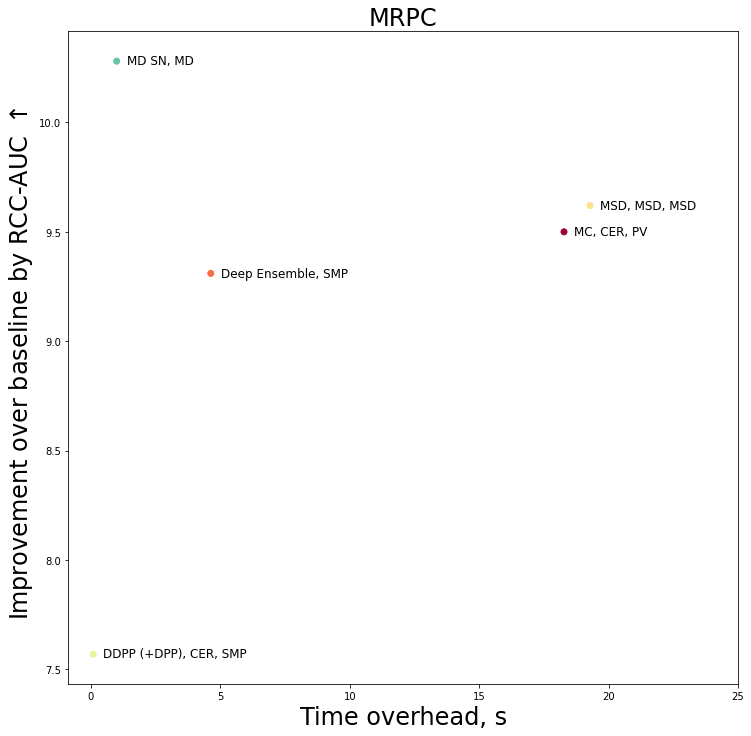

In [170]:
names = ['MC, CER, PV', 'Deep Ensemble, SMP', 'MSD, MSD, MSD', 'DDPP (+DPP), CER, SMP', 'MD SN, metric, MD']
baseline = 22.32
times = [18.28, 4.63, 19.2845, 447.60, 0.9942]
times_stds = [0.18, 0.033, 0.2062, 9.01, 0.0148]
# fix time for DPP
times[-2] = 0.47 / 100 * times[0]
times_stds[-2] = 0.47 / 100 * times_stds[0]
metr = [12.82, 13.01, 12.70, 14.75, 12.04]
metr_stds = [1.89, 2.57, 1.61, 1.43, 1.33]
metr = [baseline - x for x in metr]
fig = plt.figure(figsize = (12, 12))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])

cmap = matplotlib.cm.get_cmap('Spectral')
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = colors[::len(colors) // len(names)][:len(names)]

ax.scatter(times, metr, c=colors, marker='o')
mainfontsize = 24
label_size = 12
#ax.errorbar(times, metr, xerr=times_stds, yerr=metr_stds, ecolor=colors, fmt='none')

for i, name in enumerate(names):
    ax.annotate(name, (times[i], metr[i]), xytext=(10, 0),
                textcoords='offset points', ha='left', va='center', fontsize=label_size)


ax.set_xticks(np.arange(0, 26, 5))
#ax.set_yticklabels(x_pos[order])
#ax.set_xlabel('Time, s', fontsize=mainfontsize)
#ax.set_ylabel('RCC-AUC', fontsize=mainfontsize)
ax.set_xlabel('Time overhead, s', fontsize=mainfontsize)
ax.set_ylabel('Improvement over baseline by RCC-AUC $\\uparrow$ ', fontsize=mainfontsize)
ax.set_title('MRPC', fontsize=mainfontsize)
plt.savefig(f'../../mrpc_time.png', bbox_inches='tight')
plt.savefig(f'../../mrpc_time.pdf', bbox_inches='tight')
plt.show()

In [56]:
table_column_to_floats(metrics_df[('MRPC', 'rcc-auc')])

([13.97,
  14.21,
  14.38,
  24.2,
  24.97,
  22.27,
  24.03,
  24.83,
  23.95,
  20.74,
  22.74,
  13.14,
  13.69,
  16.38,
  22.32],
 [1.16,
  1.04,
  2.07,
  10.32,
  10.13,
  8.58,
  10.22,
  9.51,
  9.78,
  4.15,
  3.94,
  2.66,
  1.25,
  9.13,
  8.08])

# Compare SNGP

In [24]:
datasets = ['mrpc', 'sst2', 'cola']
cls_dfs = []
cls_dfs1 = []
cls_dfs2 = []
for dataset in datasets:
    # mrpc electra MC all
    regs = ['-', 'CER', 'metric']
    metrics = ['rcc-auc', 'rpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']    
    
    # sngp on old params
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_raw_sngp/',]
    de_regs = ['-']
    de_ues = ['sngp']
    ue_methods = ['std']
    df_de_63, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'SNGP old params', ner_prefix=None)
    method_names = method_buf
    reg_names = reg_buf
    
    # sngp on new params
    ue_methods = ['stds']
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_sngp_old_net/',]
    df_de_75, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'SNGP new params', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    # sngp on new params paper version
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_sngp_old_net_paper_ue/',]
    df_de_90, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'SNGP paper', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    #method2 = method_buf
    #reg2 = reg_buf
    # df for best results
    full_df = pd.concat([df_de_63, df_de_75, df_de_90])
    # df for table 1
    cls_dfs.append(full_df)

In [25]:
# same for ner
dataset = ''
ner_prefixes = ['token', 'seq']
ner_dfs = []
ner_dfs1 = []
ner_dfs2 = []
for ner_prefix in ner_prefixes:
    # mrpc electra MC all
    regs = ['-', 'CER', 'metric']
    ues = ['all', 'all', 'all']
    metrics = ['rcc-auc', 'rpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    # sngp on old params
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_raw_sngp/conll2003/',]
    de_regs = ['-']
    de_ues = ['sngp']
    ue_methods = ['stds']
    df_de_63, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'SNGP old params', ner_prefix)
    method_names = method_buf
    reg_names = reg_buf
    
    # sngp on new params
    ue_methods = ['stds']
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_sngp_old_net/conll/',]
    df_de_75, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'SNGP new params', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # sngp on new params paper version
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_sngp_old_net_paper_ue/conll/',]
    df_de_90, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'SNGP paper', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    #method2 = method_buf
    #reg2 = reg_buf
    # df for best results
    full_df = pd.concat([df_de_63, df_de_75, df_de_90])
    ner_dfs.append(full_df)
    

/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_raw_sngp/conll2003//sngp/metrics_token_rcc-auc.json
/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_raw_sngp/conll2003//sngp/metrics_token_rpp.json
/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_raw_sngp/conll2003//sngp/metrics_seq_rcc-auc.json
/home/jovyan/uncertainty-estimation/workdir/new_final_results/electra_20_old_net/electra_raw_sngp/conll2003//sngp/metrics_seq_rpp.json


In [26]:
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs = cls_dfs + ner_dfs
full_df = add_multiindex(all_dfs, dataset_names, metrics)
#cls_df = pd.concat(all_dfs, axis=1)
dff = add_labels(full_df, method_names, reg_names)
#best_res_electra_old_net = select_best(dff, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
SNGP old params &         - &     STD &  \underline{14.52$\pm$2.48

# Compare DE

In [142]:
datasets = ['mrpc', 'sst2', 'cola']
cls_dfs = []
cls_dfs1 = []
cls_dfs2 = []
for dataset in datasets:
    # mrpc electra MC all
    regs = ['-', 'CER', 'metric']
    metrics = ['rcc-auc', 'rpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/diff_de/electra_wide_63/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de_63, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble 63', ner_prefix=None)
    method_names = method_buf
    reg_names = reg_buf
    # de 75
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/diff_de/electra_wide_75/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de_75, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble 75', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    # de 90
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/diff_de/electra_wide_90/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de_90, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble 90', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    # de 100
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/diff_de/electra_wide_100/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de_100, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble 100', ner_prefix=None)
    method_names += method_buf
    reg_names += reg_buf
    #method2 = method_buf
    #reg2 = reg_buf
    # df for best results
    full_df = pd.concat([df_de_63, df_de_75, df_de_90, df_de_100])
    # df for table 1
    cls_dfs.append(full_df)

In [143]:
# same for ner
dataset = ''
ner_prefixes = ['token', 'seq']
ner_dfs = []
ner_dfs1 = []
ner_dfs2 = []
for ner_prefix in ner_prefixes:
    # mrpc electra MC all
    regs = ['-', 'CER', 'metric']
    ues = ['all', 'all', 'all']
    metrics = ['rcc-auc', 'rpp']
    ue_methods = ['variance', 'bald', 'sampled_max_prob']
    # mrpc electra de
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/diff_de/electra_wide_63/conll2003/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de_63, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble 63', ner_prefix)
    method_names = method_buf
    reg_names = reg_buf
    # de 75
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/diff_de/electra_wide_75/conll2003/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de_75, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble 75', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # de 90
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/diff_de/electra_wide_90/conll2003/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de_90, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble 90', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    # de 100
    de_pathes = ['/home/jovyan/uncertainty-estimation/workdir/new_final_results/diff_de/electra_wide_100/conll2003/',]
    de_regs = ['-']
    de_ues = ['ensemble']
    df_de_100, method_buf, reg_buf = build_section(de_pathes, de_regs, de_ues, dataset, ue_methods, metrics, 'Deep Ensemble 100', ner_prefix)
    method_names += method_buf
    reg_names += reg_buf
    #method2 = method_buf
    #reg2 = reg_buf
    # df for best results
    full_df = pd.concat([df_de_63, df_de_75, df_de_90, df_de_100])
    ner_dfs.append(full_df)
    

In [144]:
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
all_dfs = cls_dfs + ner_dfs
full_df = add_multiindex(all_dfs, dataset_names, metrics)
#cls_df = pd.concat(all_dfs, axis=1)
dff = add_labels(full_df, method_names, reg_names)
#best_res_electra_old_net = select_best(dff, metrics, ['rcc-auc'], dataset_names).dropna()

latex_table = prepare_latex_table(dff)
print(latex_table)

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
        \begin{tabular}{l|l|l||c|c||c|c||c|c||c|c||c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} &          \multirow{2}{*}{\textbf{\multirowcell{Reg.\\Type}}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{2}{c||}{\textbf{MRPC}} & \multicolumn{2}{c||}{\textbf{SST-2}} & \multicolumn{2}{c||}{\textbf{CoLA}} & \multicolumn{2}{c||}{\textbf{CoNLL-2003 (token level)}} & \multicolumn{2}{c}{\textbf{CoNLL-2003 (seq. level)}}\\

              \cline{4-13}
                 & & &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &  \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}&   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$} &   \textbf{RCC-AUC $\downarrow$} &      \textbf{RPP $\downarrow$}\\

        \midrule \hline 
 Deep Ensemble 63 &         - &         PV &             21.55$\pm

# For new results

# Now add code for bar charts on best table

In [163]:
def table_column_to_floats(column):
    means = []
    stds = []
    for value in column:
        buf = value.split('$\\pm$')
        mean, std = buf[0].split('{')[-1], buf[1].split('}')[0]
        means.append(float(mean))
        stds.append(float(std))
    return means, stds


def process_names(names):
    for idx, name in enumerate(names):
        names[idx] = names[idx].replace('+ - ', '')
        names[idx] = names[idx].replace(', -', '')
        names[idx] = names[idx].replace(' (ours)', '')
        names[idx] = names[idx].replace('sampled_max_prob', 'SMP')
        names[idx] = names[idx].replace('variance', 'PV')
        names[idx] = names[idx].replace('mixup', 'MSD')
        names[idx] = names[idx].replace('max_prob', 'MP')
        names[idx] = names[idx].replace('mahalanobis_distance', 'MD')
    return names


def get_unique_names(best_res, names):
    table_methods = np.unique(best_res['Method'])
    unique_dict = {}
    for meth in table_methods:
        unique_dict[meth] = []
        for name in names:
            if meth in name:
                if 'MD SN' not in name and meth == 'MD':
                    unique_dict[meth].append(names.index(name))
                if 'baseline' not in name and meth == 'SR':
                    unique_dict[meth].append(names.index(name))
                if meth != 'MD' and meth != 'SR':
                    unique_dict[meth].append(names.index(name))
    return unique_dict


def plot_bar_charts_by_table(best_res, dataset, metrics, name_prefix='electra_', ids=None, metric_type=None, ordered=False):
    #table_values = table_column_to_floats(best_res[(dataset, metric)])
    #best_methods = best_res['Method'] + ', ' + best_res['Reg. Type'] + ', ' + best_res['UE Score']
    #pass
    mainfontsize = 44
    tickfontsize = 44
    if 'electra' in name_prefix:
        fig = plt.figure(figsize = (12, 12))
    else:
        fig = plt.figure(figsize = (12, 12))
    gs = fig.add_gridspec(1, len(metrics))
    for i, metric in enumerate(metrics):
        #means, stds, names = load_dataset_res(pathes, metric, metric_type)
        means, stds = table_column_to_floats(best_res[(dataset, metric)])
        means = np.array(means)
        stds = np.array(stds)
        names = list(best_res['Method'] + ', ' + best_res['Reg. Type'] + ', ' + best_res['UE Score'])
        names_ids = get_unique_names(best_res, names)
        best_ids = []
        for key, value in names_ids.items():
            if 'SR' in key:
                best_ids += value
            else:
                best_ids += [value[np.argmin(means[value])]]
        means = means[best_ids]
        stds = stds[best_ids]
        #for key, values in unique_dict.items():
        #    names_ids = 
        names = process_names(names)
        names = np.array(names)
        names = names[best_ids]
        # filter dpp
        dpp_best = []
        for idx, name in enumerate(names):
            if 'DDPP' in name:
                dpp_best.append((means[idx], idx))
        dpp_best.sort(key=lambda tup: tup[0])
        worse_dpp = dpp_best[-1][-1]
        names = np.delete(names, worse_dpp)
        means = np.delete(means, worse_dpp)
        stds = np.delete(stds, worse_dpp)
        if ids is not None:
            means, stds, names = means[ids], stds[ids], names[ids]
        ax = fig.add_subplot(gs[0, i])

        cmap = matplotlib.cm.get_cmap('Spectral')
        colors = []
        for i in range(cmap.N):
            rgb = cmap(i)[:3]
            colors.append(matplotlib.colors.rgb2hex(rgb))
        colors = colors[::len(colors) // len(names)]
        x_pos = np.array(list(range(len(names))))
        #print(x_pos)
        #x_pos_bar = x_pos * 0.5
        #print(x_pos_bar)
        #x_pos = list(map(str, x_pos))
        if ordered:
            order = np.argsort(means)[::-1]
        else:
            order = x_pos
        # vertical version
        #ax.bar(x_pos, means[order], yerr=stds[order], width=0.8, align='center', alpha=1, color=colors, edgecolor='black', ecolor='black', capsize=6)
        '''
        ax.set_ylabel(f'{metric.upper()}', fontsize=mainfontsize)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(x_pos[order])

        ax.tick_params(labelsize=tickfontsize)
        ax.set_title(f'{metric.upper()} for {dataset}')
        ax.yaxis.grid(True)
        '''
        ax.barh(x_pos, means[order], xerr=stds[order], height=0.8, align='center', alpha=1, color=colors, edgecolor='black', ecolor='black', capsize=6)
        ax.set_xlabel(f'{metric.upper()}', fontsize=mainfontsize)
        ax.set_yticks(x_pos)
        ax.set_yticklabels(reversed(x_pos[order]))

        ax.tick_params(labelsize=tickfontsize)
        ax.set_title(f'{metric.upper()} for {dataset}', fontsize=mainfontsize)
        ax.xaxis.grid(True)
        patches = [matplotlib.patches.Patch(color=v, label=f'{x}. {k}') for x, k, v in zip((x_pos), reversed(names), reversed(colors[:-1]))]
    plt.tight_layout()
    #plt.legend(handles=patches, loc='center', fontsize=mainfontsize, bbox_to_anchor=(-0.1, -0.16), ncol=4, edgecolor='black')
    #plt.legend(handles=patches, loc='center', fontsize=mainfontsize, bbox_to_anchor=(0.5, -0.62), ncol=1, edgecolor='black')
    #plt.legend(handles=patches, loc='center', fontsize=mainfontsize, bbox_to_anchor=(-0.01, -1.12, 1, 1), ncol=1, edgecolor='black')
    plt.legend(handles=patches, loc='center', fontsize=mainfontsize, bbox_to_anchor=(-0.04, -1.12, 1.08, 1), mode='expand', ncol=1, edgecolor='black')
    plt.savefig(f'../../{name_prefix + "_".join(dataset.split(" "))}.pdf', bbox_inches='tight')
    plt.savefig(f'../../{name_prefix + "_".join(dataset.split(" "))}.png', bbox_inches='tight')
    plt.show()


In [164]:
ids = [2,1,5,0,3,4,6,7,8]
ids.reverse()
print(ids)

[8, 7, 6, 4, 3, 0, 5, 1, 2]


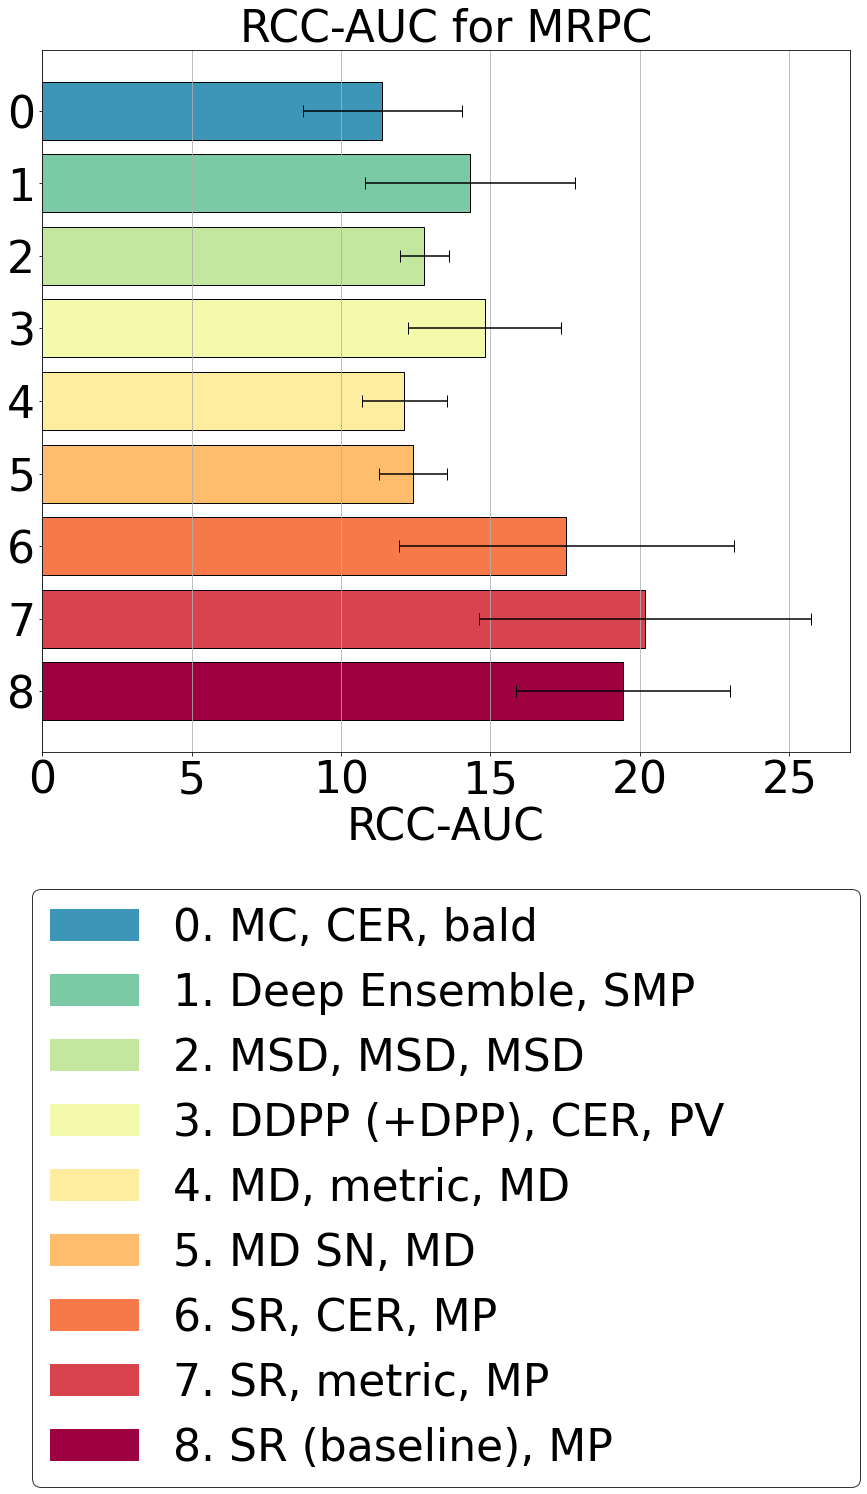

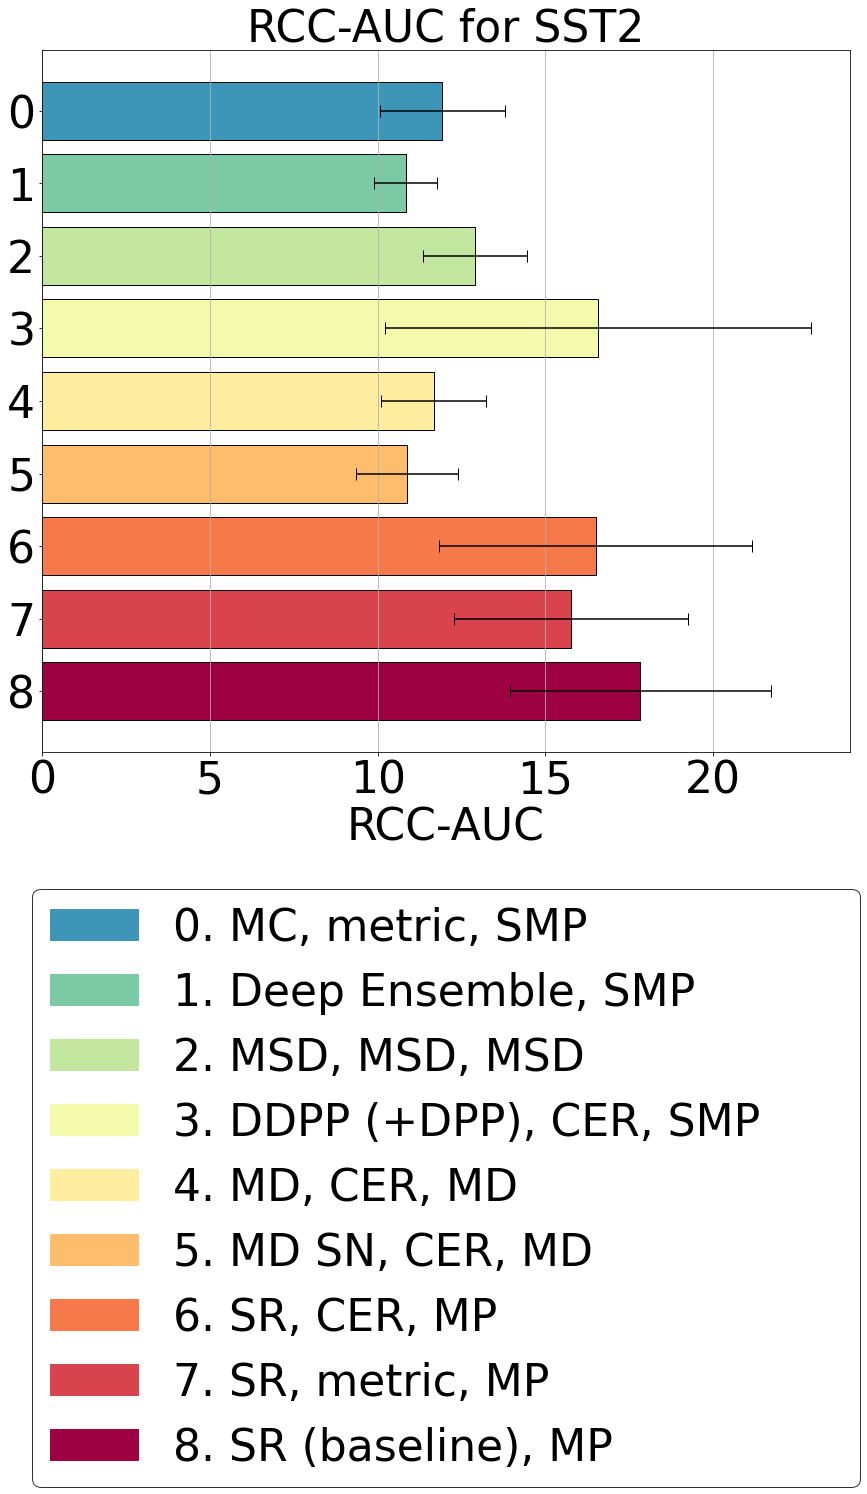

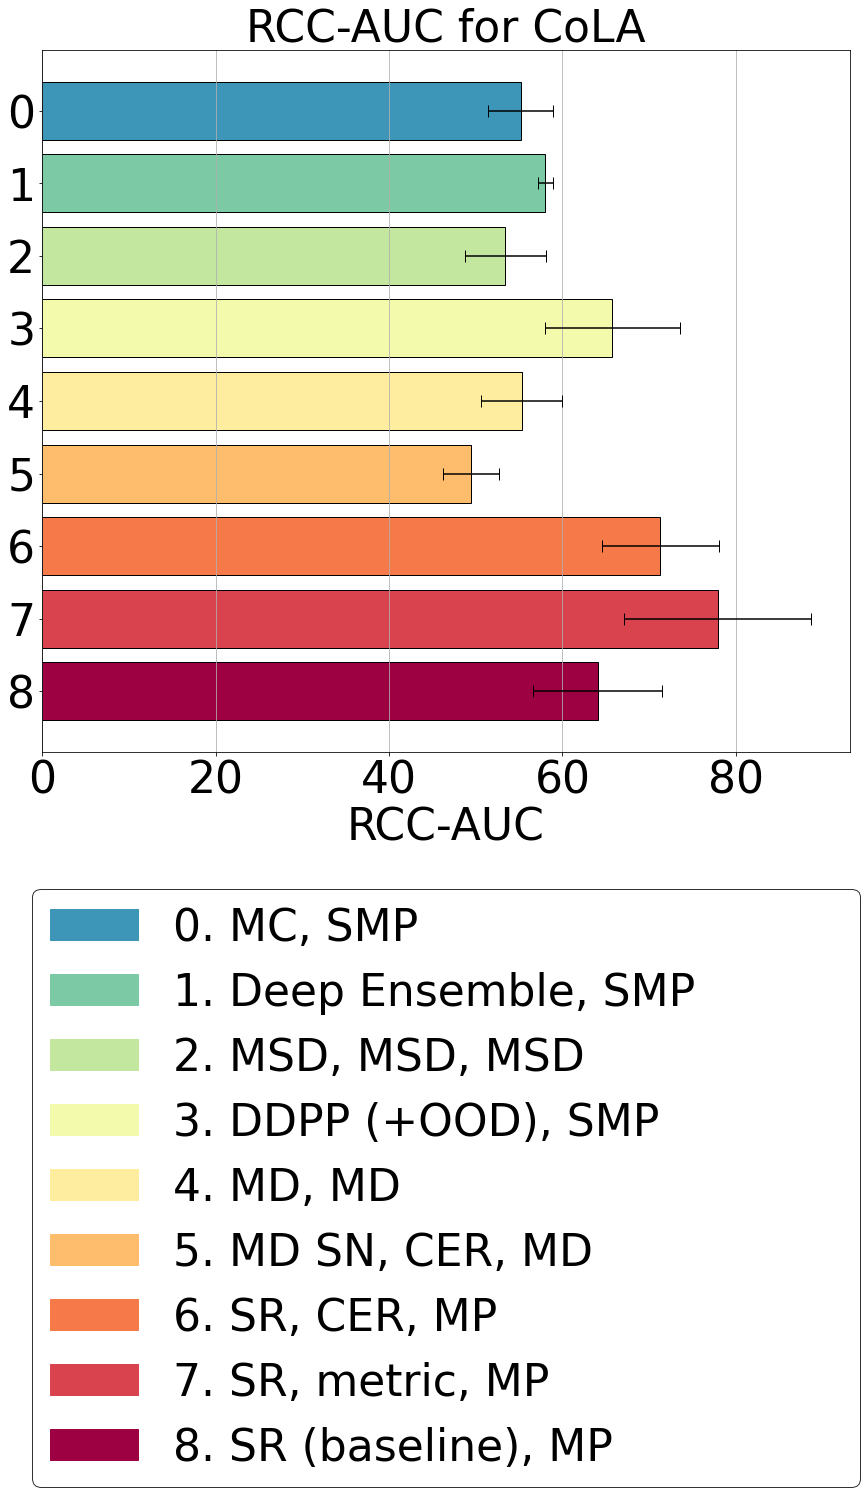

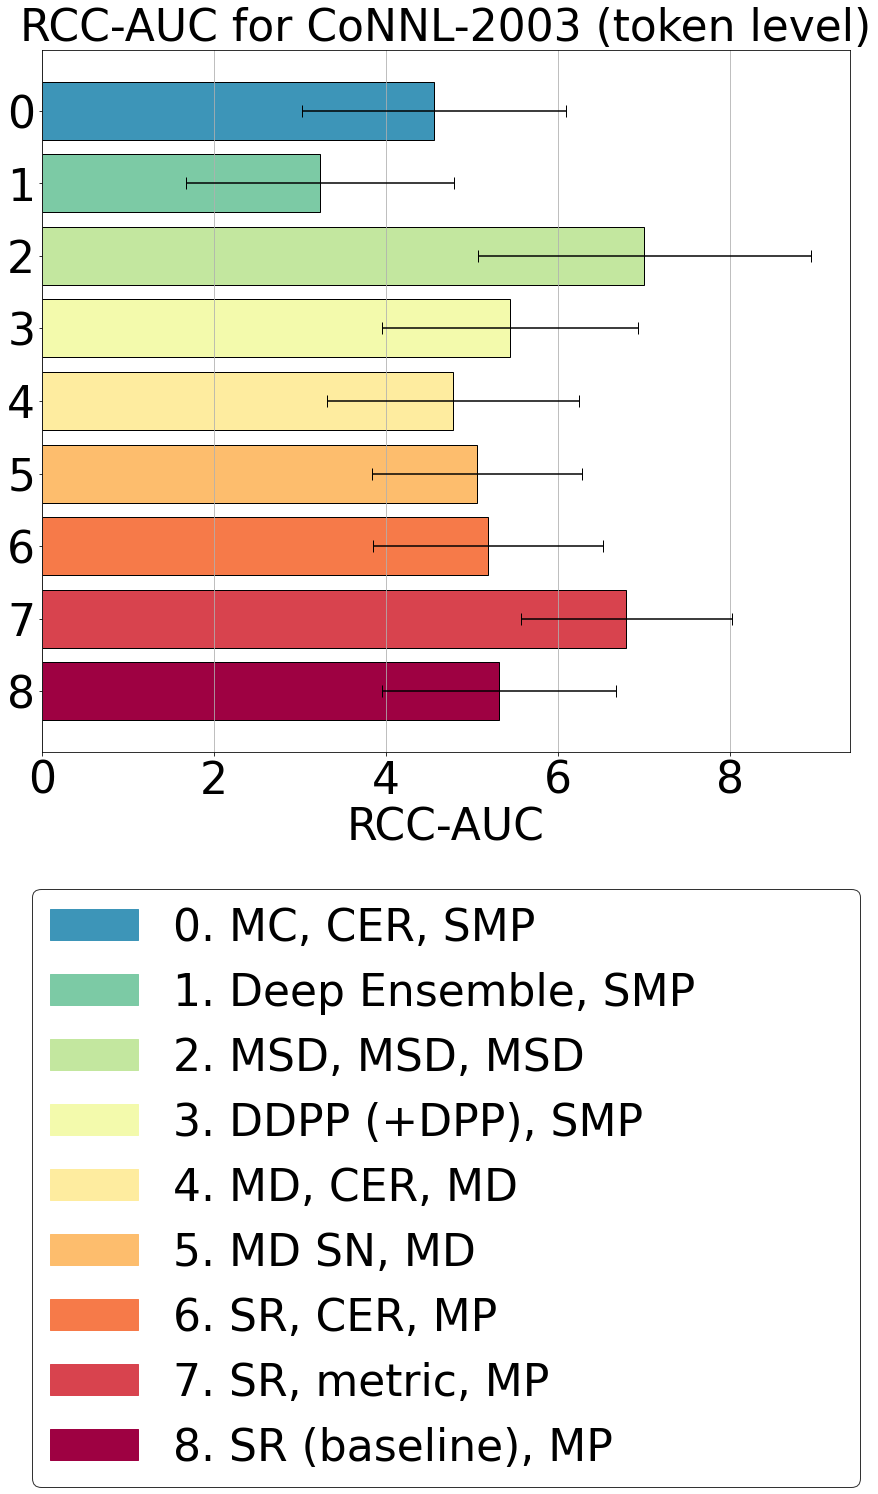

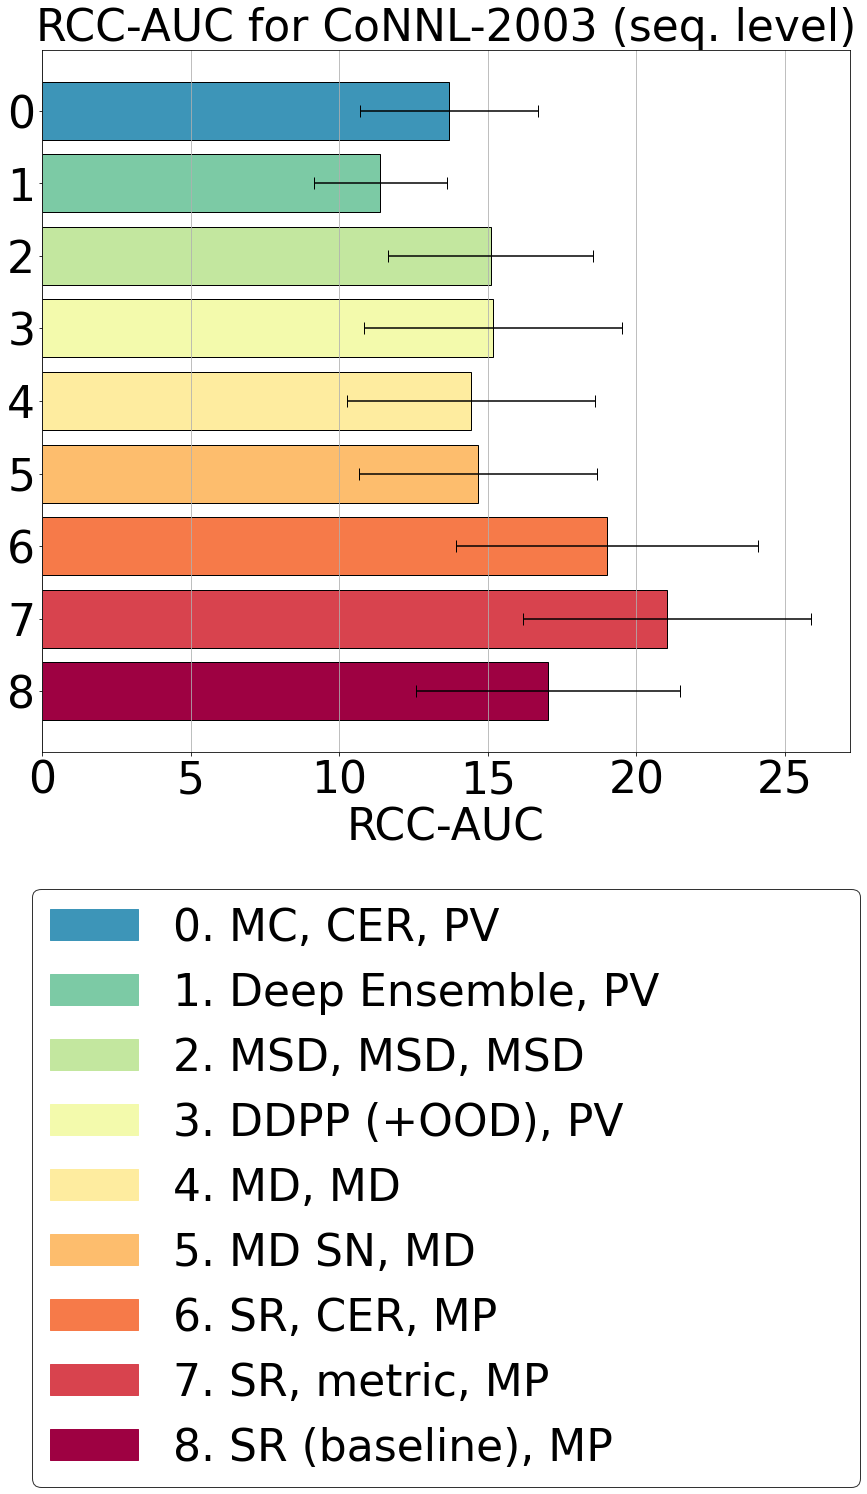

In [165]:
# New ensemble on 90 %, new sngp, filtered outliers
metrics = ['rcc-auc']#, 'rpp']
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
for dataset in dataset_names:
    plot_bar_charts_by_table(best_res_deberta_new_dpp, dataset, metrics, name_prefix='workdir/new_final_results/deberta_recalc/bar_charts_deberta_recalc_new_dpp/deberta_', ids=ids)

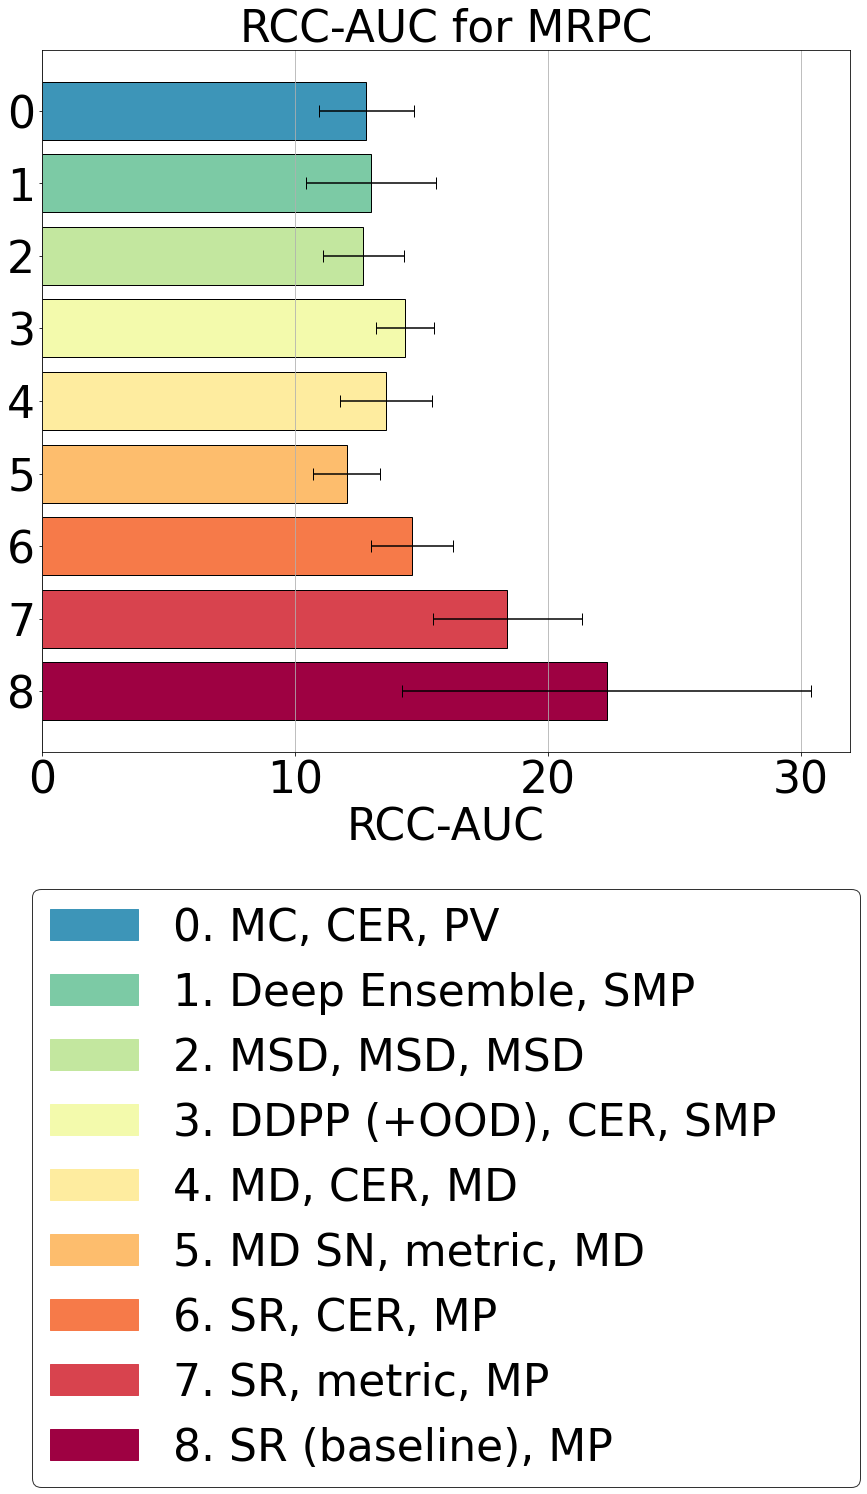

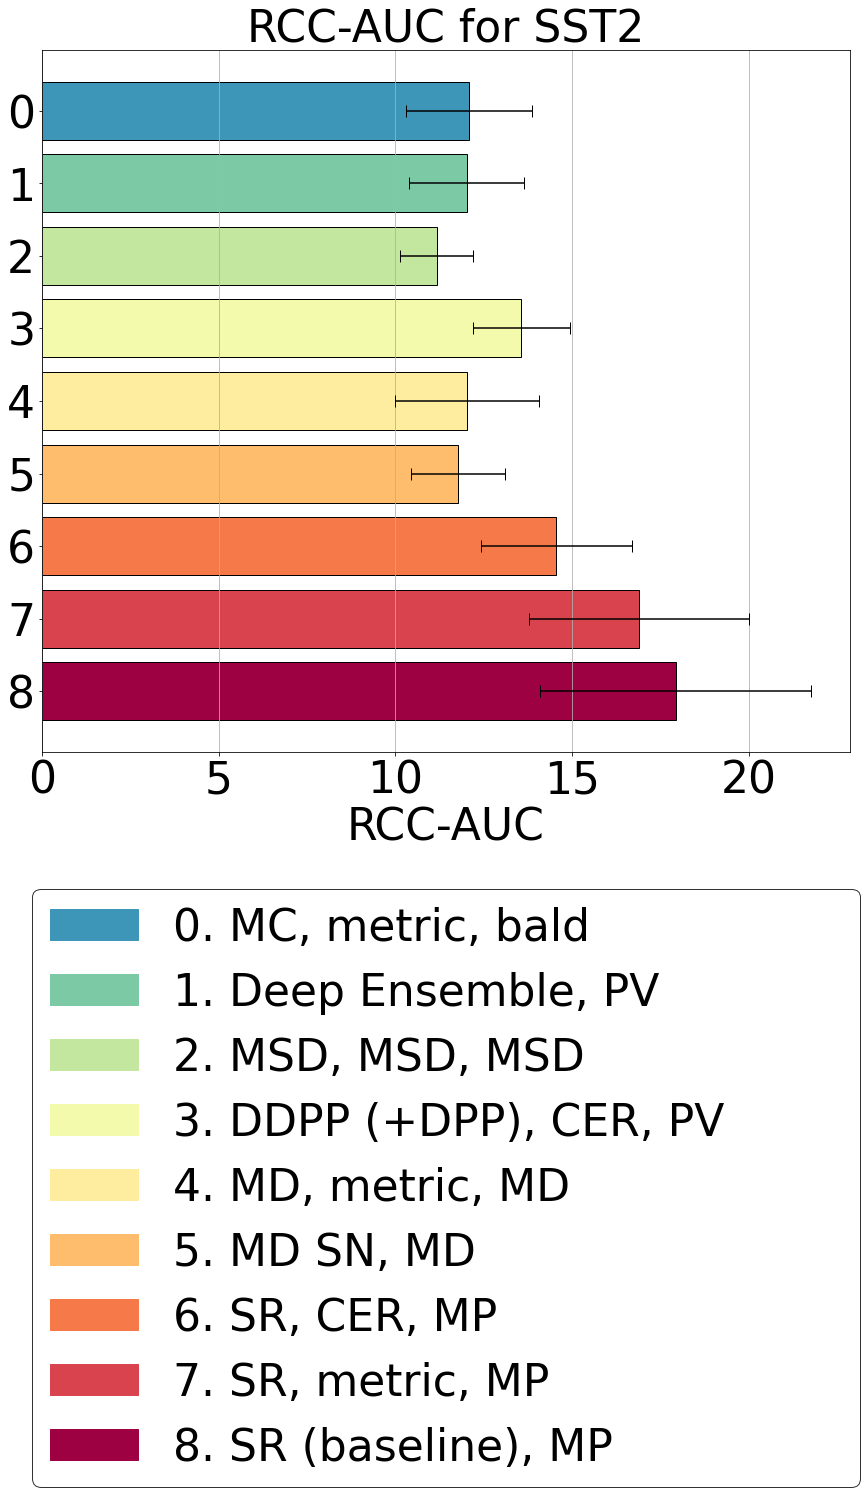

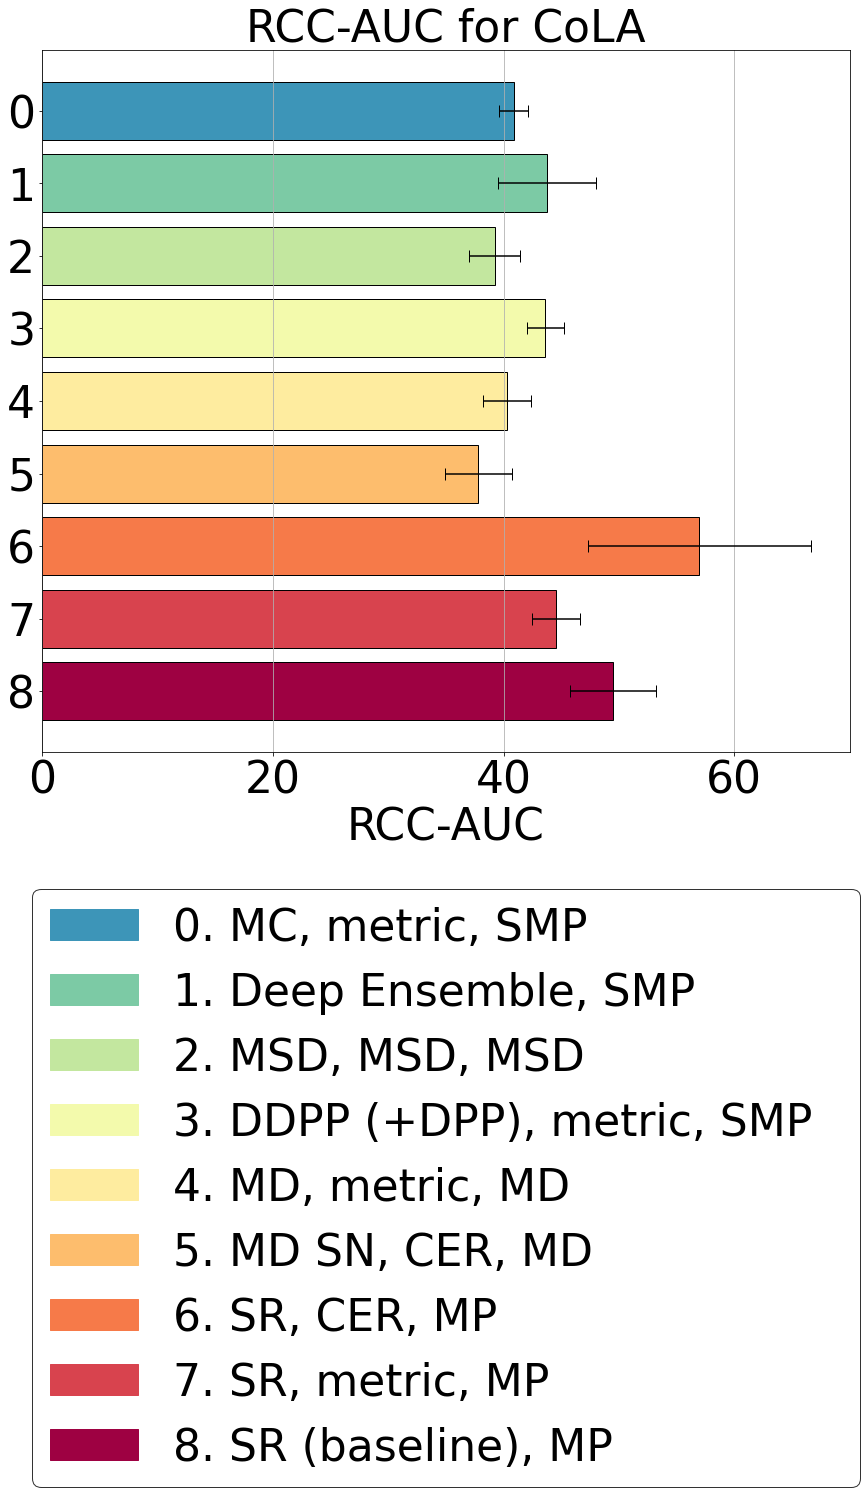

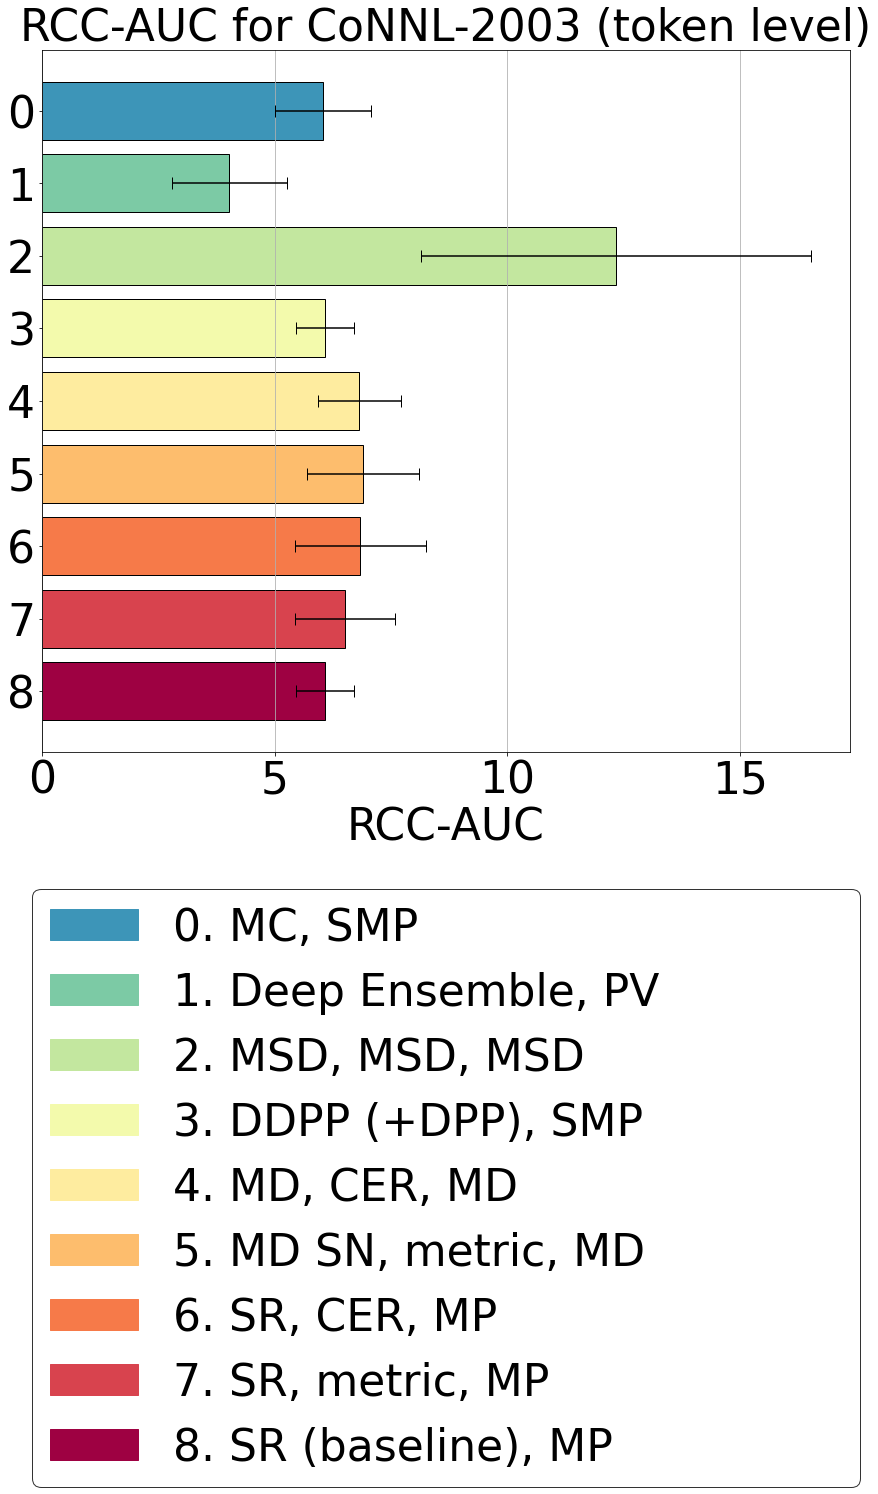

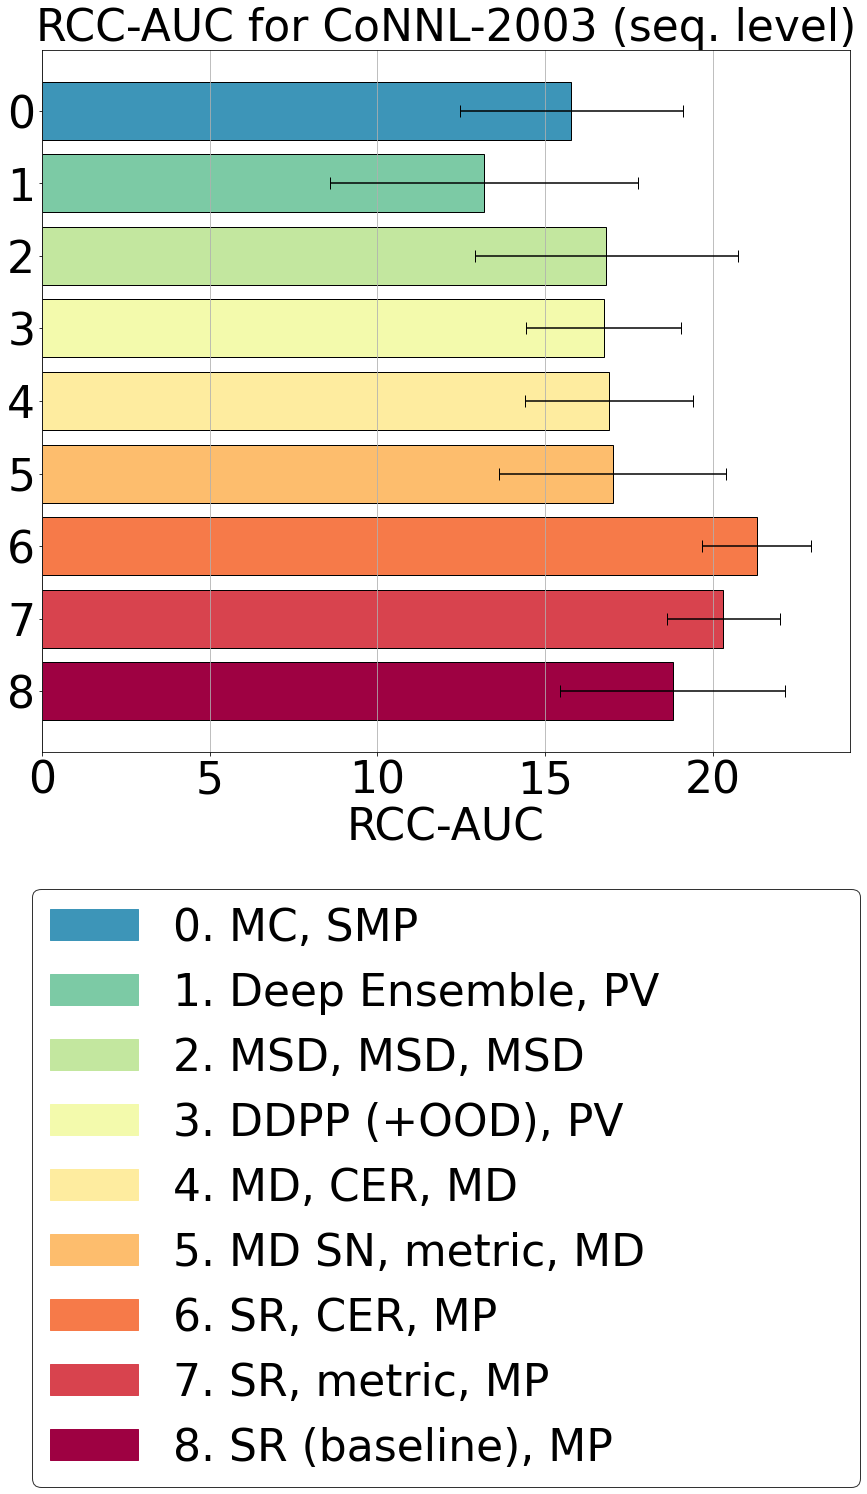

In [166]:
# New ensemble on 90 %, new sngp, filtered outliers
metrics = ['rcc-auc']#, 'rpp']
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
for dataset in dataset_names:
    plot_bar_charts_by_table(best_res_electra_old_net_de_90_new_dpp, dataset, metrics, name_prefix='workdir/new_final_results/electra_20_old_net/electra_old_net_bar_charts_new_dpp/electra_', ids=ids)

In [162]:
# New ensemble on 90 %, new sngp, filtered outliers
metrics = ['rcc-auc']#, 'rpp']
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
for dataset in dataset_names:
    plot_bar_charts_by_table(best_res_electra_old_net_de_90, dataset, metrics, name_prefix='workdir/new_final_results/electra_20_old_net/electra_old_net_bar_charts_new_de/electra_', ids=None)

NameError: name 'best_res_electra_old_net_de_90' is not defined

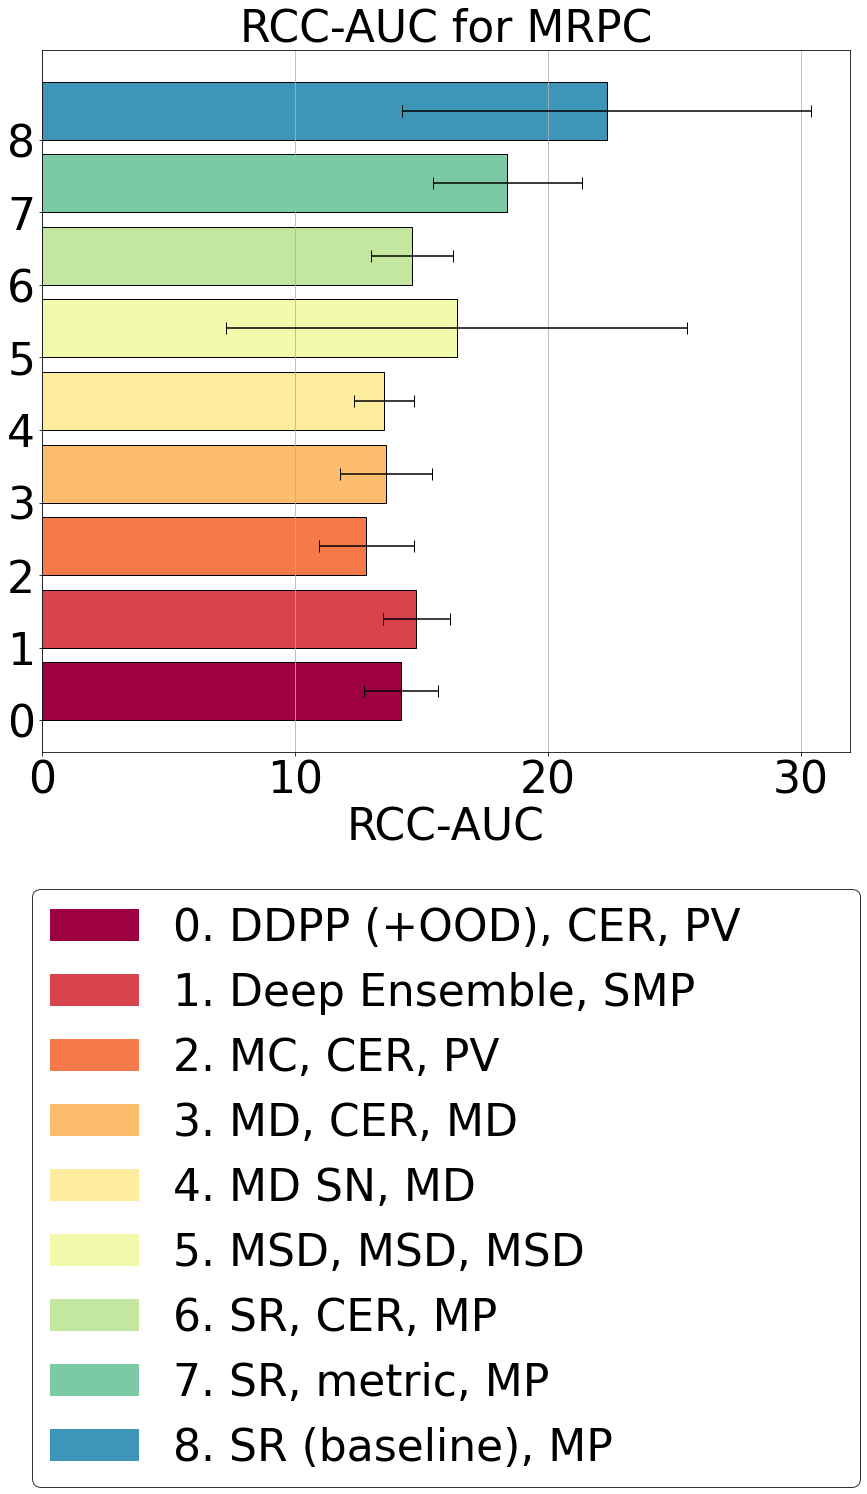

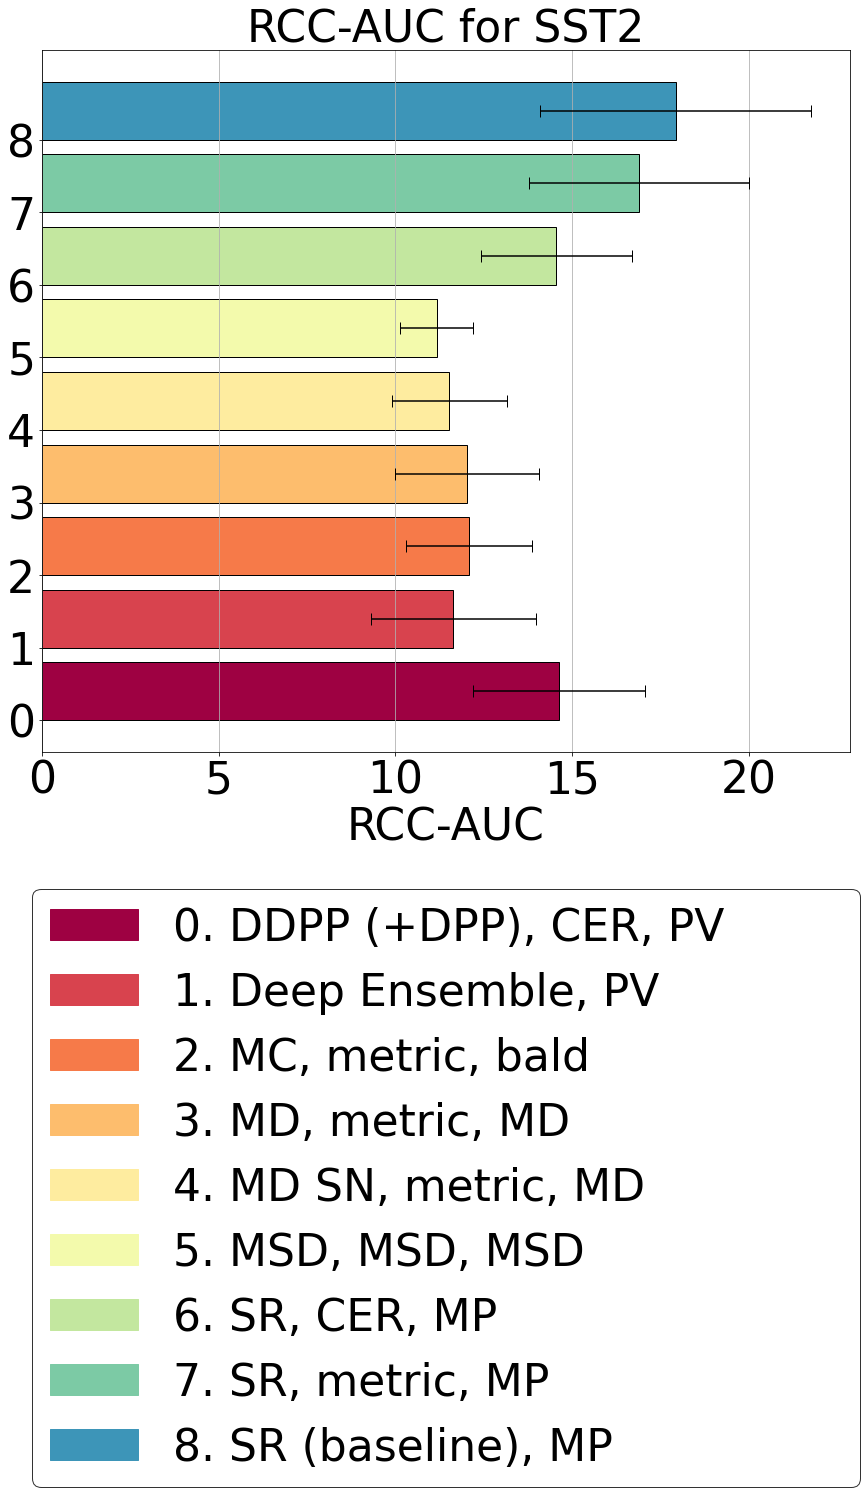

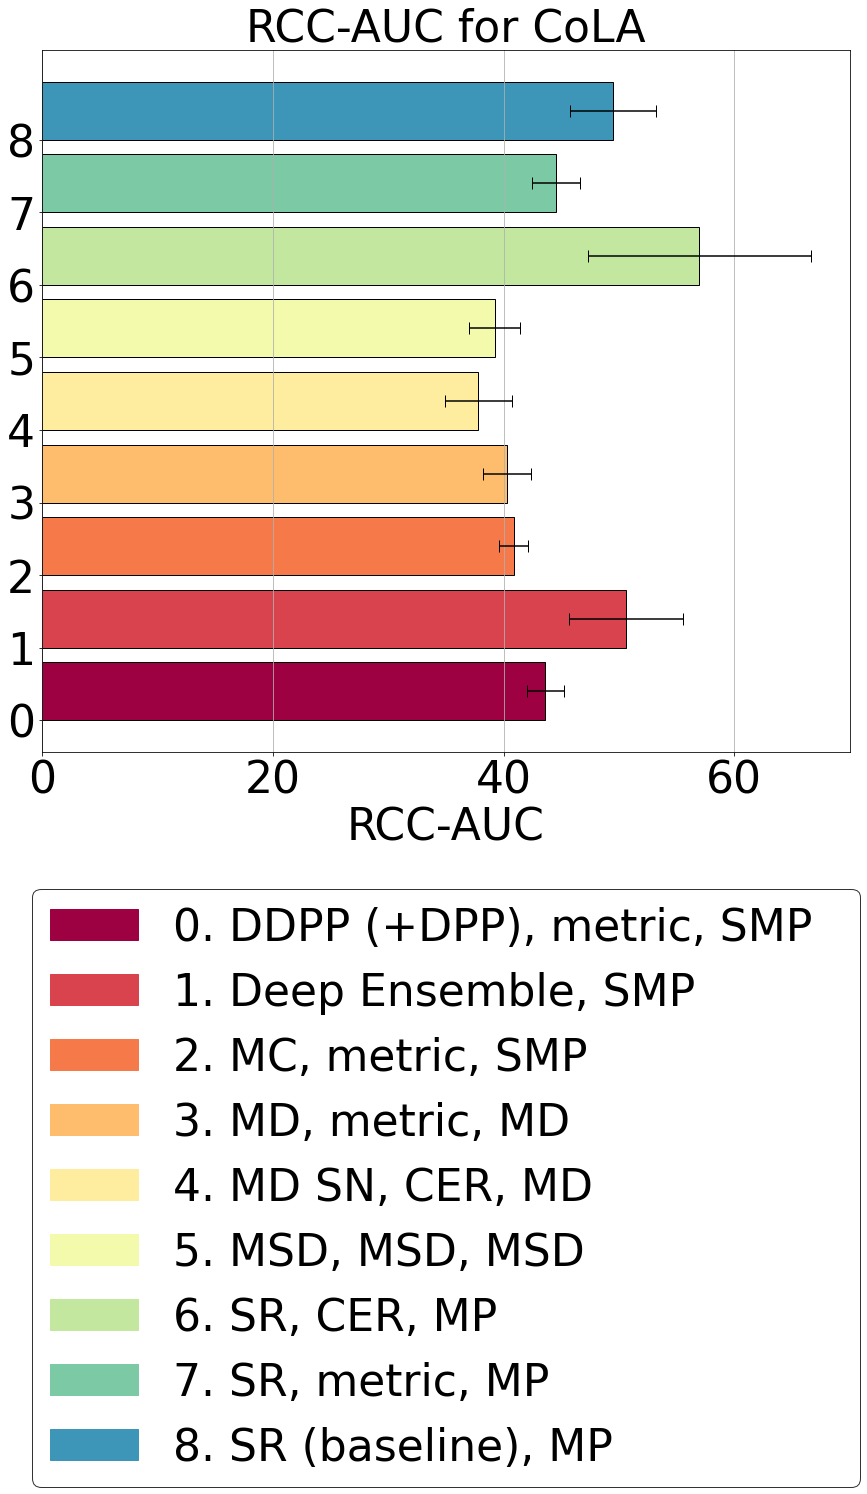

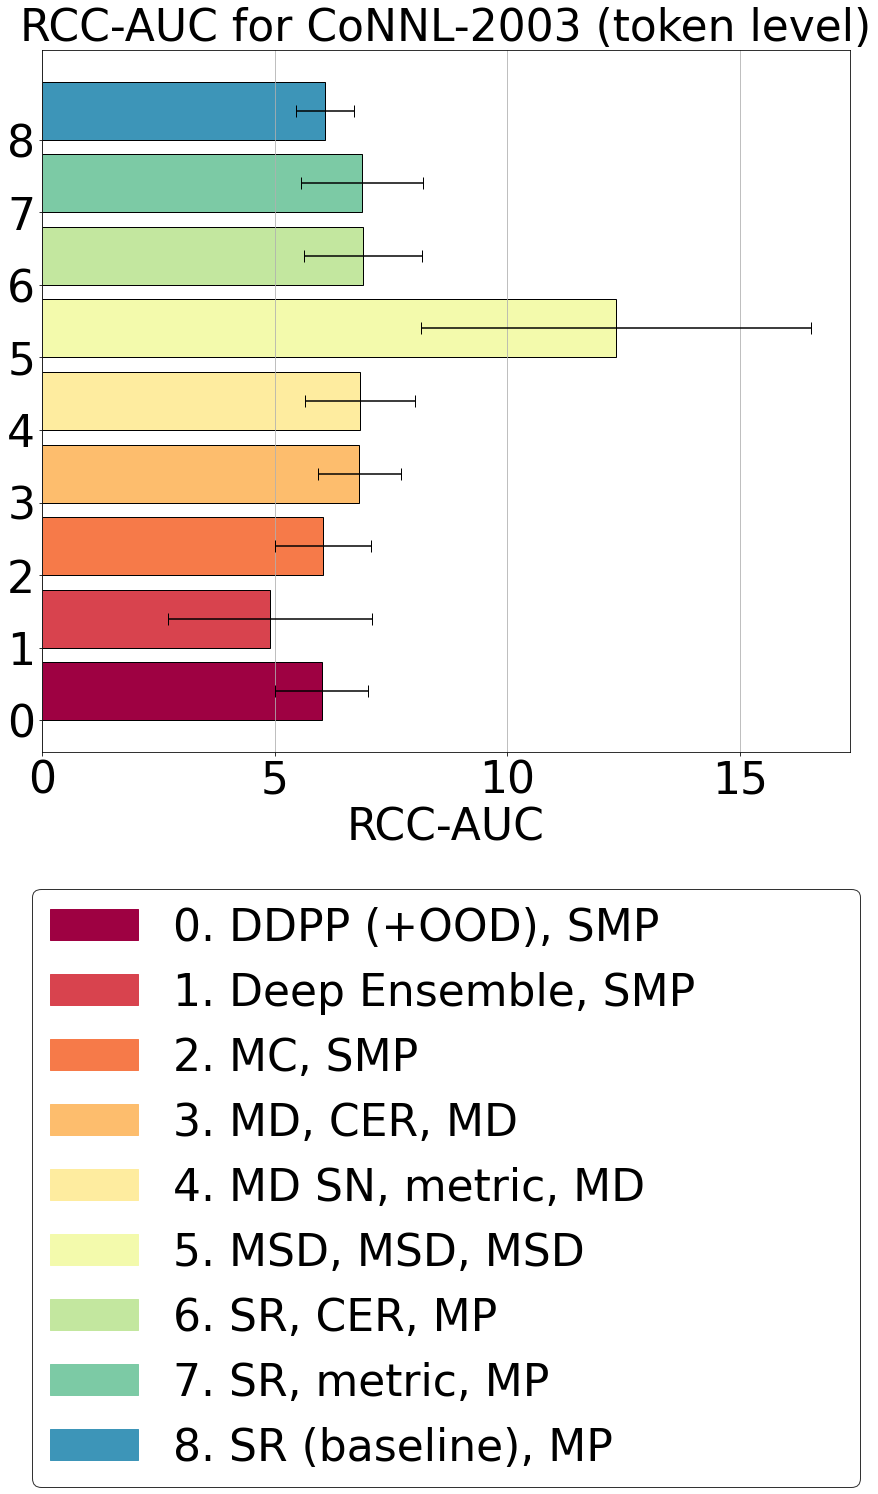

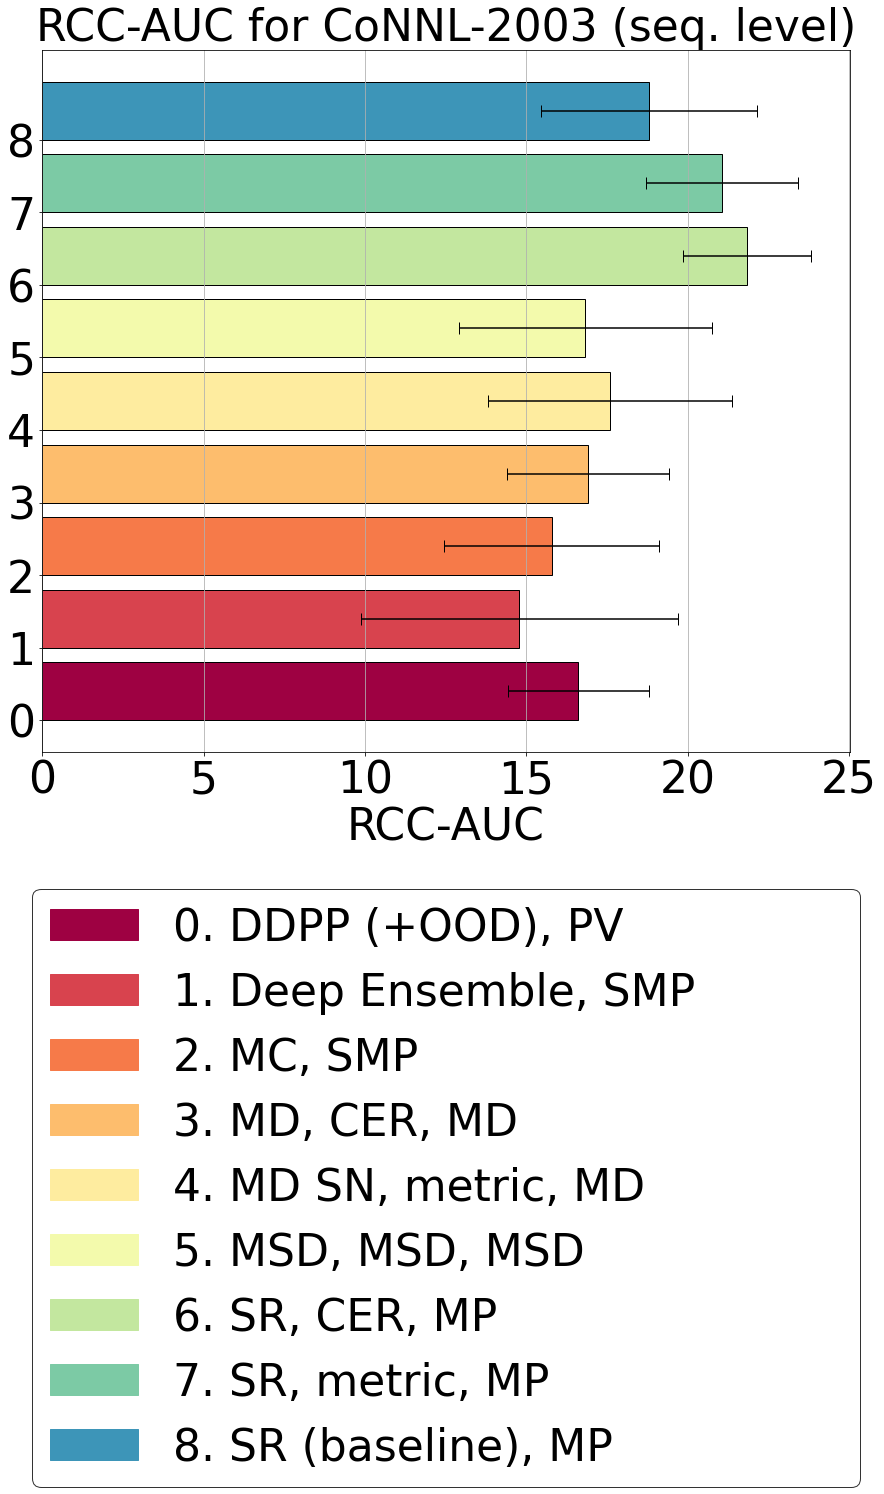

In [84]:
metrics = ['rcc-auc']#, 'rpp']
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
for dataset in dataset_names:
    plot_bar_charts_by_table(best_res_electra_old_net, dataset, metrics, name_prefix='workdir/new_final_results/electra_20_old_net/electra_old_net_bar_charts/electra_', ids=None)

In [85]:
metrics = ['rcc-auc']#, 'rpp']
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
for dataset in dataset_names:
    plot_bar_charts_by_table(best_res_old_electra, dataset, metrics, name_prefix='workdir/final_results/electra_old_bar_charts/electra_', ids=None)

NameError: name 'best_res_old_electra' is not defined

In [86]:
metrics = ['rcc-auc']#, 'rpp']
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
for dataset in dataset_names:
    plot_bar_charts_by_table(best_res_electra_new, dataset, metrics, name_prefix='workdir/new_final_results/electra/bar_charts_electra_rcc_best_hor_big/electra_', ids=None)

NameError: name 'best_res_electra_new' is not defined

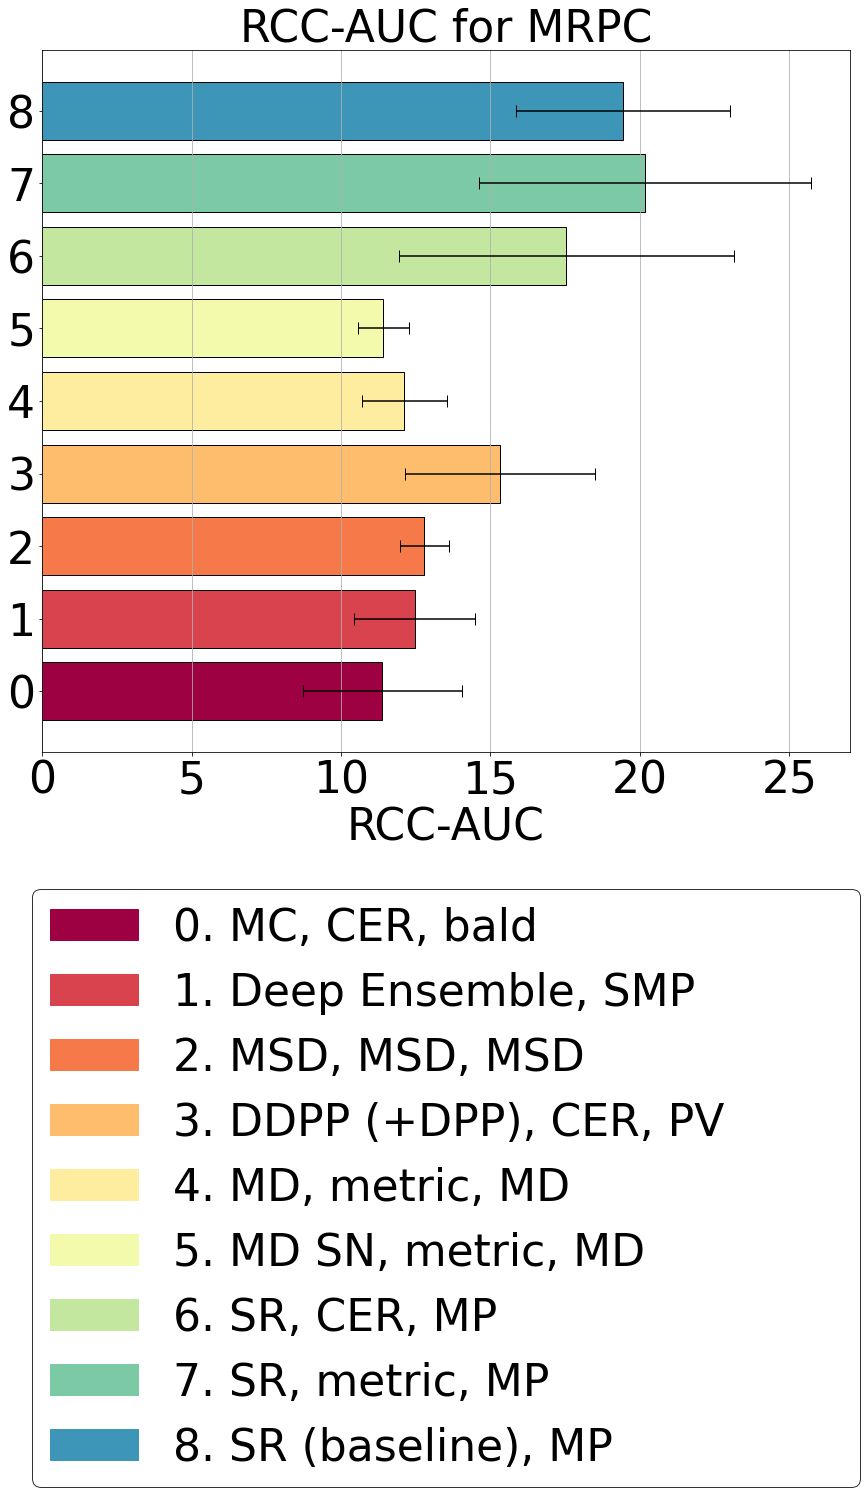

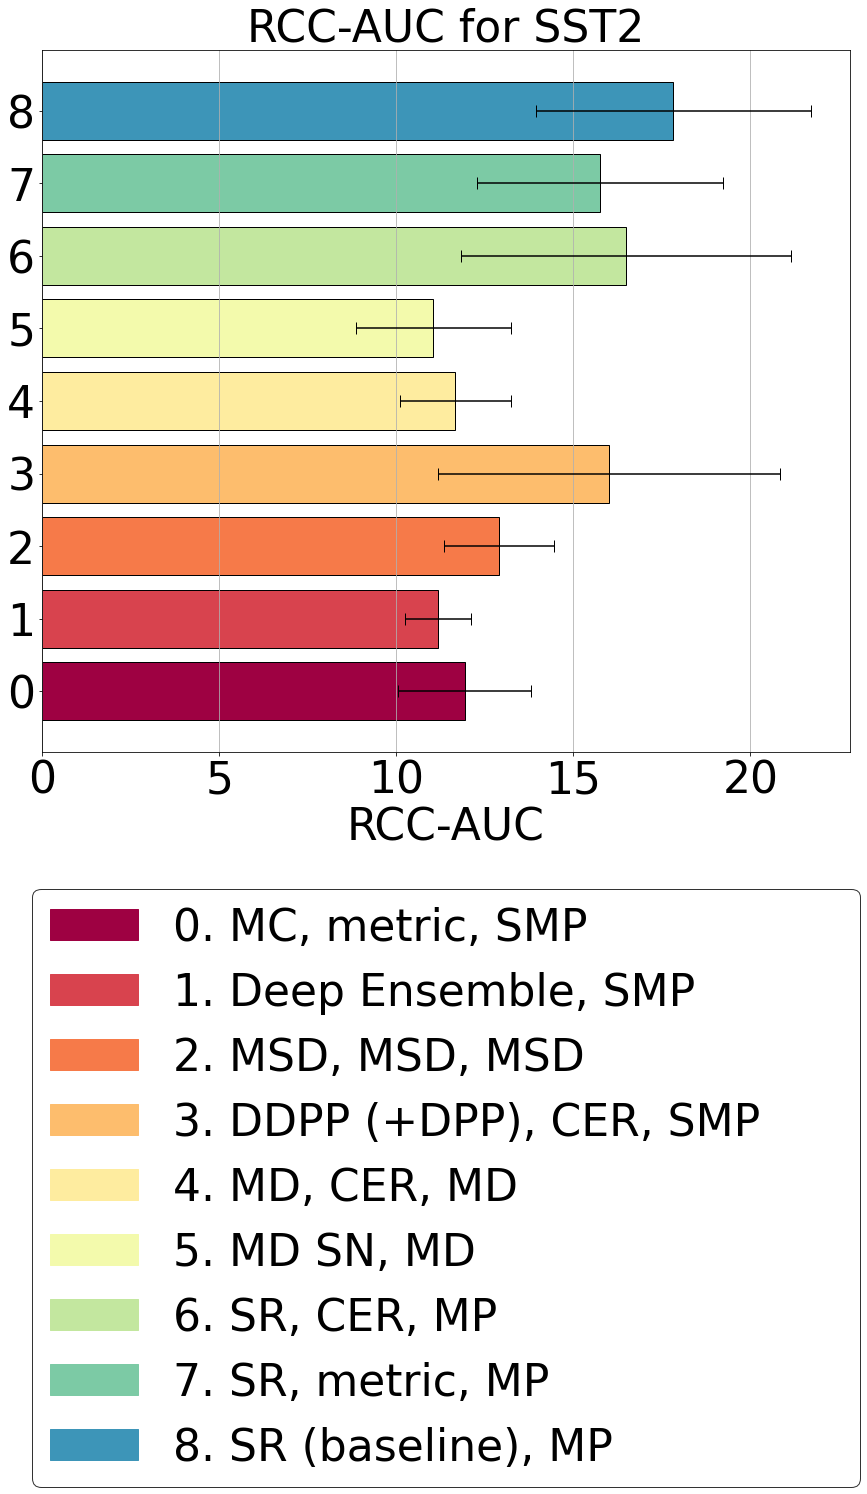

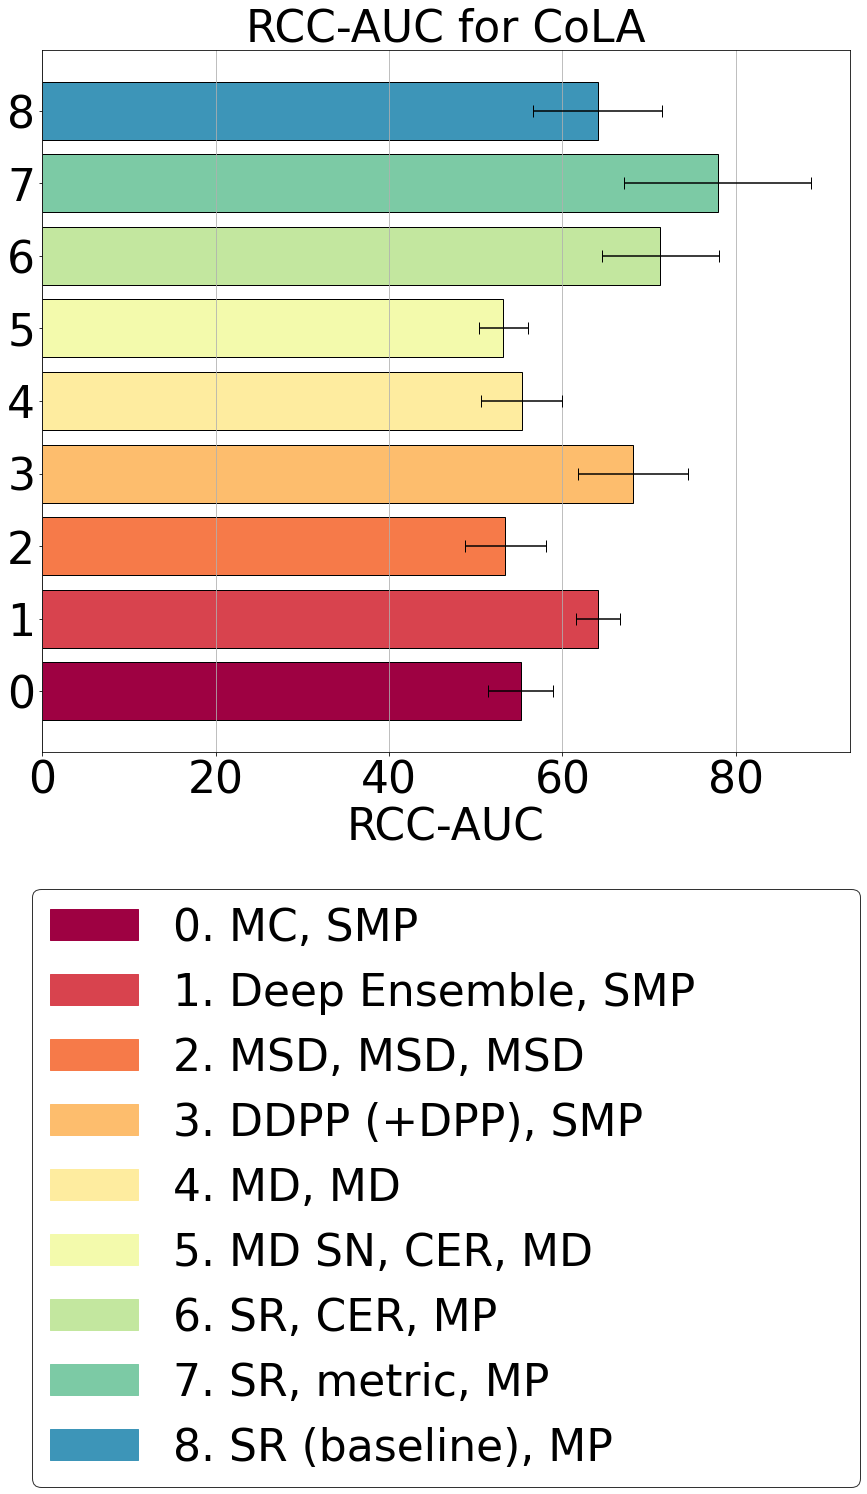

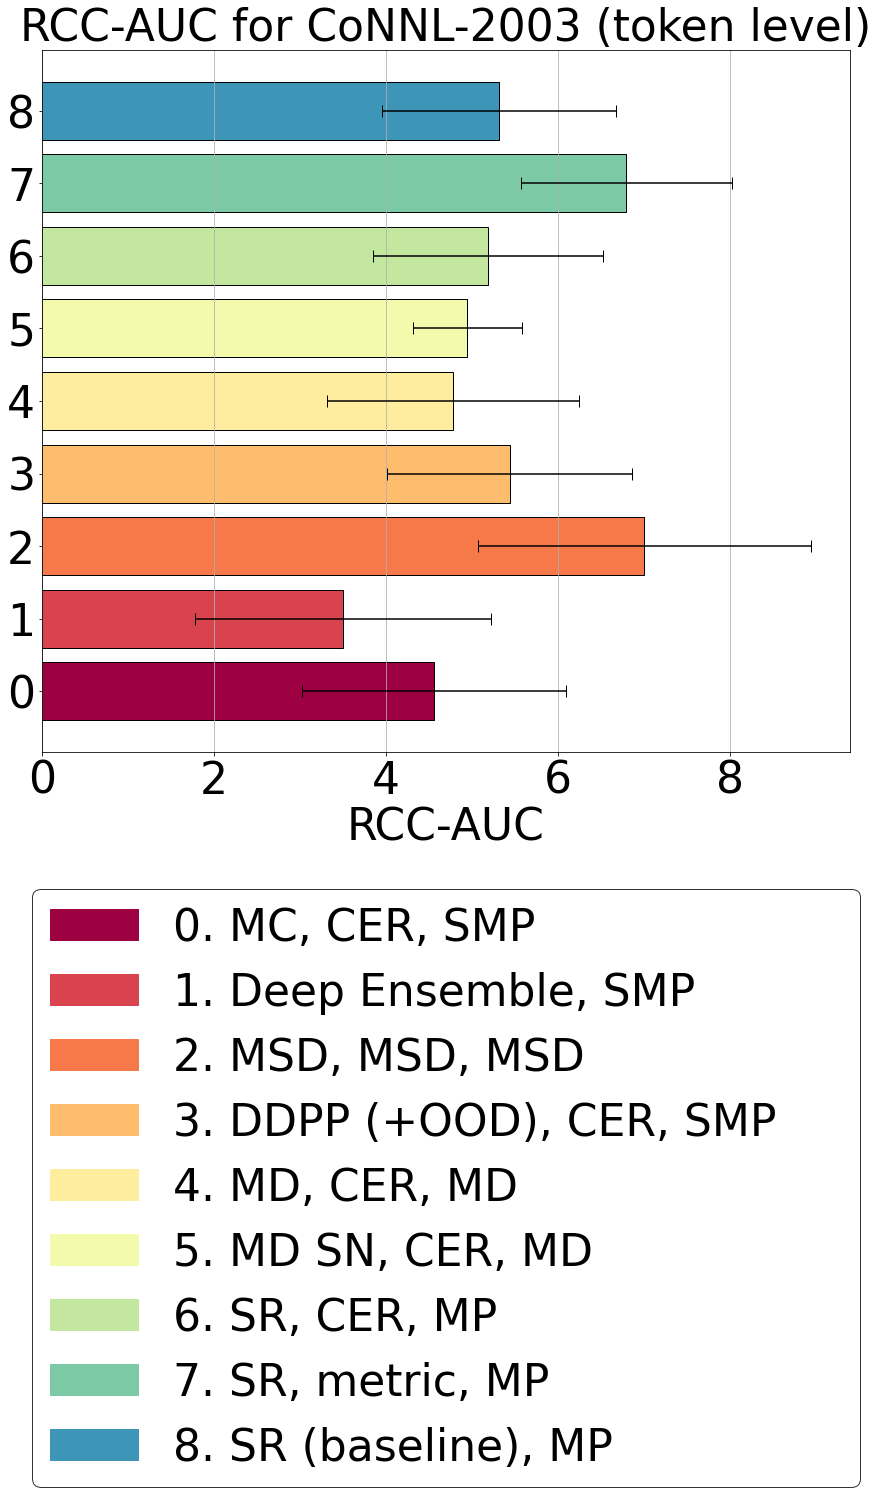

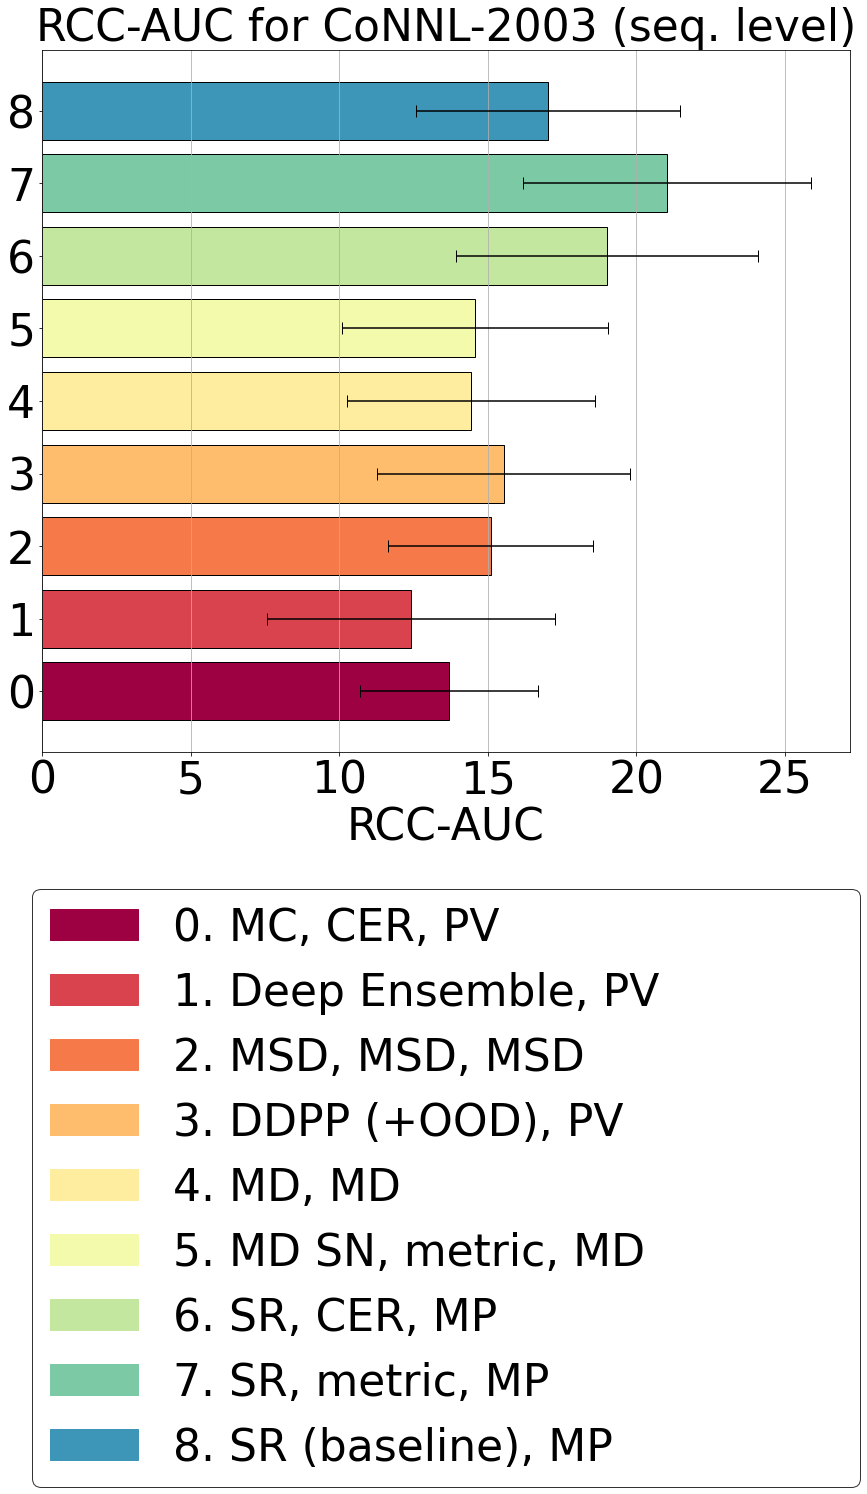

In [32]:
metrics = ['rcc-auc']#, 'rpp']
dataset_names = ['MRPC', 'SST2', 'CoLA'] + ['CoNNL-2003 (token level)', 'CoNNL-2003 (seq. level)']
for dataset in dataset_names:
    plot_bar_charts_by_table(best_res_deberta_new, dataset, metrics, name_prefix='workdir/new_final_results/deberta_recalc/bar_charts_deberta_recalc_rcc_best_hor_big/deberta_', ids=ids)

# The rest

In [ ]:
# Maha SN, Distilbert
reg_types = ['-', 'metric', 'CER']
cls_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/distilbert/raw_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/distilbert/metric_171_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/distilbert/cer_sn/',]
ner_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/distilbert/raw_sn/conll/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/distilbert/metric_171_sn/conll/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/distilbert/cer_sn/conll/',]
for idx in range(len(reg_types)):
    reg_type = reg_types[idx]
    cls_path = cls_pathes[idx]
    ner_path = ner_pathes[idx]
    print(f'Model with regularization: {reg_type}')
    #reg_path = '/data/gkuzmin/uncertainty-estimation/workdir/run_calc_ues_metrics/conll2003_electra_reg_01_fix/'
    ues = ['maha_sn']
    ues_names = ['MD SN (ours)']
    ues_layers = ['all']
    metrics = ['rcc-auc', 'rpp']
    metric_names = ['rcc-auc', 'rpp']
    types = ['mrpc', 'sst2', 'cola']
    types_names = ['MRPC', 'SST2', 'CoLA']
    ue_methods = ['max_prob', 'mahalanobis_distance']
    perc_metrics = ['rejection-curve-auc', 'rpp']
    diff_metrics = ['rejection-curve-auc', 'roc-auc']


    # copied from table
    baselines_dict = {'mrpcrejection-curve-aucmax_prob': 0.9208435457516339 * 100,
                      'mrpcrcc-aucmax_prob': 23.279293481630972,
                      'mrpcrppmax_prob': 0.026788574907087016 * 100,
                      'colarejection-curve-aucmax_prob': 0.9203619367209971 * 100,
                      'colarcc-aucmax_prob': 59.03726591032054,
                      'colarppmax_prob': 0.02631936969193335 * 100,
                      'sst2rejection-curve-aucmax_prob': 0.9379778287461774 * 100,
                      'sst2rcc-aucmax_prob': 18.067838464295736,
                      'sst2rppmax_prob': 0.012349462026204303 * 100,
                      '20ngrejection-curve-aucmax_prob': 0.9379778287461774 * 100,
                      '20ngrcc-aucmax_prob': 18.067838464295736,
                      '20ngrppmax_prob': 0.012349462026204303 * 100}
    raw_df, baselines_dict = get_df(cls_path, reg_type, baselines_dict, True)
    miscl_df = raw_df
    miscl_df.reset_index(inplace=True, drop=True)

    # NER
    types = ['token', 'seq']
    baselines_dict = {'tokenrejection-curve-aucmax_prob': 93.184446145,
                      'tokenrcc-aucmax_prob': 230.81709306328332,
                      'tokenrppmax_prob': 1.8920894383333335,
                      'seqrejection-curve-aucmax_prob': 85.96980676333334,
                      'seqrcc-aucmax_prob': 69.59317634405001,
                      'seqrppmax_prob': 7.4613176516666675}
    reg_df, baselines_dict = get_df_ner(ner_path, reg_type, baselines_dict, 1)
    ner_df = pd.concat([reg_df])
    ner_df.reset_index(inplace=True, drop=True)

    miscl_df.drop(['Method', 'Reg. Type', 'UE Score'], axis=1, inplace=True)
    miscl_df = pd.concat([ner_df, miscl_df], axis=1)

    latex_table = prepare_latex_table(miscl_df)
    print(latex_table)

Model with regularization: -
\begin{tabular}{lllllllllllll}
\toprule
       Method & Reg. Type &             UE Score & (CoNLL-2003 (token level), rcc-auc) & (CoNLL-2003 (token level), rpp) & (CoNLL-2003 (sequence level), rcc-auc) & (CoNLL-2003 (sequence level), rpp) & (MRPC, rcc-auc) &   (MRPC, rpp) & (SST2, rcc-auc) &   (SST2, rpp) & (CoLA, rcc-auc) &   (CoLA, rpp) \\
\midrule
 MD SN (Ours) &         - & MD &                       7.28$\pm$2.30 &                   0.10$\pm$0.03 &                         19.68$\pm$5.47 &                      1.95$\pm$0.33 &  29.89$\pm$2.22 & 3.48$\pm$0.27 &  32.99$\pm$3.74 & 2.03$\pm$0.20 & 104.40$\pm$5.39 & 4.32$\pm$0.16 \\
SR (baseline) &         - &             MP &                       7.45$\pm$1.72 &                   0.11$\pm$0.02 &                         22.55$\pm$5.36 &                      2.35$\pm$0.38 &  42.41$\pm$4.64 & 4.37$\pm$0.48 &  46.26$\pm$9.40 & 2.74$\pm$0.54 & 109.89$\pm$4.13 & 4.48$\pm$0.22 \\
\bottomrule
\end{tabular}

Model w

In [ ]:
# Maha, Distilbert
reg_types = ['-', 'metric', 'CER']
cls_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/distilbert/raw/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/distilbert/metric_171/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/distilbert/cer/',]
ner_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/distilbert/raw/conll/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/distilbert/metric_171/conll/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/distilbert/cer/conll/',]
for idx in range(len(reg_types)):
    reg_type = reg_types[idx]
    cls_path = cls_pathes[idx]
    ner_path = ner_pathes[idx]
    print(f'Model with regularization: {reg_type}')
    #reg_path = '/data/gkuzmin/uncertainty-estimation/workdir/run_calc_ues_metrics/conll2003_electra_reg_01_fix/'
    ues = ['maha']
    ues_names = ['MD']
    ues_layers = ['all']
    metrics = ['rcc-auc', 'rpp']
    metric_names = ['rcc-auc', 'rpp']
    types = ['mrpc', 'sst2', 'cola']
    types_names = ['MRPC', 'SST2', 'CoLA']
    ue_methods = ['max_prob', 'mahalanobis_distance']
    perc_metrics = ['rejection-curve-auc', 'rpp']
    diff_metrics = ['rejection-curve-auc', 'roc-auc']


    # copied from table
    baselines_dict = {'mrpcrejection-curve-aucmax_prob': 0.9208435457516339 * 100,
                      'mrpcrcc-aucmax_prob': 23.279293481630972,
                      'mrpcrppmax_prob': 0.026788574907087016 * 100,
                      'colarejection-curve-aucmax_prob': 0.9203619367209971 * 100,
                      'colarcc-aucmax_prob': 59.03726591032054,
                      'colarppmax_prob': 0.02631936969193335 * 100,
                      'sst2rejection-curve-aucmax_prob': 0.9379778287461774 * 100,
                      'sst2rcc-aucmax_prob': 18.067838464295736,
                      'sst2rppmax_prob': 0.012349462026204303 * 100,
                      '20ngrejection-curve-aucmax_prob': 0.9379778287461774 * 100,
                      '20ngrcc-aucmax_prob': 18.067838464295736,
                      '20ngrppmax_prob': 0.012349462026204303 * 100}
    raw_df, baselines_dict = get_df(cls_path, reg_type, baselines_dict, True)
    miscl_df = raw_df
    miscl_df.reset_index(inplace=True, drop=True)

    # NER
    types = ['token', 'seq']
    baselines_dict = {'tokenrejection-curve-aucmax_prob': 93.184446145,
                      'tokenrcc-aucmax_prob': 230.81709306328332,
                      'tokenrppmax_prob': 1.8920894383333335,
                      'seqrejection-curve-aucmax_prob': 85.96980676333334,
                      'seqrcc-aucmax_prob': 69.59317634405001,
                      'seqrppmax_prob': 7.4613176516666675}
    reg_df, baselines_dict = get_df_ner(ner_path, reg_type, baselines_dict, 1)
    ner_df = pd.concat([reg_df])
    ner_df.reset_index(inplace=True, drop=True)

    miscl_df.drop(['Method', 'Reg. Type', 'UE Score'], axis=1, inplace=True)
    miscl_df = pd.concat([ner_df, miscl_df], axis=1)

    latex_table = prepare_latex_table(miscl_df)
    print(latex_table)

Model with regularization: -
\begin{tabular}{lllllllllllll}
\toprule
       Method & Reg. Type &             UE Score & (CoNLL-2003 (token level), rcc-auc) & (CoNLL-2003 (token level), rpp) & (CoNLL-2003 (sequence level), rcc-auc) & (CoNLL-2003 (sequence level), rpp) & (MRPC, rcc-auc) &   (MRPC, rpp) & (SST2, rcc-auc) &   (SST2, rpp) &  (CoLA, rcc-auc) &   (CoLA, rpp) \\
\midrule
           MD &         - & MD &                       7.24$\pm$2.46 &                   0.10$\pm$0.03 &                         20.01$\pm$5.71 &                      1.98$\pm$0.22 &  26.24$\pm$2.13 & 3.12$\pm$0.23 &  29.69$\pm$3.10 & 1.79$\pm$0.18 & 120.22$\pm$10.12 & 4.67$\pm$0.30 \\
SR (baseline) &         - &             MP &                       7.53$\pm$2.14 &                   0.11$\pm$0.03 &                         22.43$\pm$5.16 &                      2.25$\pm$0.24 &  31.21$\pm$3.80 & 3.51$\pm$0.29 &  37.07$\pm$5.39 & 2.18$\pm$0.26 & 135.69$\pm$14.42 & 4.99$\pm$0.42 \\
\bottomrule
\end{tabular}

Mode

In [74]:
# Distilbert, Deep Ensemble
reg_types = ['-']
cls_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/distilbert_ensemble/',]
ner_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/distilbert_ensemble/conll2003/',]
for idx in range(len(reg_types)):
    reg_type = reg_types[idx]
    cls_path = cls_pathes[idx]
    ner_path = ner_pathes[idx]
    print(f'Model with regularization: {reg_type}')
    #reg_path = '/data/gkuzmin/uncertainty-estimation/workdir/run_calc_ues_metrics/conll2003_electra_reg_01_fix/'
    ues = ['de']
    ues_names = ['DE']
    ues_layers = ['-']
    metrics = ['rcc-auc', 'rpp']
    metric_names = ['rcc-auc', 'rpp']
    types = ['mrpc', 'sst2', 'cola']
    types_names = ['MRPC', 'SST2', 'CoLA']
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    perc_metrics = ['rejection-curve-auc', 'rpp']
    diff_metrics = ['rejection-curve-auc', 'roc-auc']


    # copied from table
    baselines_dict = {'mrpcrejection-curve-aucmax_prob': 0.9208435457516339 * 100,
                      'mrpcrcc-aucmax_prob': 23.279293481630972,
                      'mrpcrppmax_prob': 0.026788574907087016 * 100,
                      'colarejection-curve-aucmax_prob': 0.9203619367209971 * 100,
                      'colarcc-aucmax_prob': 59.03726591032054,
                      'colarppmax_prob': 0.02631936969193335 * 100,
                      'sst2rejection-curve-aucmax_prob': 0.9379778287461774 * 100,
                      'sst2rcc-aucmax_prob': 18.067838464295736,
                      'sst2rppmax_prob': 0.012349462026204303 * 100,
                      '20ngrejection-curve-aucmax_prob': 0.9379778287461774 * 100,
                      '20ngrcc-aucmax_prob': 18.067838464295736,
                      '20ngrppmax_prob': 0.012349462026204303 * 100}
    raw_df, baselines_dict = get_df(cls_path, reg_type, baselines_dict, True)
    miscl_df = raw_df
    miscl_df.reset_index(inplace=True, drop=True)

    # NER
    types = ['token', 'seq']
    baselines_dict = {'tokenrejection-curve-aucmax_prob': 93.184446145,
                      'tokenrcc-aucmax_prob': 230.81709306328332,
                      'tokenrppmax_prob': 1.8920894383333335,
                      'seqrejection-curve-aucmax_prob': 85.96980676333334,
                      'seqrcc-aucmax_prob': 69.59317634405001,
                      'seqrppmax_prob': 7.4613176516666675}
    reg_df, baselines_dict = get_df_ner(ner_path, reg_type, baselines_dict, 1)
    ner_df = pd.concat([reg_df])
    ner_df.reset_index(inplace=True, drop=True)

    miscl_df.drop(['Method', 'Reg. Type', 'UE Score'], axis=1, inplace=True)
    miscl_df = pd.concat([ner_df, miscl_df], axis=1)

    latex_table = prepare_latex_table(miscl_df)
    print(latex_table)

Model with regularization: -
\begin{tabular}{lllllllllllll}
\toprule
       Method & Reg. Type &         UE Score & (CoNLL-2003 (token level), rcc-auc) & (CoNLL-2003 (token level), rpp) & (CoNLL-2003 (sequence level), rcc-auc) & (CoNLL-2003 (sequence level), rpp) & (MRPC, rcc-auc) &   (MRPC, rpp) & (SST2, rcc-auc) &   (SST2, rpp) &  (CoLA, rcc-auc) &   (CoLA, rpp) \\
\midrule
           DE &         - &         PV &                       6.30$\pm$2.54 &                   0.08$\pm$0.03 &                         17.17$\pm$2.38 &                      1.59$\pm$0.30 &  34.20$\pm$3.28 & 3.36$\pm$0.08 &  29.69$\pm$4.80 & 1.61$\pm$0.20 & 122.00$\pm$12.58 & 4.40$\pm$0.27 \\
           DE &         - &             BALD &                       5.89$\pm$1.76 &                   0.08$\pm$0.03 &                         17.46$\pm$2.44 &                      1.60$\pm$0.31 &  35.41$\pm$3.94 & 3.44$\pm$0.08 &  30.38$\pm$4.89 & 1.64$\pm$0.20 & 123.73$\pm$13.09 & 4.45$\pm$0.27 \\
           DE &         -

In [97]:
# Distilbert, Mixup
reg_types = ['MSD']
cls_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/mixup_distilbert_fix_repro_fix/',]
ner_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/mixup_distilbert_fix_repro_fix/conll/',]
for idx in range(len(reg_types)):
    reg_type = reg_types[idx]
    cls_path = cls_pathes[idx]
    ner_path = ner_pathes[idx]
    print(f'Model with regularization: {reg_type}')
    #reg_path = '/data/gkuzmin/uncertainty-estimation/workdir/run_calc_ues_metrics/conll2003_electra_reg_01_fix/'
    ues = ['msd/all', 'msd/last']
    ues_names = ['MSD-all', 'MSD-last']
    ues_layers = ['all', 'last']
    metrics = ['rcc-auc', 'rpp']
    metric_names = ['rcc-auc', 'rpp']
    types = ['mrpc', 'sst2', 'cola']
    types_names = ['MRPC', 'SST2', 'CoLA']
    ue_methods = ['max_prob', 'mixup']
    perc_metrics = ['rejection-curve-auc', 'rpp']
    diff_metrics = ['rejection-curve-auc', 'roc-auc']


    # copied from table
    baselines_dict = {'mrpcrejection-curve-aucmax_prob': 0.9208435457516339 * 100,
                      'mrpcrcc-aucmax_prob': 23.279293481630972,
                      'mrpcrppmax_prob': 0.026788574907087016 * 100,
                      'colarejection-curve-aucmax_prob': 0.9203619367209971 * 100,
                      'colarcc-aucmax_prob': 59.03726591032054,
                      'colarppmax_prob': 0.02631936969193335 * 100,
                      'sst2rejection-curve-aucmax_prob': 0.9379778287461774 * 100,
                      'sst2rcc-aucmax_prob': 18.067838464295736,
                      'sst2rppmax_prob': 0.012349462026204303 * 100,
                      '20ngrejection-curve-aucmax_prob': 0.9379778287461774 * 100,
                      '20ngrcc-aucmax_prob': 18.067838464295736,
                      '20ngrppmax_prob': 0.012349462026204303 * 100}
    raw_df, baselines_dict = get_df(cls_path, reg_type, baselines_dict, True)
    miscl_df = raw_df
    miscl_df.reset_index(inplace=True, drop=True)

    # NER
    ues = ['mixup/all', 'mixup/last']
    types = ['token', 'seq']
    baselines_dict = {'tokenrejection-curve-aucmax_prob': 93.184446145,
                      'tokenrcc-aucmax_prob': 230.81709306328332,
                      'tokenrppmax_prob': 1.8920894383333335,
                      'seqrejection-curve-aucmax_prob': 85.96980676333334,
                      'seqrcc-aucmax_prob': 69.59317634405001,
                      'seqrppmax_prob': 7.4613176516666675}
    reg_df, baselines_dict = get_df_ner(ner_path, reg_type, baselines_dict, 1)
    ner_df = pd.concat([reg_df])
    ner_df.reset_index(inplace=True, drop=True)

    miscl_df.drop(['Method', 'Reg. Type', 'UE Score'], axis=1, inplace=True)
    miscl_df = pd.concat([ner_df, miscl_df], axis=1)

    latex_table = prepare_latex_table(miscl_df)
    print(latex_table)

Model with regularization: MSD
\begin{tabular}{lllllllllllll}
\toprule
       Method & Reg. Type & UE Score & (CoNLL-2003 (token level), rcc-auc) & (CoNLL-2003 (token level), rpp) & (CoNLL-2003 (sequence level), rcc-auc) & (CoNLL-2003 (sequence level), rpp) & (MRPC, rcc-auc) &   (MRPC, rpp) & (SST2, rcc-auc) &   (SST2, rpp) &  (CoLA, rcc-auc) &   (CoLA, rpp) \\
\midrule
      MSD-all &       MSD &    DS &                       6.39$\pm$1.67 &                   0.09$\pm$0.02 &                         17.70$\pm$3.57 &                      1.85$\pm$0.09 &  58.41$\pm$6.88 & 6.87$\pm$1.16 &  29.97$\pm$2.81 & 1.84$\pm$0.19 & 118.91$\pm$27.91 & 4.97$\pm$1.26 \\
     MSD-last &       MSD &    DS &                       6.46$\pm$1.67 &                   0.09$\pm$0.02 &                         17.76$\pm$3.54 &                      1.86$\pm$0.09 &  58.49$\pm$6.85 & 6.89$\pm$1.15 &  30.08$\pm$2.82 & 1.85$\pm$0.19 & 120.80$\pm$27.37 & 5.04$\pm$1.17 \\
SR (baseline) &       MSD & MP &               

In [106]:
# MC-all, dpp, dpp with ood, Distilbert
reg_types = ['-', 'metric', 'CER']
cls_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_raw_no_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_metric_no_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_reg_no_sn/',]
ner_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_raw_no_sn/conll2003/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_metric_no_sn/conll2003/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_reg_no_sn/conll2003/',]
for idx in range(len(reg_types)):
    reg_type = reg_types[idx]
    cls_path = cls_pathes[idx]
    ner_path = ner_pathes[idx]
    print(f'Model with regularization: {reg_type}')
    #reg_path = '/data/gkuzmin/uncertainty-estimation/workdir/run_calc_ues_metrics/conll2003_electra_reg_01_fix/'
    ues = ['mc_all', 'ddpp_dpp', 'ddpp_ood']
    ues_names = ['MC', 'DDPP (+DPP) (ours)', 'DDPP (+OOD) (ours)']
    ues_layers = ['all', 'all', 'all']
    metrics = ['rcc-auc', 'rpp']
    metric_names = ['rcc-auc', 'rpp']
    types = ['mrpc', 'sst2', 'cola']
    types_names = ['MRPC', 'SST2', 'CoLA']
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    perc_metrics = ['rejection-curve-auc', 'rpp']
    diff_metrics = ['rejection-curve-auc', 'roc-auc']


    # copied from table
    baselines_dict = {'mrpcrejection-curve-aucmax_prob': 0.9208435457516339 * 100,
                      'mrpcrcc-aucmax_prob': 23.279293481630972,
                      'mrpcrppmax_prob': 0.026788574907087016 * 100,
                      'colarejection-curve-aucmax_prob': 0.9203619367209971 * 100,
                      'colarcc-aucmax_prob': 59.03726591032054,
                      'colarppmax_prob': 0.02631936969193335 * 100,
                      'sst2rejection-curve-aucmax_prob': 0.9379778287461774 * 100,
                      'sst2rcc-aucmax_prob': 18.067838464295736,
                      'sst2rppmax_prob': 0.012349462026204303 * 100,
                      '20ngrejection-curve-aucmax_prob': 0.9379778287461774 * 100,
                      '20ngrcc-aucmax_prob': 18.067838464295736,
                      '20ngrppmax_prob': 0.012349462026204303 * 100}
    raw_df, baselines_dict = get_df(cls_path, reg_type, baselines_dict, True)
    miscl_df = raw_df
    miscl_df.reset_index(inplace=True, drop=True)

    # NER
    types = ['token', 'seq']
    baselines_dict = {'tokenrejection-curve-aucmax_prob': 93.184446145,
                      'tokenrcc-aucmax_prob': 230.81709306328332,
                      'tokenrppmax_prob': 1.8920894383333335,
                      'seqrejection-curve-aucmax_prob': 85.96980676333334,
                      'seqrcc-aucmax_prob': 69.59317634405001,
                      'seqrppmax_prob': 7.4613176516666675}
    reg_df, baselines_dict = get_df_ner(ner_path, reg_type, baselines_dict, 1)
    ner_df = pd.concat([reg_df])
    ner_df.reset_index(inplace=True, drop=True)

    miscl_df.drop(['Method', 'Reg. Type', 'UE Score'], axis=1, inplace=True)
    miscl_df = pd.concat([ner_df, miscl_df], axis=1)

    latex_table = prepare_latex_table(miscl_df)
    print(latex_table)

Model with regularization: -
There are several rows for SR, used first one
                    MRPC                           SST2                 \
                 rcc-auc            rpp         rcc-auc            rpp   
max_prob  22.65$\pm$3.97  2.67$\pm$0.36  18.25$\pm$1.80  1.23$\pm$0.12   
max_prob  22.33$\pm$3.84  2.66$\pm$0.35  18.25$\pm$1.80  1.23$\pm$0.12   

                    CoLA                 
                 rcc-auc            rpp  
max_prob  69.61$\pm$4.25  3.32$\pm$0.17  
max_prob  69.49$\pm$4.17  3.32$\pm$0.17  
\begin{tabular}{lllllllllllll}
\toprule
            Method & Reg. Type &         UE Score & (CoNLL-2003 (token level), rcc-auc) & (CoNLL-2003 (token level), rpp) & (CoNLL-2003 (sequence level), rcc-auc) & (CoNLL-2003 (sequence level), rpp) & (MRPC, rcc-auc) &   (MRPC, rpp) & (SST2, rcc-auc) &   (SST2, rpp) & (CoLA, rcc-auc) &   (CoLA, rpp) \\
\midrule
                MC &         - &         PV &                       5.27$\pm$0.89 &                   0.08

In [79]:
# Maha SN, Deberta
reg_types = ['-', 'metric', 'CER']
cls_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_raw_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_metric_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_reg_sn/',]
ner_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_raw_sn/conll2003/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_metric_sn/conll2003/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_reg_sn/conll2003/',]
for idx in range(len(reg_types)):
    reg_type = reg_types[idx]
    cls_path = cls_pathes[idx]
    ner_path = ner_pathes[idx]
    print(f'Model with regularization: {reg_type}')
    #reg_path = '/data/gkuzmin/uncertainty-estimation/workdir/run_calc_ues_metrics/conll2003_electra_reg_01_fix/'
    ues = ['mahalanobis']
    ues_names = ['MD SN (ours)']
    ues_layers = ['all']
    metrics = ['rcc-auc', 'rpp']
    metric_names = ['rcc-auc', 'rpp']
    types = ['mrpc', 'sst2', 'cola']
    types_names = ['MRPC', 'SST2', 'CoLA']
    ue_methods = ['max_prob', 'mahalanobis_distance']
    perc_metrics = ['rejection-curve-auc', 'rpp']
    diff_metrics = ['rejection-curve-auc', 'roc-auc']


    # copied from table
    baselines_dict = {'mrpcrejection-curve-aucmax_prob': 0.9208435457516339 * 100,
                      'mrpcrcc-aucmax_prob': 23.279293481630972,
                      'mrpcrppmax_prob': 0.026788574907087016 * 100,
                      'colarejection-curve-aucmax_prob': 0.9203619367209971 * 100,
                      'colarcc-aucmax_prob': 59.03726591032054,
                      'colarppmax_prob': 0.02631936969193335 * 100,
                      'sst2rejection-curve-aucmax_prob': 0.9379778287461774 * 100,
                      'sst2rcc-aucmax_prob': 18.067838464295736,
                      'sst2rppmax_prob': 0.012349462026204303 * 100,
                      '20ngrejection-curve-aucmax_prob': 0.9379778287461774 * 100,
                      '20ngrcc-aucmax_prob': 18.067838464295736,
                      '20ngrppmax_prob': 0.012349462026204303 * 100}
    raw_df, baselines_dict = get_df(cls_path, reg_type, baselines_dict, True)
    miscl_df = raw_df
    miscl_df.reset_index(inplace=True, drop=True)

    # NER
    types = ['token', 'seq']
    baselines_dict = {'tokenrejection-curve-aucmax_prob': 93.184446145,
                      'tokenrcc-aucmax_prob': 230.81709306328332,
                      'tokenrppmax_prob': 1.8920894383333335,
                      'seqrejection-curve-aucmax_prob': 85.96980676333334,
                      'seqrcc-aucmax_prob': 69.59317634405001,
                      'seqrppmax_prob': 7.4613176516666675}
    reg_df, baselines_dict = get_df_ner(ner_path, reg_type, baselines_dict, 1)
    ner_df = pd.concat([reg_df])
    ner_df.reset_index(inplace=True, drop=True)

    miscl_df.drop(['Method', 'Reg. Type', 'UE Score'], axis=1, inplace=True)
    miscl_df = pd.concat([ner_df, miscl_df], axis=1)

    latex_table = prepare_latex_table(miscl_df)
    print(latex_table)

Model with regularization: -
\begin{tabular}{lllllllllllll}
\toprule
       Method & Reg. Type &             UE Score & (CoNLL-2003 (token level), rcc-auc) & (CoNLL-2003 (token level), rpp) & (CoNLL-2003 (sequence level), rcc-auc) & (CoNLL-2003 (sequence level), rpp) & (MRPC, rcc-auc) &   (MRPC, rpp) & (SST2, rcc-auc) &   (SST2, rpp) & (CoLA, rcc-auc) &   (CoLA, rpp) \\
\midrule
 MD SN (Ours) &         - & MD &                       5.36$\pm$1.14 &                   0.08$\pm$0.01 &                         16.72$\pm$4.89 &                      1.90$\pm$0.18 &  12.28$\pm$0.74 & 1.73$\pm$0.11 &  12.46$\pm$1.94 & 0.90$\pm$0.13 &  54.40$\pm$4.10 & 2.66$\pm$0.18 \\
SR (baseline) &         - &             MP &                       4.74$\pm$0.88 &                   0.07$\pm$0.01 &                         18.01$\pm$3.76 &                      2.08$\pm$0.31 &  22.60$\pm$5.09 & 2.47$\pm$0.43 &  18.07$\pm$4.99 & 1.22$\pm$0.30 &  63.14$\pm$4.09 & 3.07$\pm$0.26 \\
\bottomrule
\end{tabular}

Model w

In [80]:
# Maha, Deberta
reg_types = ['-', 'metric', 'CER']
cls_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_raw_no_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_metric_no_sn/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_reg_no_sn/',]
ner_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_raw_no_sn/conll2003/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_metric_no_sn/conll2003/',
              '/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_reg_no_sn/conll2003/',]
for idx in range(len(reg_types)):
    reg_type = reg_types[idx]
    cls_path = cls_pathes[idx]
    ner_path = ner_pathes[idx]
    print(f'Model with regularization: {reg_type}')
    #reg_path = '/data/gkuzmin/uncertainty-estimation/workdir/run_calc_ues_metrics/conll2003_electra_reg_01_fix/'
    ues = ['mahalanobis']
    ues_names = ['MD']
    ues_layers = ['all']
    metrics = ['rcc-auc', 'rpp']
    metric_names = ['rcc-auc', 'rpp']
    types = ['mrpc', 'sst2', 'cola']
    types_names = ['MRPC', 'SST2', 'CoLA']
    ue_methods = ['max_prob', 'mahalanobis_distance']
    perc_metrics = ['rejection-curve-auc', 'rpp']
    diff_metrics = ['rejection-curve-auc', 'roc-auc']


    # copied from table
    baselines_dict = {'mrpcrejection-curve-aucmax_prob': 0.9208435457516339 * 100,
                      'mrpcrcc-aucmax_prob': 23.279293481630972,
                      'mrpcrppmax_prob': 0.026788574907087016 * 100,
                      'colarejection-curve-aucmax_prob': 0.9203619367209971 * 100,
                      'colarcc-aucmax_prob': 59.03726591032054,
                      'colarppmax_prob': 0.02631936969193335 * 100,
                      'sst2rejection-curve-aucmax_prob': 0.9379778287461774 * 100,
                      'sst2rcc-aucmax_prob': 18.067838464295736,
                      'sst2rppmax_prob': 0.012349462026204303 * 100,
                      '20ngrejection-curve-aucmax_prob': 0.9379778287461774 * 100,
                      '20ngrcc-aucmax_prob': 18.067838464295736,
                      '20ngrppmax_prob': 0.012349462026204303 * 100}
    raw_df, baselines_dict = get_df(cls_path, reg_type, baselines_dict, True)
    miscl_df = raw_df
    miscl_df.reset_index(inplace=True, drop=True)

    # NER
    types = ['token', 'seq']
    baselines_dict = {'tokenrejection-curve-aucmax_prob': 93.184446145,
                      'tokenrcc-aucmax_prob': 230.81709306328332,
                      'tokenrppmax_prob': 1.8920894383333335,
                      'seqrejection-curve-aucmax_prob': 85.96980676333334,
                      'seqrcc-aucmax_prob': 69.59317634405001,
                      'seqrppmax_prob': 7.4613176516666675}
    reg_df, baselines_dict = get_df_ner(ner_path, reg_type, baselines_dict, 1)
    ner_df = pd.concat([reg_df])
    ner_df.reset_index(inplace=True, drop=True)

    miscl_df.drop(['Method', 'Reg. Type', 'UE Score'], axis=1, inplace=True)
    miscl_df = pd.concat([ner_df, miscl_df], axis=1)

    latex_table = prepare_latex_table(miscl_df)
    print(latex_table)

Model with regularization: -
\begin{tabular}{lllllllllllll}
\toprule
       Method & Reg. Type &             UE Score & (CoNLL-2003 (token level), rcc-auc) & (CoNLL-2003 (token level), rpp) & (CoNLL-2003 (sequence level), rcc-auc) & (CoNLL-2003 (sequence level), rpp) & (MRPC, rcc-auc) &   (MRPC, rpp) & (SST2, rcc-auc) &   (SST2, rpp) & (CoLA, rcc-auc) &   (CoLA, rpp) \\
\midrule
           MD &         - & MD &                       4.87$\pm$0.89 &                   0.07$\pm$0.01 &                         14.44$\pm$4.09 &                      1.78$\pm$0.47 &  16.56$\pm$3.44 & 2.21$\pm$0.37 &  13.00$\pm$3.11 & 0.89$\pm$0.20 &  58.02$\pm$4.50 & 2.80$\pm$0.18 \\
SR (baseline) &         - &             MP &                       5.37$\pm$0.44 &                   0.08$\pm$0.01 &                         17.31$\pm$5.20 &                      2.12$\pm$0.58 &  22.65$\pm$3.97 & 2.67$\pm$0.36 &  18.25$\pm$1.80 & 1.23$\pm$0.12 &  69.61$\pm$4.25 & 3.32$\pm$0.17 \\
\bottomrule
\end{tabular}

Model w

In [123]:
# Deberta, Deep Ensemble
reg_types = ['-']
cls_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_raw_no_sn/',]
ner_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/deberta/deberta_raw_no_sn/conll2003/',]
for idx in range(len(reg_types)):
    reg_type = reg_types[idx]
    cls_path = cls_pathes[idx]
    ner_path = ner_pathes[idx]
    print(f'Model with regularization: {reg_type}')
    #reg_path = '/data/gkuzmin/uncertainty-estimation/workdir/run_calc_ues_metrics/conll2003_electra_reg_01_fix/'
    ues = ['deep_ensemble']
    ues_names = ['DE']
    ues_layers = ['-']
    metrics = ['rcc-auc', 'rpp']
    metric_names = ['rcc-auc', 'rpp']
    types = ['mrpc', 'sst2', 'cola']
    types_names = ['MRPC', 'SST2', 'CoLA']
    ue_methods = ['max_prob', 'variance', 'bald', 'sampled_max_prob']
    perc_metrics = ['rejection-curve-auc', 'rpp']
    diff_metrics = ['rejection-curve-auc', 'roc-auc']


    # copied from table
    baselines_dict = {'mrpcrejection-curve-aucmax_prob': 0.9208435457516339 * 100,
                      'mrpcrcc-aucmax_prob': 23.279293481630972,
                      'mrpcrppmax_prob': 0.026788574907087016 * 100,
                      'colarejection-curve-aucmax_prob': 0.9203619367209971 * 100,
                      'colarcc-aucmax_prob': 59.03726591032054,
                      'colarppmax_prob': 0.02631936969193335 * 100,
                      'sst2rejection-curve-aucmax_prob': 0.9379778287461774 * 100,
                      'sst2rcc-aucmax_prob': 18.067838464295736,
                      'sst2rppmax_prob': 0.012349462026204303 * 100,
                      '20ngrejection-curve-aucmax_prob': 0.9379778287461774 * 100,
                      '20ngrcc-aucmax_prob': 18.067838464295736,
                      '20ngrppmax_prob': 0.012349462026204303 * 100}
    raw_df, baselines_dict = get_df(cls_path, reg_type, baselines_dict, True)
    miscl_df = raw_df
    miscl_df.reset_index(inplace=True, drop=True)

    # NER
    types = ['token', 'seq']
    baselines_dict = {'tokenrejection-curve-aucmax_prob': 93.184446145,
                      'tokenrcc-aucmax_prob': 230.81709306328332,
                      'tokenrppmax_prob': 1.8920894383333335,
                      'seqrejection-curve-aucmax_prob': 85.96980676333334,
                      'seqrcc-aucmax_prob': 69.59317634405001,
                      'seqrppmax_prob': 7.4613176516666675}
    reg_df, baselines_dict = get_df_ner(ner_path, reg_type, baselines_dict, 1)
    ner_df = pd.concat([reg_df])
    ner_df.reset_index(inplace=True, drop=True)

    miscl_df.drop(['Method', 'Reg. Type', 'UE Score'], axis=1, inplace=True)
    miscl_df = pd.concat([ner_df, miscl_df], axis=1)

    latex_table = prepare_latex_table(miscl_df)
    print(latex_table)

Model with regularization: -
There are several rows for SR, used first one
MRPC  rcc-auc    23.59$\pm$6.34
      rpp         2.66$\pm$0.39
SST2  rcc-auc    17.12$\pm$1.87
      rpp         1.13$\pm$0.09
CoLA  rcc-auc    82.36$\pm$4.37
      rpp         3.88$\pm$0.17
Name: max_prob, dtype: object
\begin{tabular}{lllllllllllll}
\toprule
       Method & Reg. Type &         UE Score & (CoNLL-2003 (token level), rcc-auc) & (CoNLL-2003 (token level), rpp) & (CoNLL-2003 (sequence level), rcc-auc) & (CoNLL-2003 (sequence level), rpp) & (MRPC, rcc-auc) &    (MRPC, rpp) & (SST2, rcc-auc) &    (SST2, rpp) & (CoLA, rcc-auc) &    (CoLA, rpp) \\
\midrule
           DE &         - &         PV &                       3.82$\pm$1.86 &                   0.05$\pm$0.03 &                         11.85$\pm$3.05 &                      1.39$\pm$0.48 &  18.71$\pm$2.55 &  2.02$\pm$0.23 &  11.90$\pm$1.02 &  0.75$\pm$0.03 & 81.47$\pm$13.66 &  3.32$\pm$0.23 \\
           DE &         - &             BALD &        

In [98]:
# Deberta, Mixup
reg_types = ['MSD']

cls_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/mixup_deberta_fix_repro_fix/',]
ner_pathes = ['/home/jovyan/uncertainty-estimation/workdir/final_results/mixup_deberta_fix_repro_fix/conll/',]
for idx in range(len(reg_types)):
    reg_type = reg_types[idx]
    cls_path = cls_pathes[idx]
    ner_path = ner_pathes[idx]
    print(f'Model with regularization: {reg_type}')
    #reg_path = '/data/gkuzmin/uncertainty-estimation/workdir/run_calc_ues_metrics/conll2003_electra_reg_01_fix/'
    ues = ['msd/all', 'msd/last']
    ues_names = ['MSD-all', 'MSD-last']
    ues_layers = ['all', 'last']
    metrics = ['rcc-auc', 'rpp']
    metric_names = ['rcc-auc', 'rpp']
    types = ['mrpc', 'sst2', 'cola']
    types_names = ['MRPC', 'SST2', 'CoLA']
    ue_methods = ['max_prob', 'mixup']
    perc_metrics = ['rejection-curve-auc', 'rpp']
    diff_metrics = ['rejection-curve-auc', 'roc-auc']


    # copied from table
    baselines_dict = {'mrpcrejection-curve-aucmax_prob': 0.9208435457516339 * 100,
                      'mrpcrcc-aucmax_prob': 23.279293481630972,
                      'mrpcrppmax_prob': 0.026788574907087016 * 100,
                      'colarejection-curve-aucmax_prob': 0.9203619367209971 * 100,
                      'colarcc-aucmax_prob': 59.03726591032054,
                      'colarppmax_prob': 0.02631936969193335 * 100,
                      'sst2rejection-curve-aucmax_prob': 0.9379778287461774 * 100,
                      'sst2rcc-aucmax_prob': 18.067838464295736,
                      'sst2rppmax_prob': 0.012349462026204303 * 100,
                      '20ngrejection-curve-aucmax_prob': 0.9379778287461774 * 100,
                      '20ngrcc-aucmax_prob': 18.067838464295736,
                      '20ngrppmax_prob': 0.012349462026204303 * 100}
    raw_df, baselines_dict = get_df(cls_path, reg_type, baselines_dict, True)
    miscl_df = raw_df
    miscl_df.reset_index(inplace=True, drop=True)

    # NER
    ues = ['mixup/all', 'mixup/last']
    types = ['token', 'seq']
    baselines_dict = {'tokenrejection-curve-aucmax_prob': 93.184446145,
                      'tokenrcc-aucmax_prob': 230.81709306328332,
                      'tokenrppmax_prob': 1.8920894383333335,
                      'seqrejection-curve-aucmax_prob': 85.96980676333334,
                      'seqrcc-aucmax_prob': 69.59317634405001,
                      'seqrppmax_prob': 7.4613176516666675}
    reg_df, baselines_dict = get_df_ner(ner_path, reg_type, baselines_dict, 1)
    ner_df = pd.concat([reg_df])
    ner_df.reset_index(inplace=True, drop=True)

    miscl_df.drop(['Method', 'Reg. Type', 'UE Score'], axis=1, inplace=True)
    miscl_df = pd.concat([ner_df, miscl_df], axis=1)

    latex_table = prepare_latex_table(miscl_df)
    print(latex_table)

Model with regularization: MSD
\begin{tabular}{lllllllllllll}
\toprule
       Method & Reg. Type & UE Score & (CoNLL-2003 (token level), rcc-auc) & (CoNLL-2003 (token level), rpp) & (CoNLL-2003 (sequence level), rcc-auc) & (CoNLL-2003 (sequence level), rpp) & (MRPC, rcc-auc) &   (MRPC, rpp) & (SST2, rcc-auc) &   (SST2, rpp) &  (CoLA, rcc-auc) &   (CoLA, rpp) \\
\midrule
      MSD-all &       MSD &    DS &                       6.84$\pm$2.28 &                   0.10$\pm$0.03 &                         14.68$\pm$3.92 &                      1.82$\pm$0.45 &  13.08$\pm$1.25 & 1.88$\pm$0.19 &  11.66$\pm$2.60 & 0.81$\pm$0.12 &   53.42$\pm$4.73 & 2.61$\pm$0.20 \\
     MSD-last &       MSD &    DS &                       6.84$\pm$2.28 &                   0.10$\pm$0.03 &                         14.68$\pm$3.94 &                      1.82$\pm$0.45 &  13.08$\pm$1.25 & 1.88$\pm$0.19 &  11.66$\pm$2.60 & 0.81$\pm$0.12 &   53.42$\pm$4.73 & 2.61$\pm$0.20 \\
SR (baseline) &       MSD & MP &               